<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2021 - Homework 02</h1>

<h3 style="color:blue">2021-05-31</h3>

<h3 style="color:blue"> Authors: David Farré Gil, Blai Ras Jimenez, Irene Bonafonte Pardàs </h3>

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

## Data Reading

In [1]:
data <- read.csv("aug_train.csv")
test <- read.csv("aug_test.csv")

In [2]:
test_response <- read.csv("Test_Response.csv")

In [3]:
test$Response <- test_response$Response

## Data Analysis

### Variables

01. `id`:        id of the subject.   
02. `Gender`:        Sex of the subject.
03. `Age`:         Age of the subject.
04. `Driving License`:      Whether if the subject has or not a driver's license.
05. `Region_Code`:          Coded region name.
06. `Previously_Insured`:      Whether if the subject has already a health insurance.
07. `Vehicle_Age`:  Number of years of the subject's car.
08. `Vehicle_Damage`:   Measure of detriment of the subject's car.
09. `Annual_Premium`:          Number of citations in total.
10. `Policy_Sales_Channel`:      Sum of money that the subject needs to pay regularly to an insurance company.
11. `Vintage`:     Days the subject is insured until now.
12. `Response`: Whether the subject said yes or no to getting a vehicle insurance.

As we can see, we will get rid of the variables `id`, `Region_Code` and `Policy_Sales_Channel` since they do not bring any substantial information towards the goal of predicting whether a customer would be interested in Vehicle Insurance. Even if they did, they should not be used towards that goal, it may even be a case of spurious correlation.

In [4]:
columns <- c("Gender","Age","Driving_License","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Vintage","Response")
data <- data[,columns]
test <- test[,columns]

In [5]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : Factor w/ 2 levels "Female","Male": 2 2 1 1 2 1 2 2 1 2 ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : Factor w/ 3 levels "< 1 Year","> 2 Years",..: 1 3 3 1 1 1 3 3 3 3 ...
 $ Vehicle_Damage    : Factor w/ 2 levels "No","Yes": 1 2 2 1 1 1 2 1 2 2 ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


As we can see, there's a few categorical columns. For the sake of the model creation and training, we will convert them to numerical, e.g. ``Female`` is coded to ``0`` and ``Male`` is coded to  ``1``, using the ``preprocess`` function below. We can convert ``Vehilce_Age`` to numerical in a similar manner, because it is a discrete variable (the levels have an order) and, therefore, there is no need of doing one-hot encodings.

In [6]:
preprocess <- function(data) {
    data$Vehicle_Age <- as.numeric(factor(data$Vehicle_Age, levels=c('< 1 Year','1-2 Year','> 2 Years')))
    data$Vehicle_Damage <- as.numeric(factor(data$Vehicle_Damage, levels=c('No','Yes'))) 
    data$Gender <- as.numeric(factor(data$Gender))
    
    # We substract 1 to have variables with value 0 and 1 (instead of 1 and 2)
    columns <- c('Vehicle_Age','Vehicle_Damage','Gender')    
    data[,columns] <- apply(data[,columns], MARGIN=2, function(x) x-1)
    return(data)
}

In [7]:
data <- preprocess(data)
test <- preprocess(test)

In [8]:
str(data)

'data.frame':	382154 obs. of  9 variables:
 $ Gender            : num  1 1 0 0 1 0 1 1 0 1 ...
 $ Age               : int  22 42 66 22 28 25 51 38 45 42 ...
 $ Driving_License   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Previously_Insured: int  1 0 0 0 1 1 0 1 0 0 ...
 $ Vehicle_Age       : num  0 1 1 0 0 0 1 1 1 1 ...
 $ Vehicle_Damage    : num  0 1 1 0 0 0 1 0 1 1 ...
 $ Annual_Premium    : num  2630 43327 35841 27645 29023 ...
 $ Vintage           : int  16 135 253 69 211 23 209 51 262 217 ...
 $ Response          : int  0 0 0 0 0 0 0 0 0 1 ...


In [9]:
Num.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) > 3))
Bin.vars <- which(apply(data,MARGIN=2,function(x) length(unique(x)) <= 3))

Let's check the distribution of each variable in the data set. We can see a strong unbalance for many of the variables, including Response (which is the most concerning one, as it is the variable we want to predict), vehicle age and driving license.

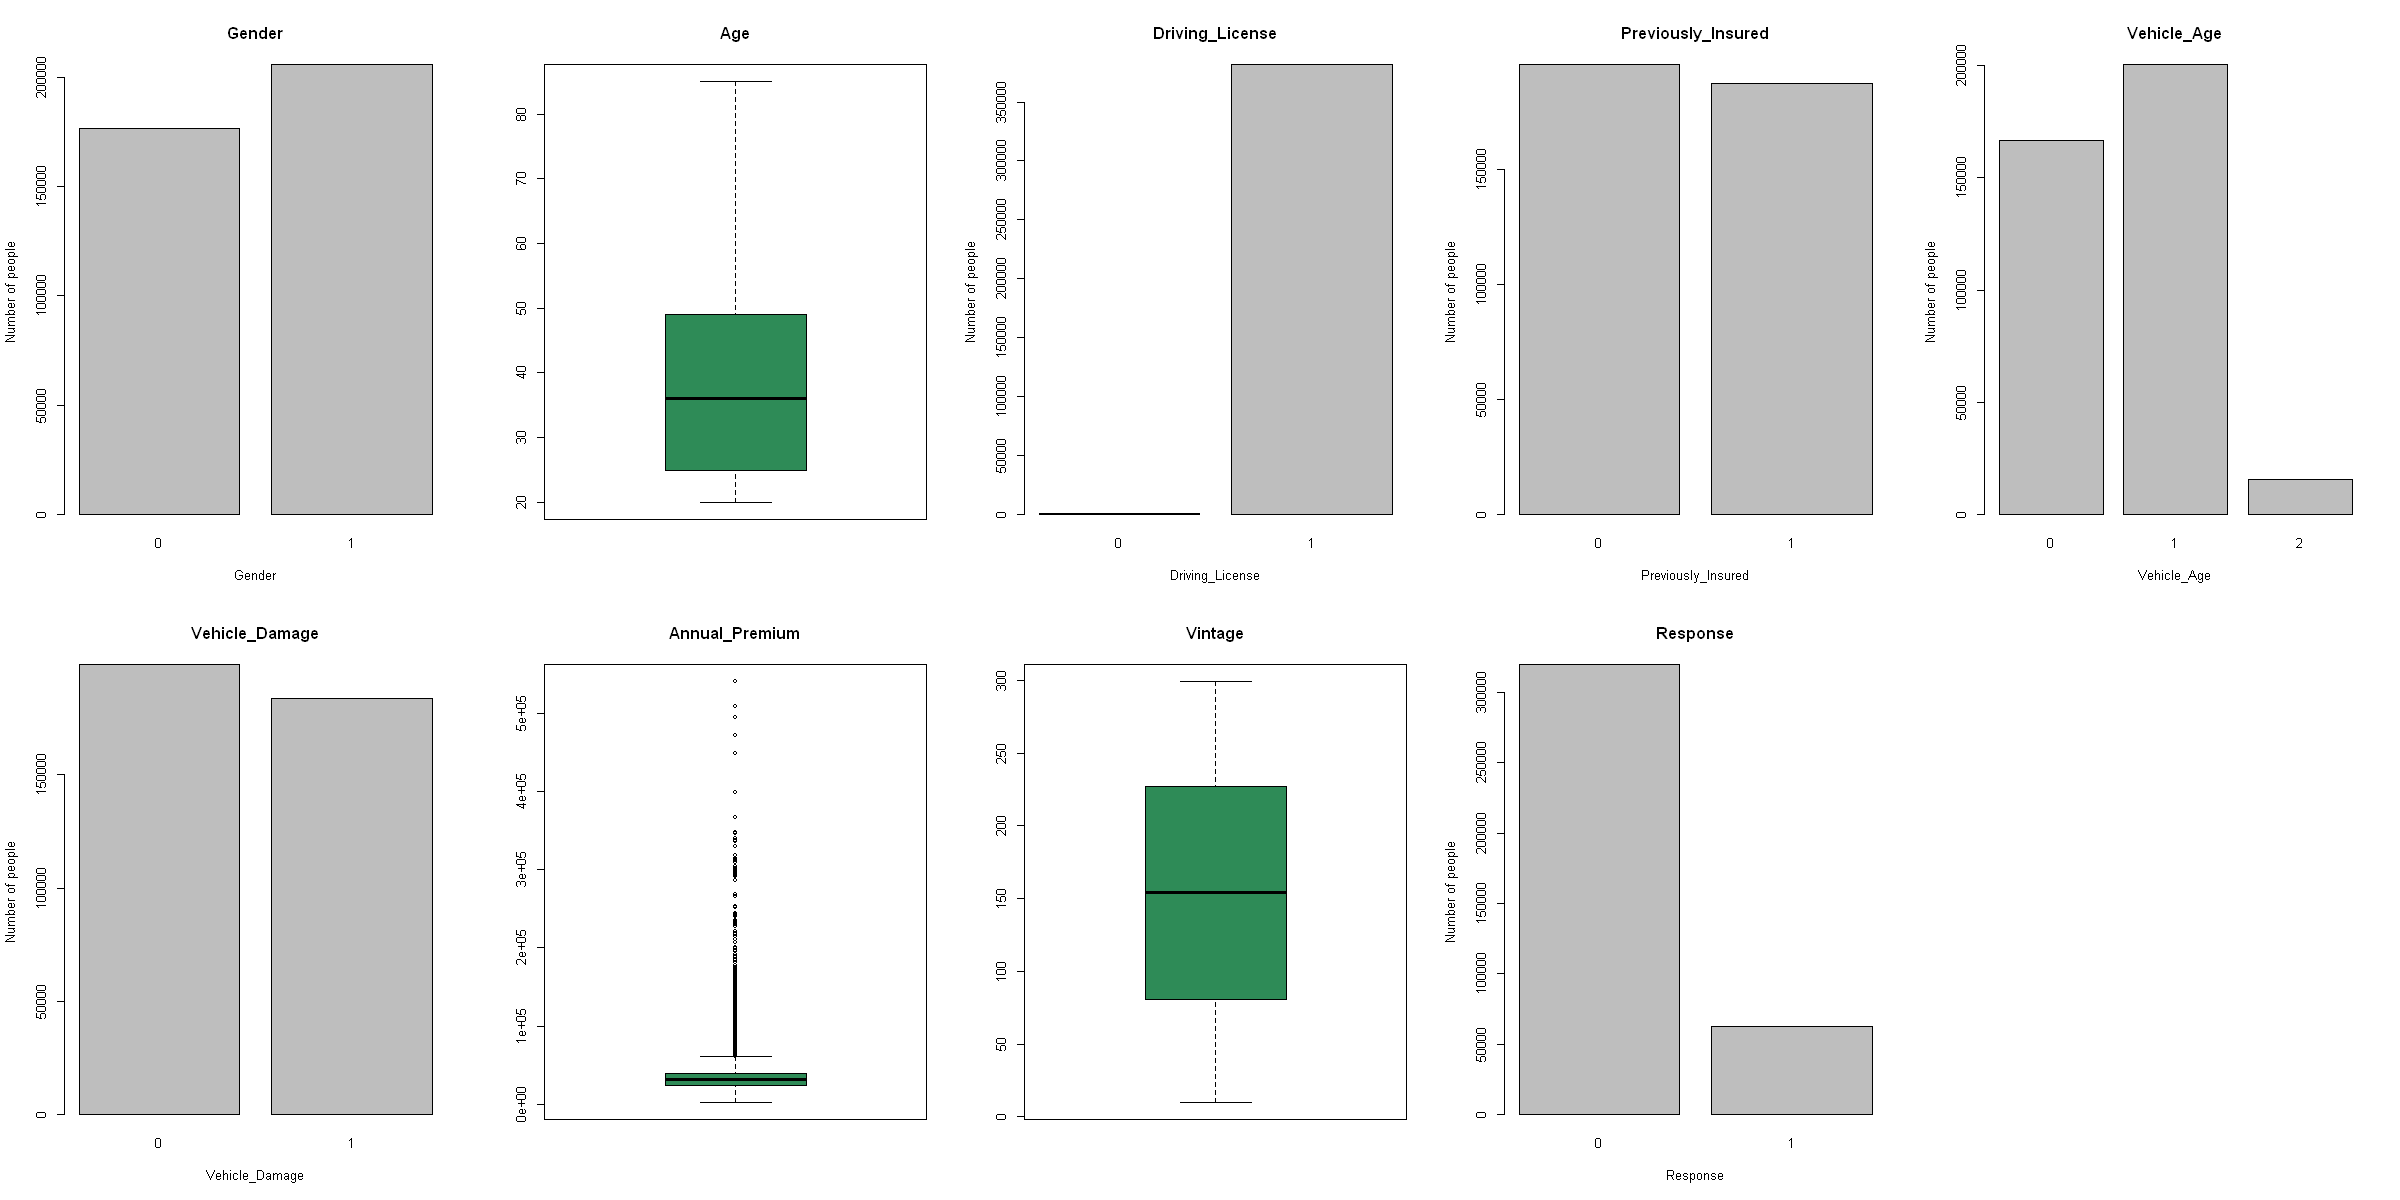

In [10]:
options(repr.plot.width=20,repr.plot.height=10)
par(mfrow=c(2,5))
for (i in 1:ncol(data)) {
    if (i %in% Num.vars){
        boxplot(data[,i],col="seagreen",main=colnames(data)[i])
    } else {
        barplot(table(data[,i]), ylab="Number of people", xlab=colnames(data)[i], main=colnames(data)[i])
    }
}

And now, the possible correlation that might occurr betwen this variables. We only study this among the numerical variables (those with more than 3 unique levels), excluding categorical variables. As manny of our variables are categorical, this analysis is not very insightful. Let's plot this correlation just in case:



In [11]:
round(cor(data[,Num.vars]),2)

,Age,Annual_Premium,Vintage
Age,1.00,0.07,0
Annual_Premium,0.07,1.00,0
Vintage,0.00,0.00,1


In [12]:
# #Lasts 1 min 48 secs
# options(repr.plot.width=10,repr.plot.height=10)
# pairs(data[,Num.vars],col="seagreen")

Do we have to deal with null values in the dataset? No.

In [13]:
sum(is.na(data))
sum(is.na(test))

[1] 0

[1] 0

A common practice in Machine Learning is perform feature scaling, which helps most models to converge more quickly towards the minima. We can achieve this with the function ``scale``, which centers the variable to 0 mean and unit variance. We will scale all the numerical variables, except for the target variable (``Response``).

In [14]:
data[,Num.vars] <-  as.data.frame(scale(data[,Num.vars]))
test[,Num.vars] <-  as.data.frame(scale(test[,Num.vars]))
data[1:5,]

Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
1,-1.0866095,1,1,0,0,-1.64587604,-1.6503165,0
1,0.2268557,1,0,1,1,0.73942256,-0.2291683,0
0,1.8030141,1,0,1,1,0.30065937,1.1800376,0
0,-1.0866095,1,0,0,0,-0.17971774,-1.0173681,0
1,-0.6925699,1,1,0,0,-0.09895155,0.6784558,0


Let's look at this class imbalance we've been told:

In [15]:
print("Cases:")
table(data$Response)
print("Proportion:")
round(table(data$Response)/nrow(data)*100,2)

[1] "Cases:"



     0      1 
319553  62601 

[1] "Proportion:"



    0     1 
83.62 16.38 

Huge! Our first approach to deal with this problem is resampling with the function ``resample`` that we have below. It takes as parameter the amount of samples we want from each class and returns the filtered dataframe. With this approach, we balance the dataset, because we get the same number of samples from the positive than from the negative class.

We have selected this simple approach, and not more sofisticated methods such as SMOTE for the following reason: SMOTE deals with the class imbalance by oversampling the minority class, doing data augmentation in a very smart manner. However, in our case, we have more samples than those we can process, and we need to reduce the training dataset. For this reason, we think that it is sufficient in our case to do undersampling. When undersampling, we can select the same numbers of samples from both classes and, so, the class imbalance is solved. 

In [16]:
resample <- function(data,size) {
    total = size * 2
    if (total > nrow(data)) {
        cat("Not enough data to create a dataframe of size ",total)
        return(data)
    } else if (size > 62601) {
        print("Not enough samples!")
        return(data)
    }
    negative <- sample(x=which(data$Response == 0), size=size, replace=FALSE)
    positive <- sample(x=which(data$Response == 1), size=size, replace=FALSE)
    resampled_idx <- c(negative, positive)
    return(data[resampled_idx, ])
}

## JAGS

In [17]:
df <- resample(data,700)
dim(df)
table(df$Response)

[1] 1400    9


  0   1 
700 700 

In [18]:
dfCombined <- as.list(df[, c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')])
dfCombined$nrows <- nrow(df)

In [282]:
mod.jags <- paste(" 
model {
for (i in 1:nrows){
  Response[i] ~ dbern(p[i])  
  logit(p[i]) <- mu[i]   
  mu[i] <- b[9] + b[2] * Gender[i] + b[3] * Age[i] + b[4] * Driving_License[i] + b[5] * Previously_Insured[i] + 
        b[6] * Vehicle_Age[i] + b[7] * Vehicle_Damage[i] + b[8] * Vintage[i] + b[1] * Annual_Premium[i]
  }

for(j in 1:9){
  b[j] ~ dnorm(0, 0.1)
  }

}
")
writeLines(mod.jags, "mod.jags")    

In [283]:
params.jags <- c("b")
inits1.jags <- list("b" = rep(0, 9))
inits.jags <- list(inits1.jags,inits1.jags,inits1.jags,inits1.jags)

In [284]:
library("R2jags")
set.seed(123)

jags_model <- jags(data = dfCombined, inits = inits.jags, 
  parameters.to.save = params.jags, n.chains = 4, n.iter = 2000, 
  n.burnin = 1000, model.file = "mod.jags")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1400
   Unobserved stochastic nodes: 9
   Total graph size: 16895

Initializing model



In [285]:
jags_model

Inference for Bugs model at "mod.jags", fit using jags,
 4 chains, each with 2000 iterations (first 1000 discarded)
 n.sims = 4000 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
b[1]        0.221   0.076    0.075    0.169    0.220    0.273    0.369 1.001
b[2]        0.162   0.150   -0.129    0.060    0.159    0.262    0.452 1.004
b[3]       -0.364   0.108   -0.573   -0.438   -0.363   -0.289   -0.155 1.003
b[4]       -0.109   1.812   -3.483   -1.361   -0.177    1.071    3.519 1.001
b[5]       -5.513   1.270   -8.457   -6.188   -5.388   -4.661   -3.356 1.251
b[6]        1.089   0.204    0.689    0.952    1.087    1.225    1.492 1.002
b[7]        2.259   0.378    1.562    1.999    2.245    2.505    3.046 1.005
b[8]       -0.040   0.077   -0.190   -0.093   -0.039    0.011    0.115 1.001
b[9]       -2.065   1.799   -5.832   -3.238   -1.992   -0.819    1.270 1.001
deviance 1083.961   7.156 1077.201 1080.397 1082.888 1086.012 1095.747 1.010
     

### Convergence & Chain analysis

Let's look at this model convergence performance

We notice that the convergence is tatisfactory for most of the model, but we find that for the variable Previously_Insured, the model fails to converge. Perhaps this varaible doesn't have an impact on the final result, so the model struggles to find an optimal value for it.

In [286]:
library("bayesplot")

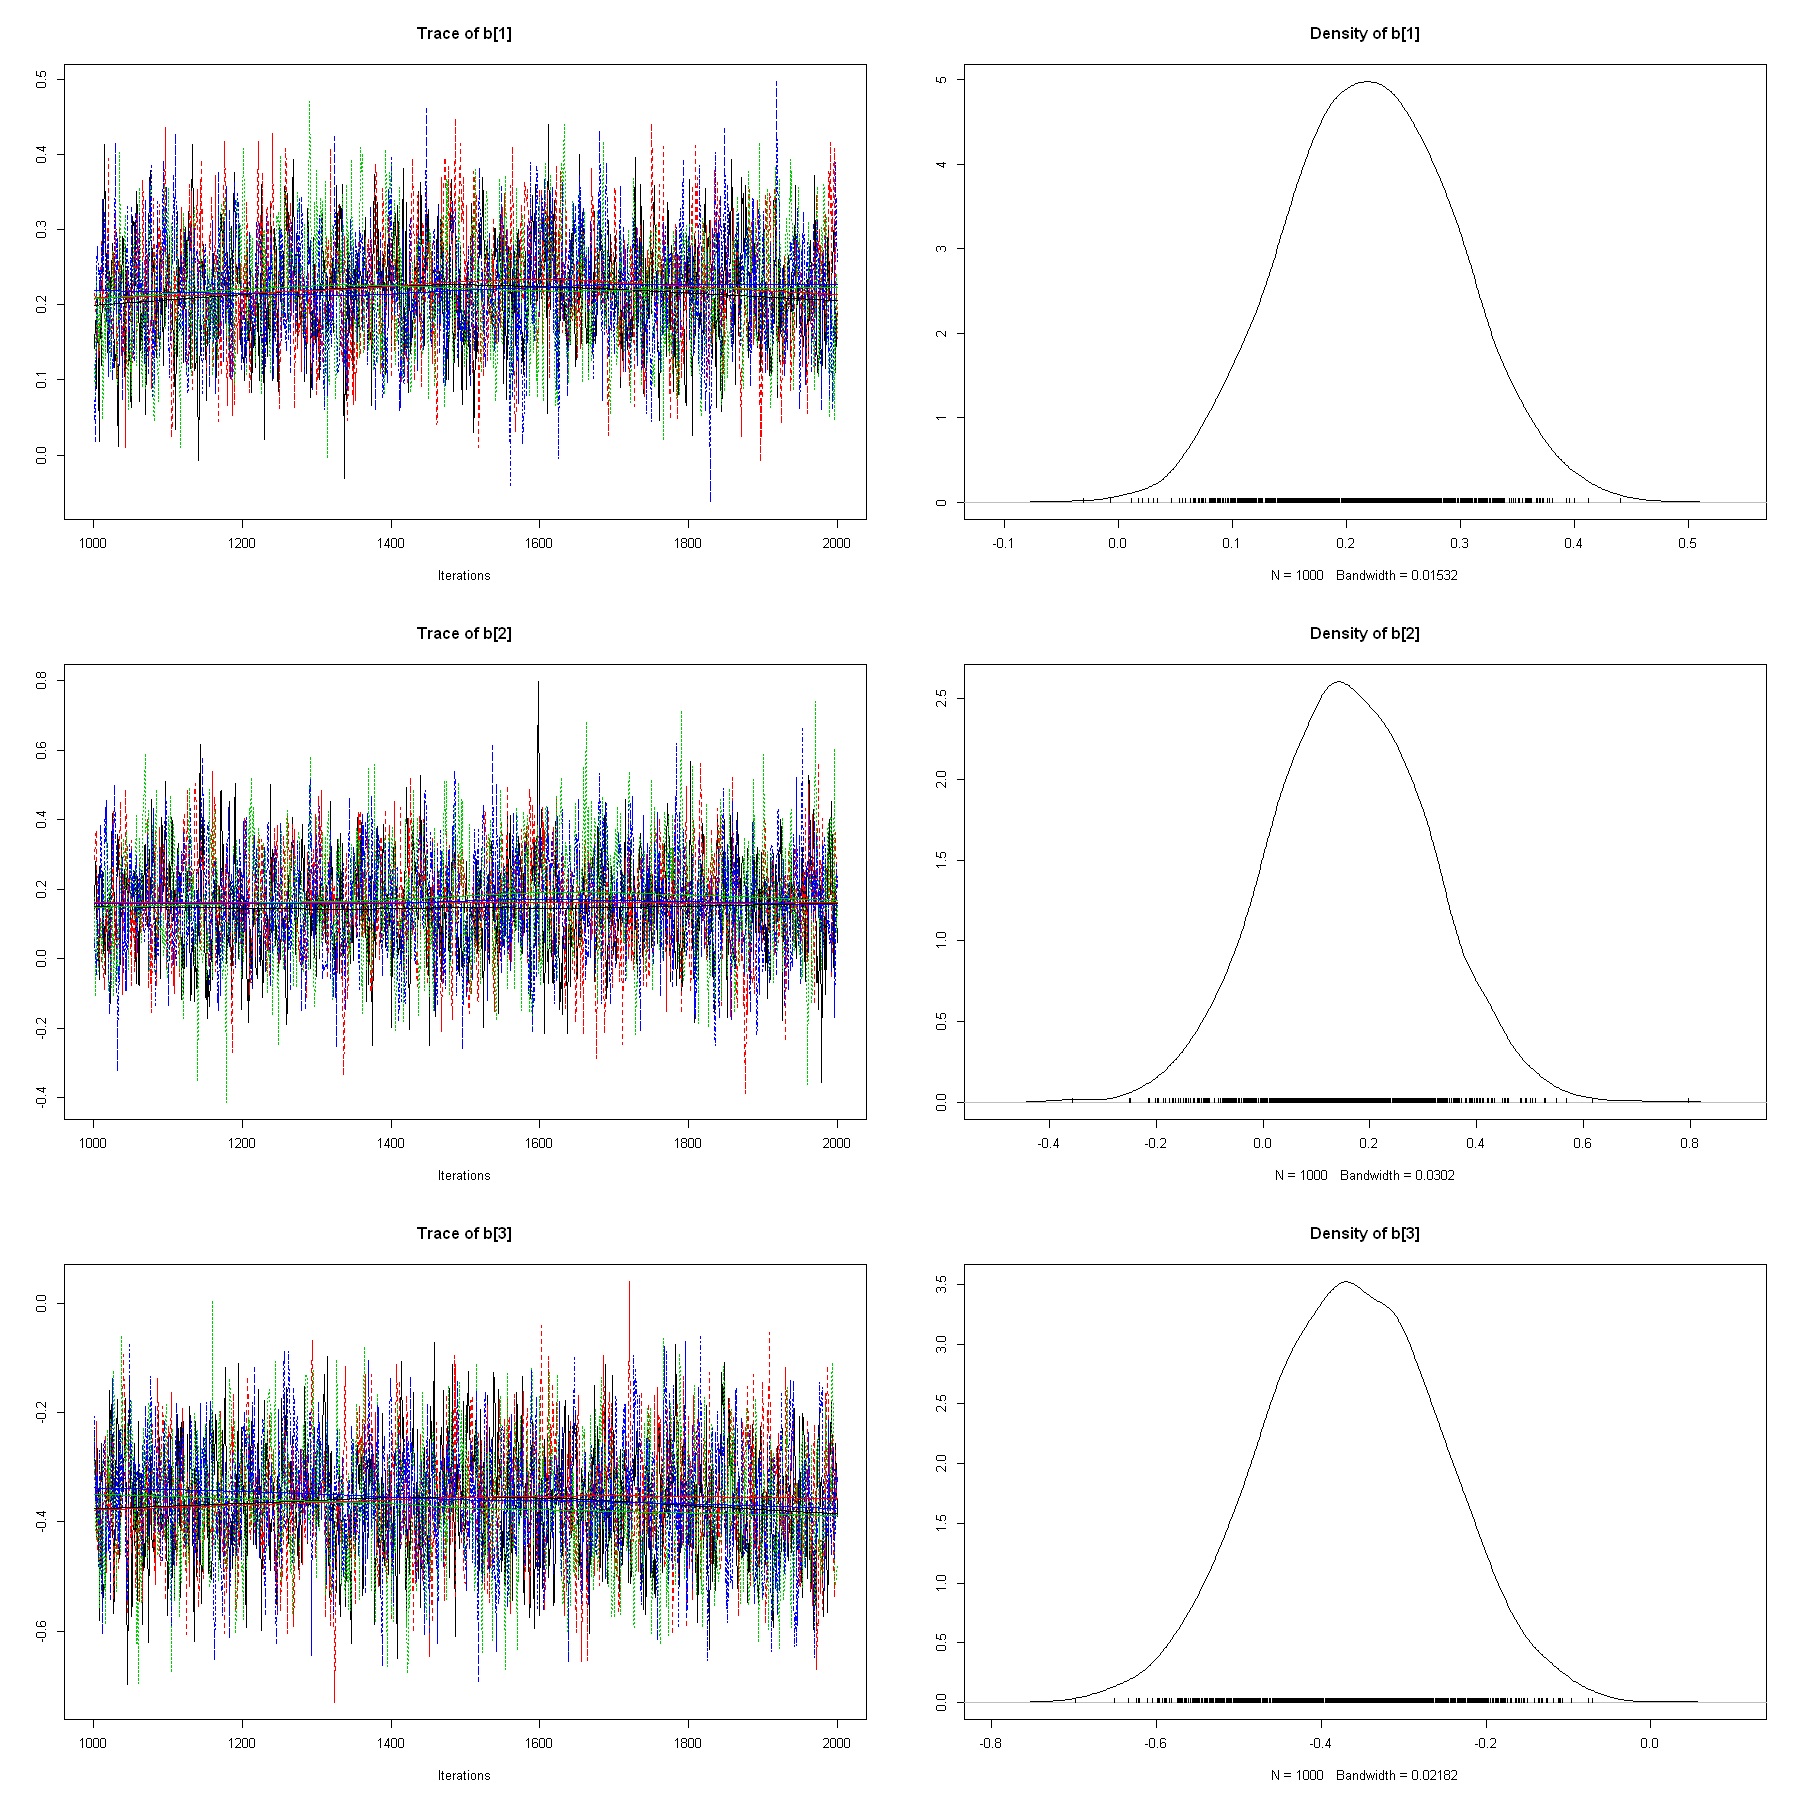

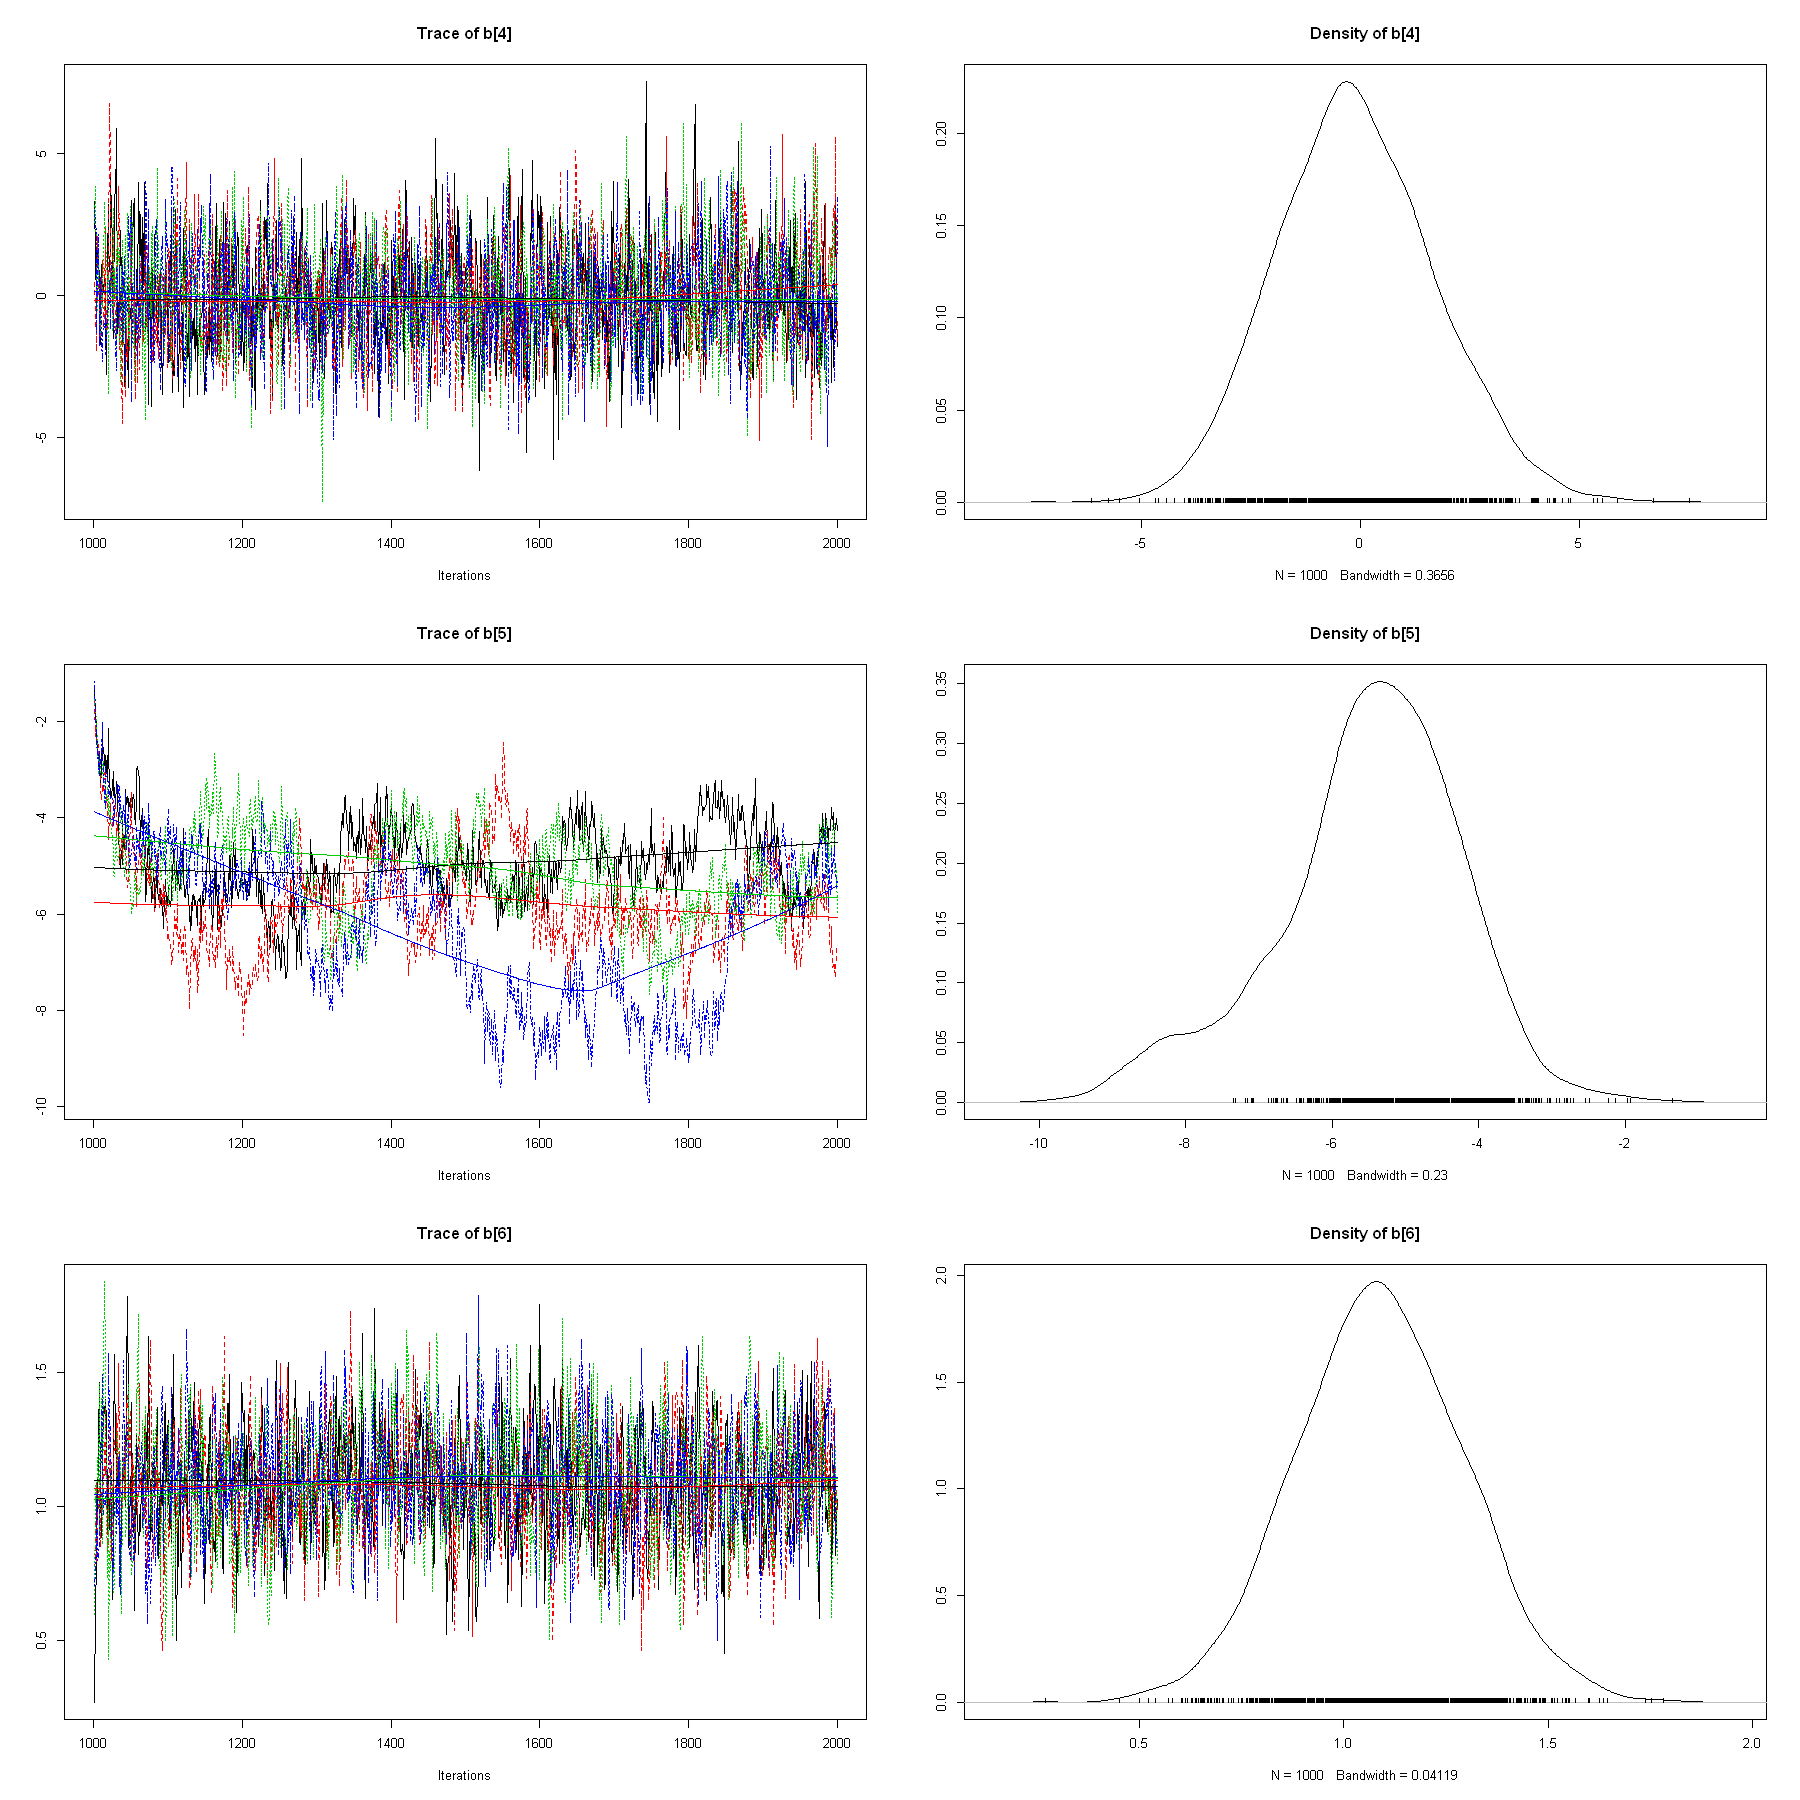

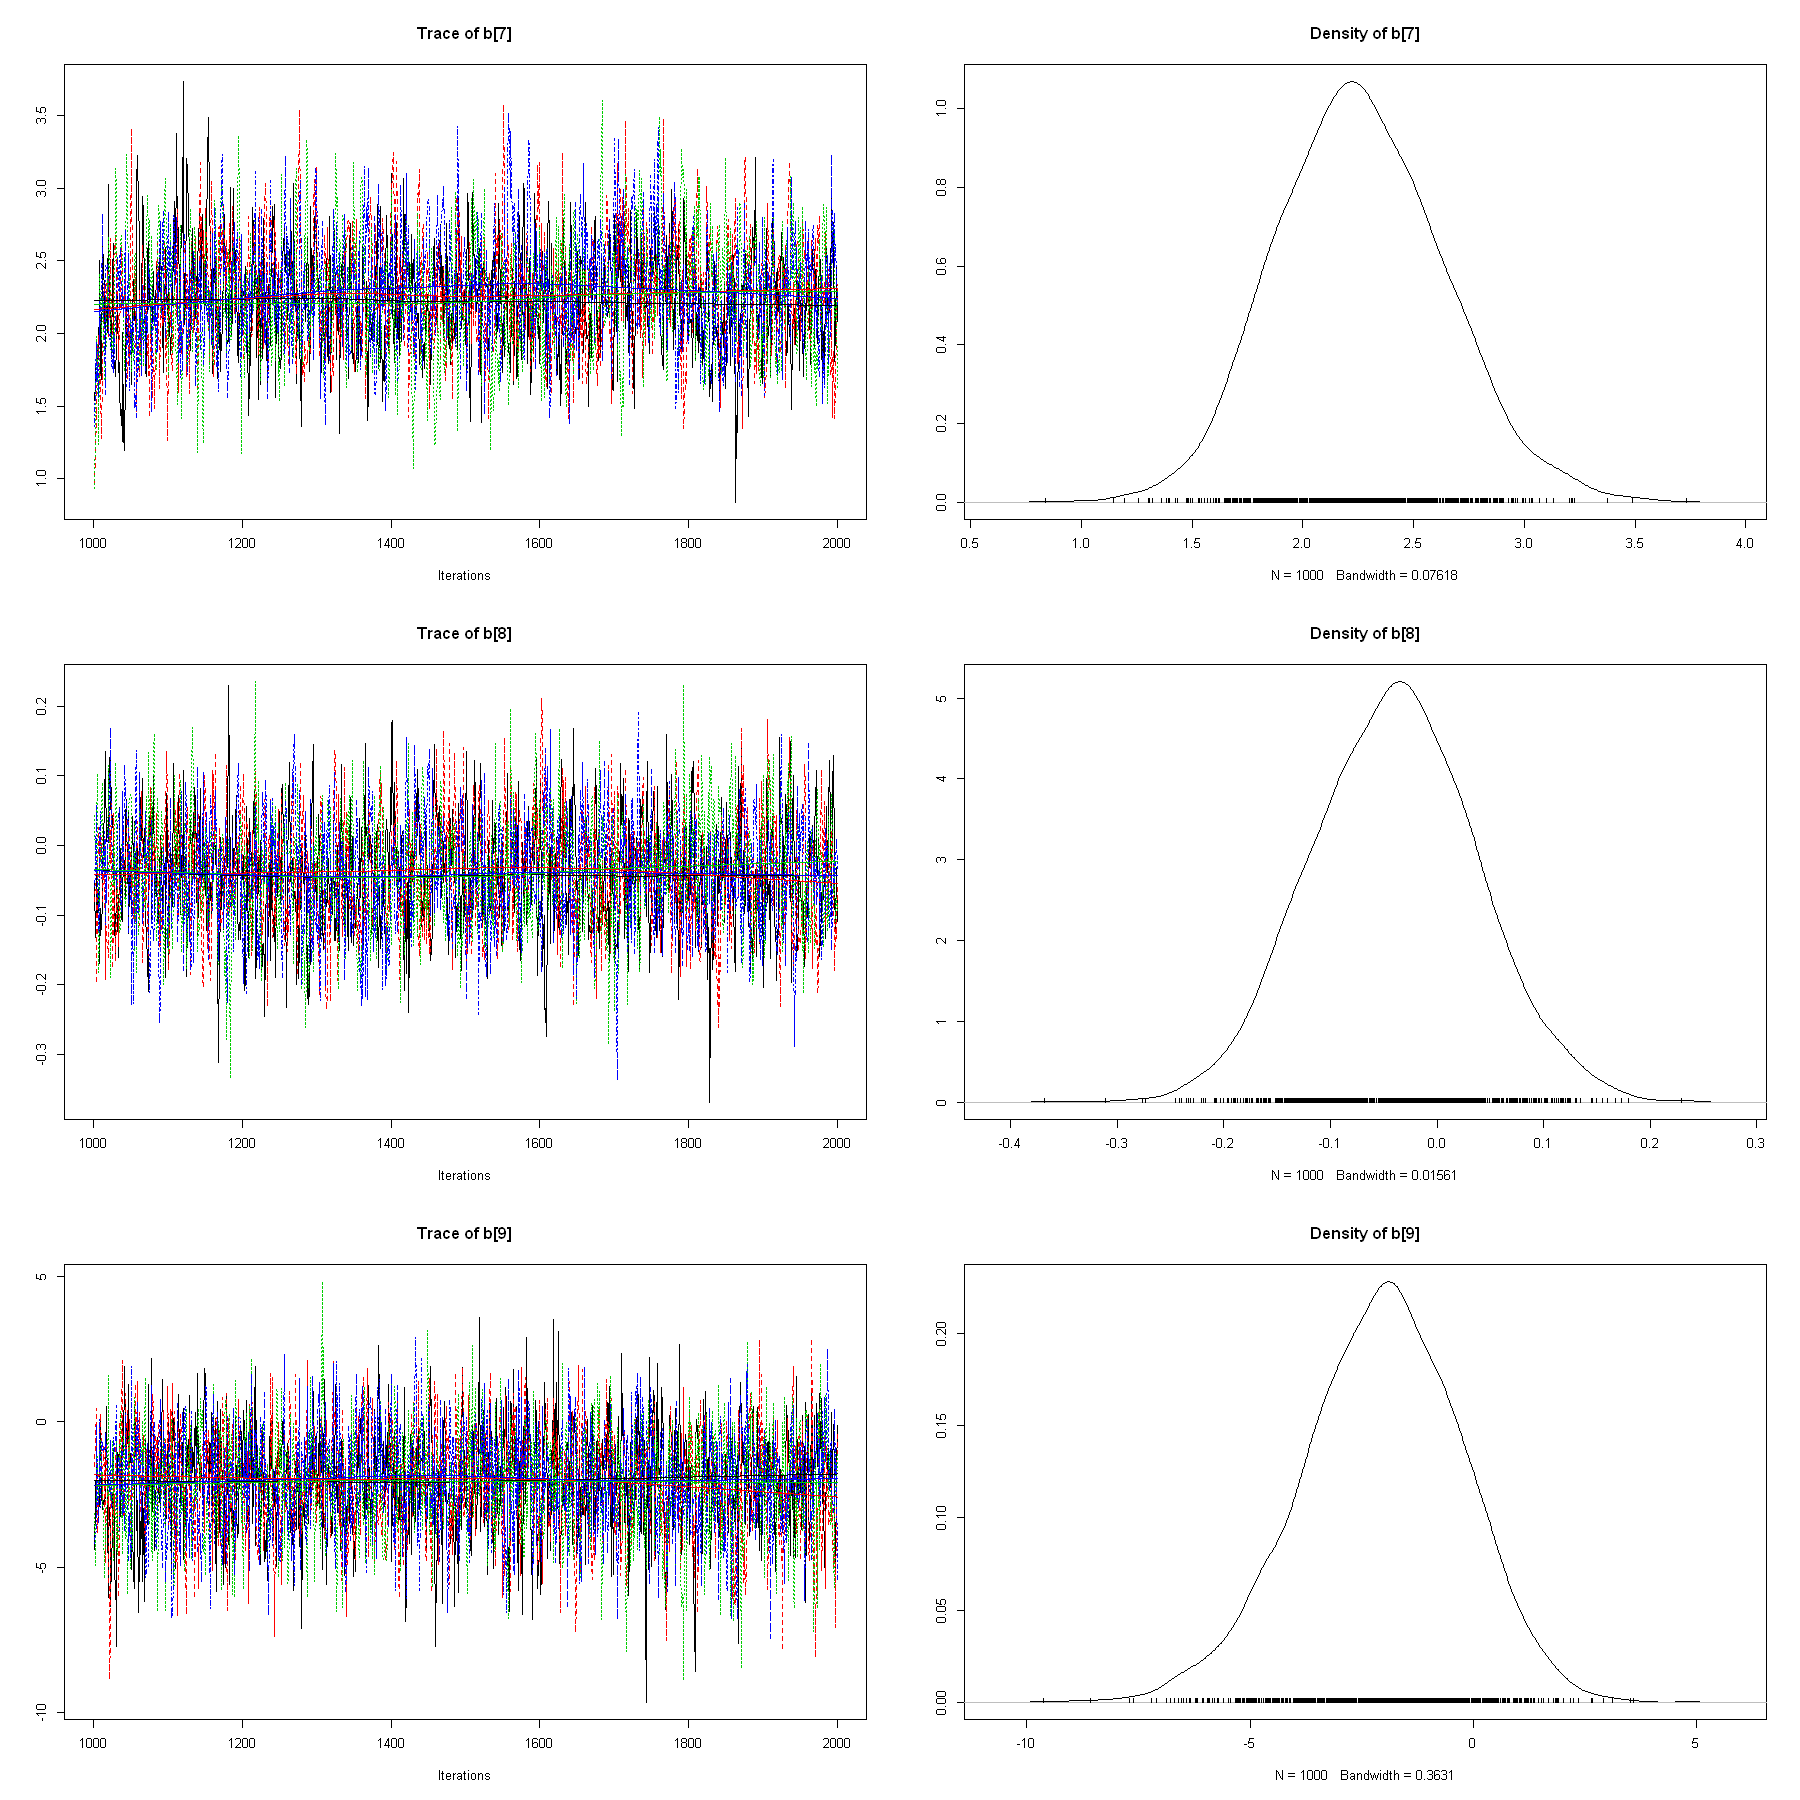

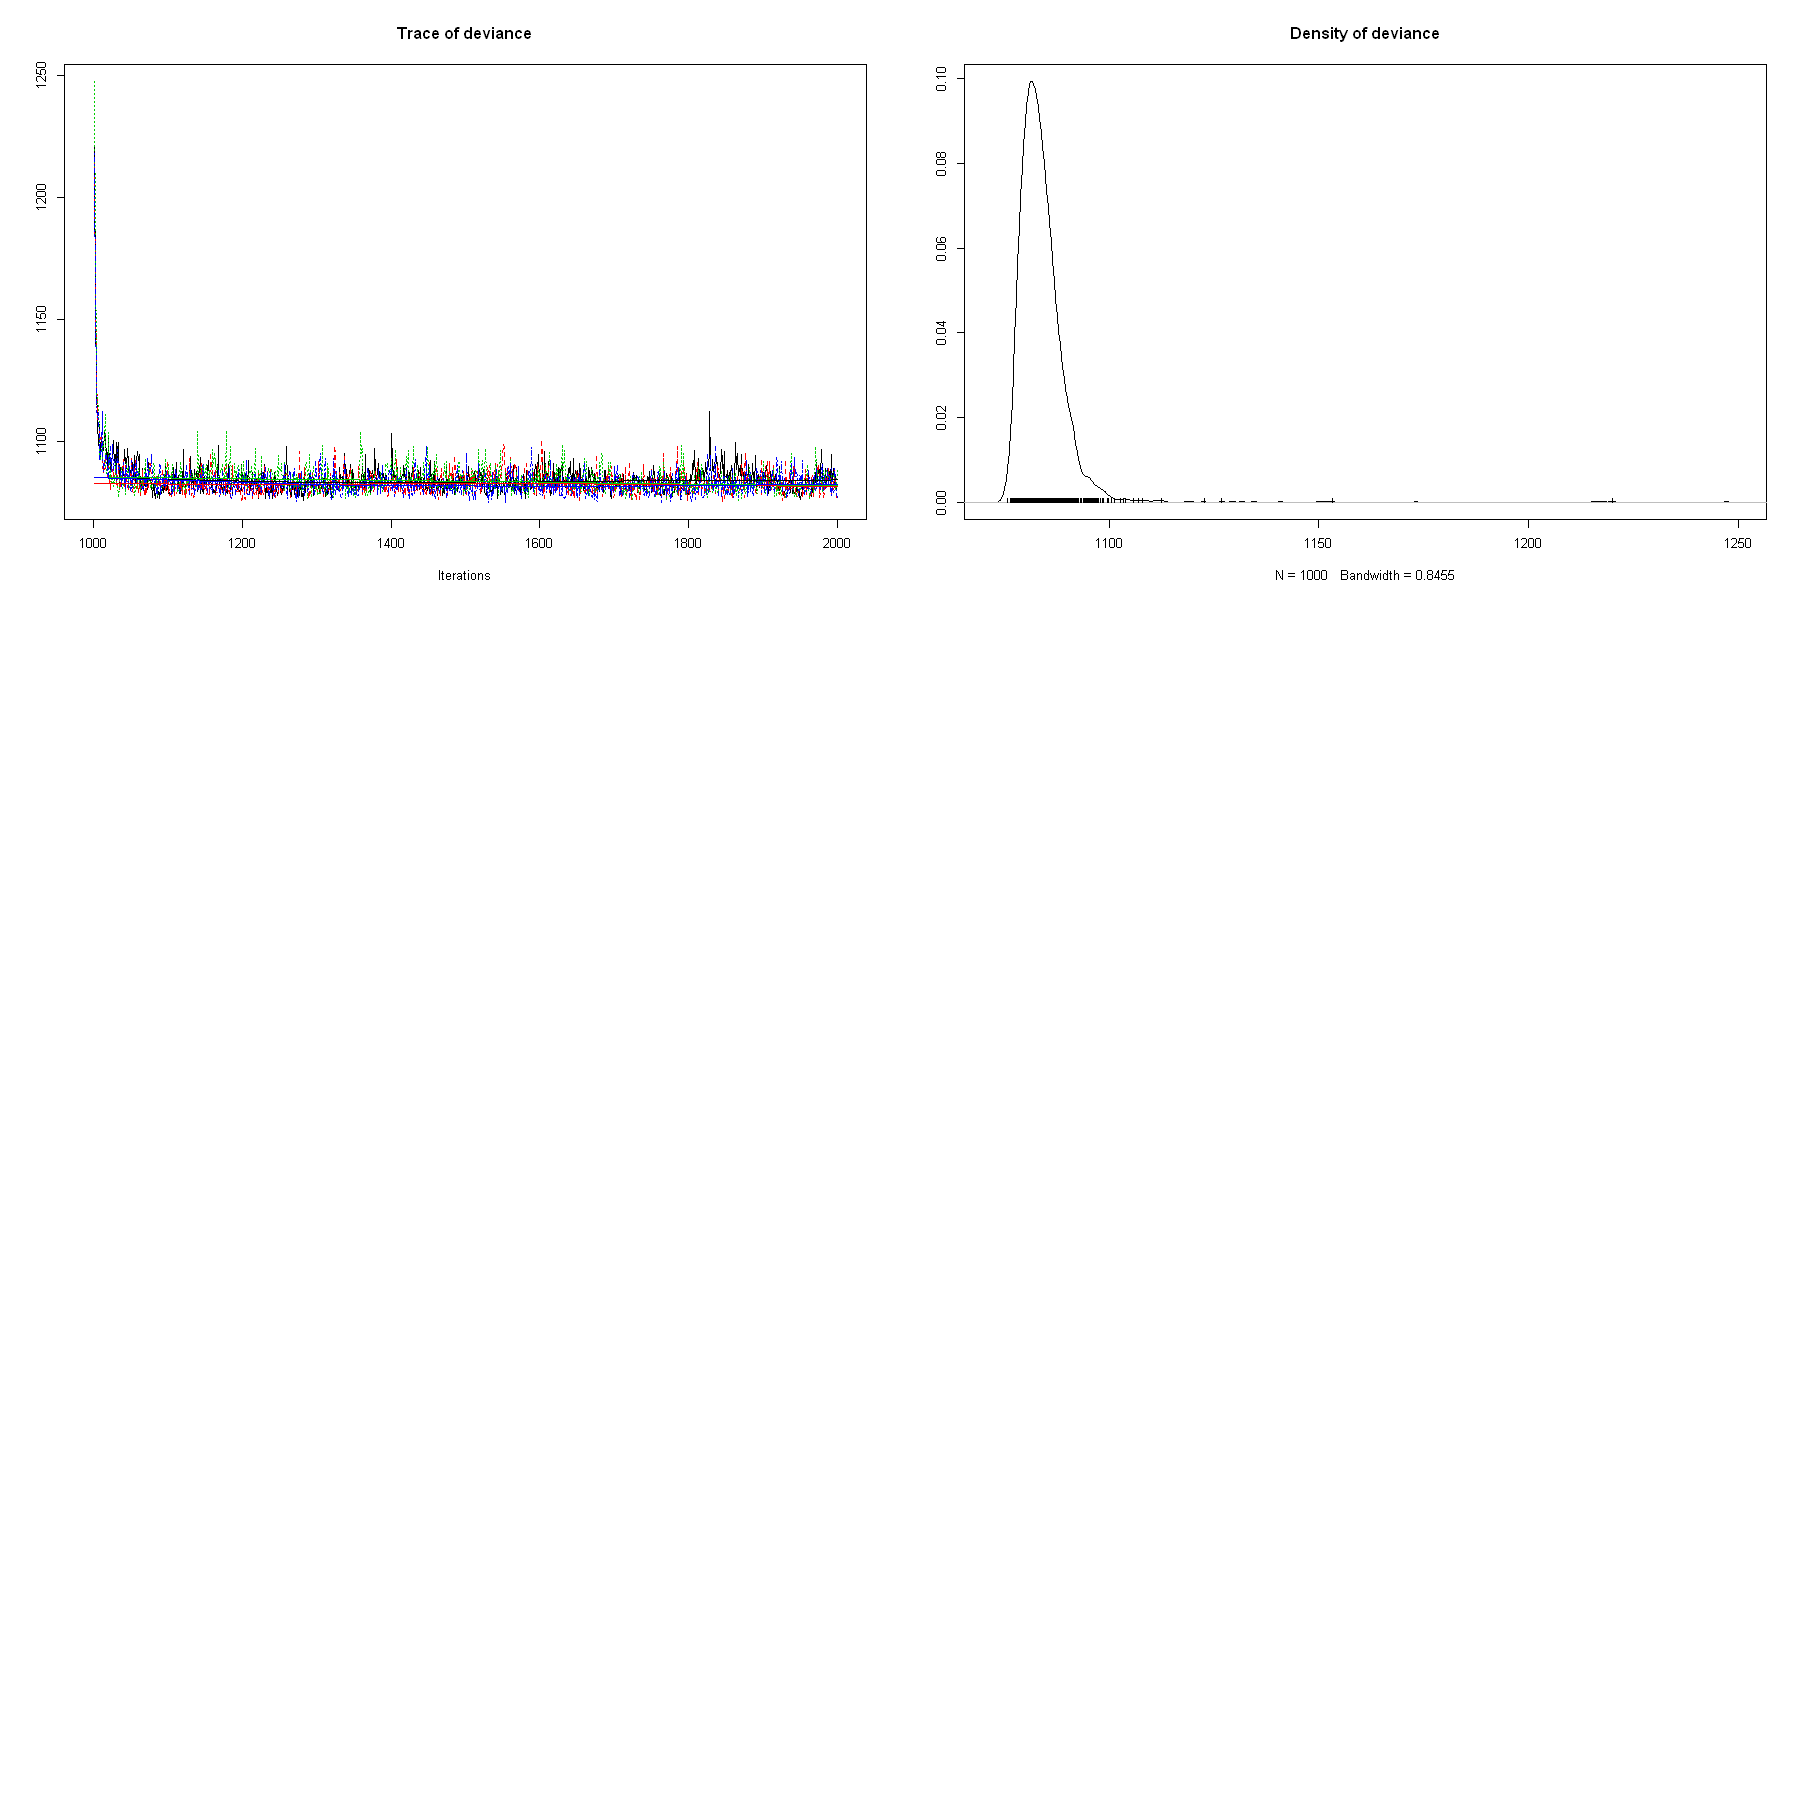

In [287]:
out.mcmc <- as.mcmc(jags_model)
plot(out.mcmc)

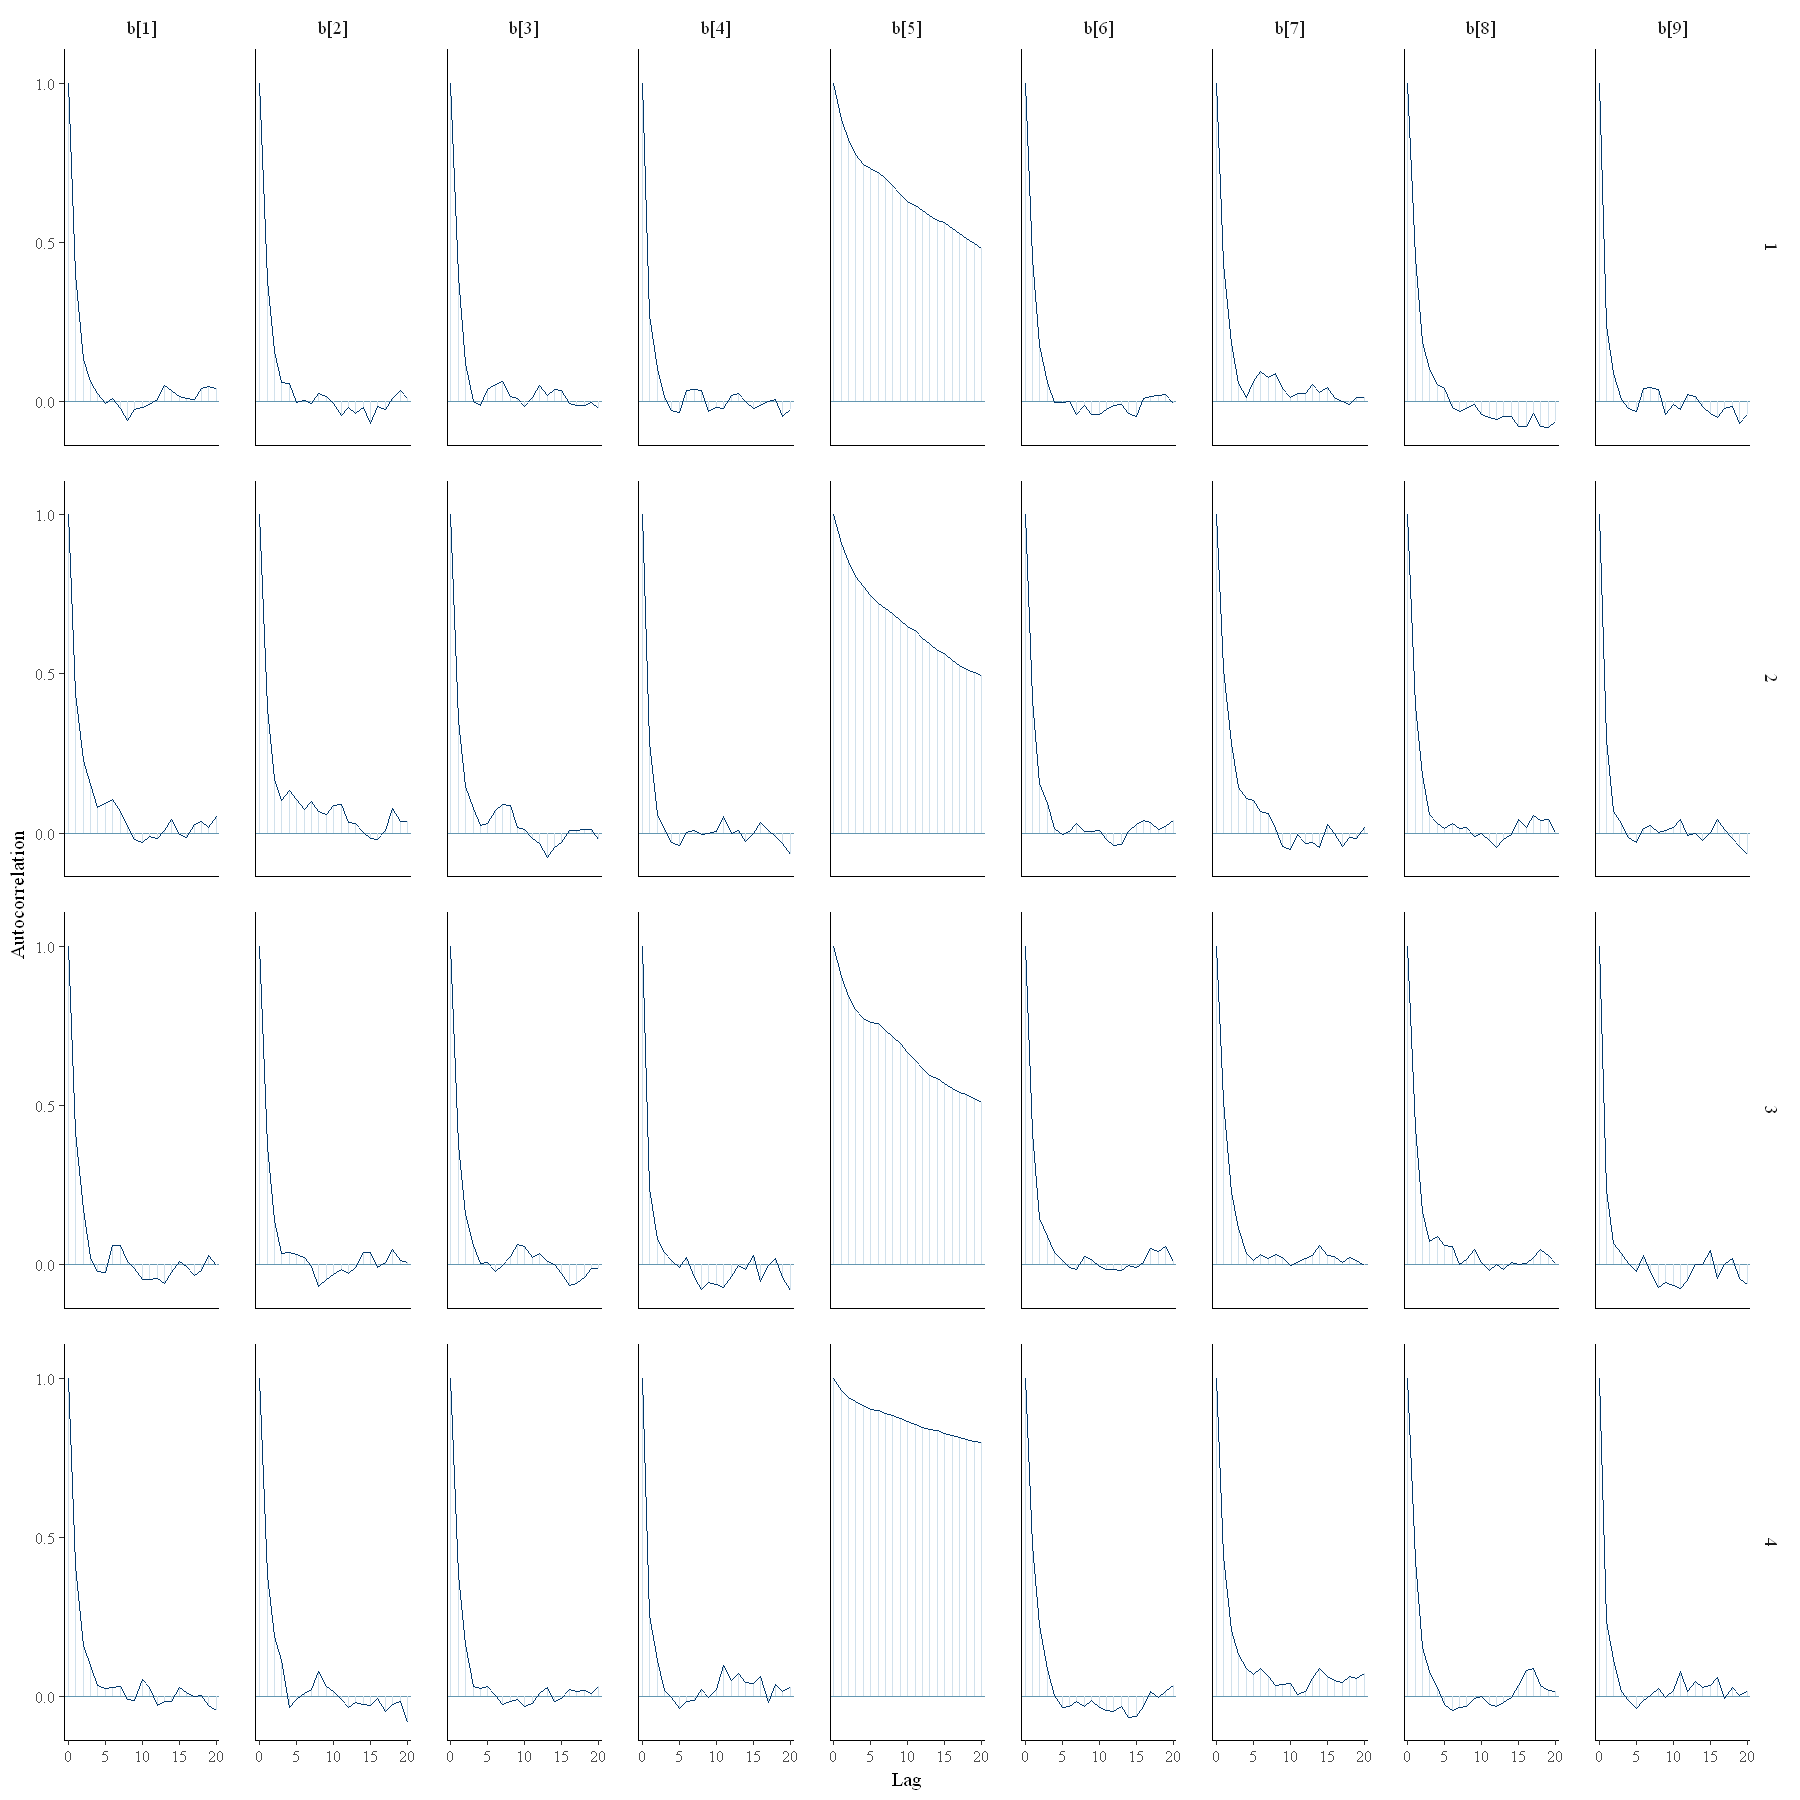

In [288]:
options(repr.plot.width=15,repr.plot.height=15)
mcmc_acf(out.mcmc,pars=vars(contains("b")))

We'll use the package ``BayesPostEst`` to check the performance

In [28]:
#install.packages("BayesPostEst")
library("BayesPostEst")

### Posterior distributions 

Let's summarize the posterior distributions of all parameters, looking at their median, standard deviation and 95% CI:

In [29]:
mcmcTab(jags_model)

Variable,Median,SD,Lower,Upper
b[1],0.220,0.076,0.075,0.369
b[2],0.159,0.150,-0.129,0.452
b[3],-0.363,0.108,-0.573,-0.155
b[4],-0.177,1.812,-3.483,3.519
b[5],-5.388,1.270,-8.457,-3.356
b[6],1.087,0.204,0.689,1.492
b[7],2.245,0.378,1.562,3.046
b[8],-0.039,0.077,-0.190,0.115
b[9],-1.992,1.799,-5.832,1.270
deviance,1082.888,7.156,1077.201,1095.747


### Predicted Probabilities

Meaning the relationships between coviariates and our target variable of interest: Response. Let's start by building a matrix of the posterior coefficients:

In [62]:
matrix_jags <- as.matrix(coda::as.mcmc(jags_model))
mm.jags <- model.matrix(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                         Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage,
                   data = df)

#### First differences

First differences are a method to summarize effects across covariates. This quantity represents the difference in predicted probabilities for each covariate for cases with low and high values of the respective covariate. For each of these differences, all other variables are held constant at their median.

The ``mcmcFD`` function allows to get this table of median and credible intervals of the summary of this first differences.

In [63]:
first_difference.jags <- mcmcFD(modelmatrix = mm.jags,
                  mcmcout = matrix_jags[, 1:ncol(mm.jags)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

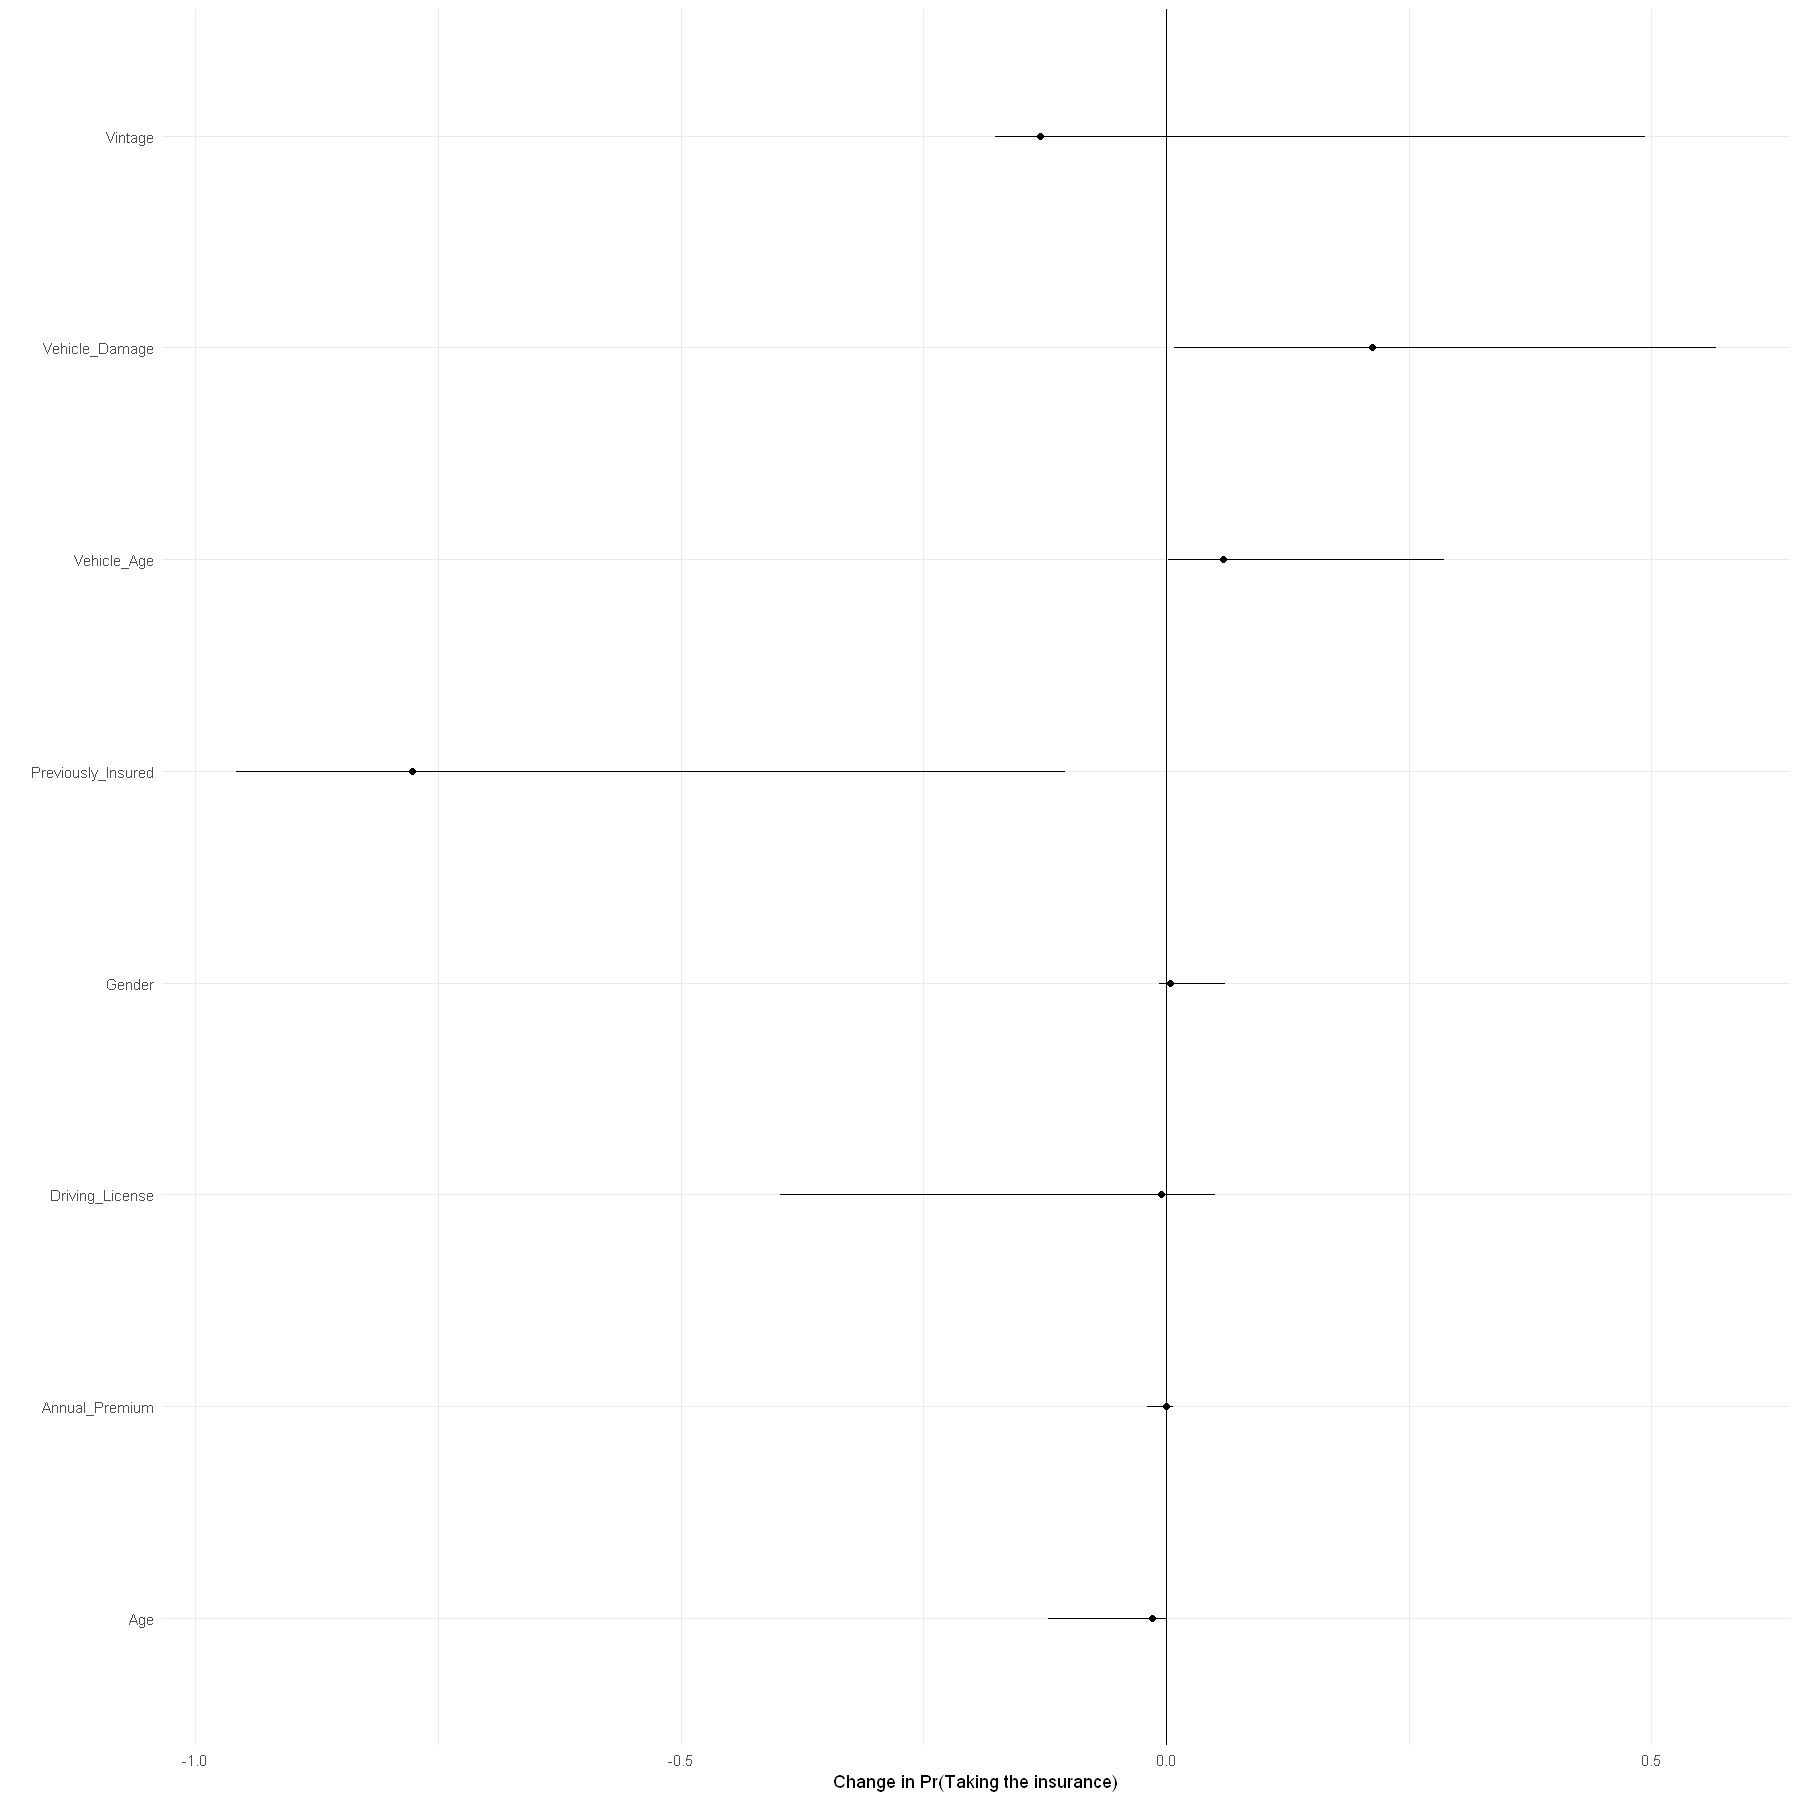

In [64]:
ggplot(data = first_difference.jags, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()

We can see that the variablest that affect the most our target variable of interest Response are Previously_Insured and Vehicle_Damage, with a huge CI. Overall, we cannot extract much information about which variables decide the most our predictions. 

The same plot below but with the posterior distribution shows us the same:

In [65]:
posterior_diff.jags <- mcmcFD(modelmatrix = mm.jags,
                  mcmcout = matrix_jags[, 1:ncol(mm.jags)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = TRUE)

Picking joint bandwidth of 1.25



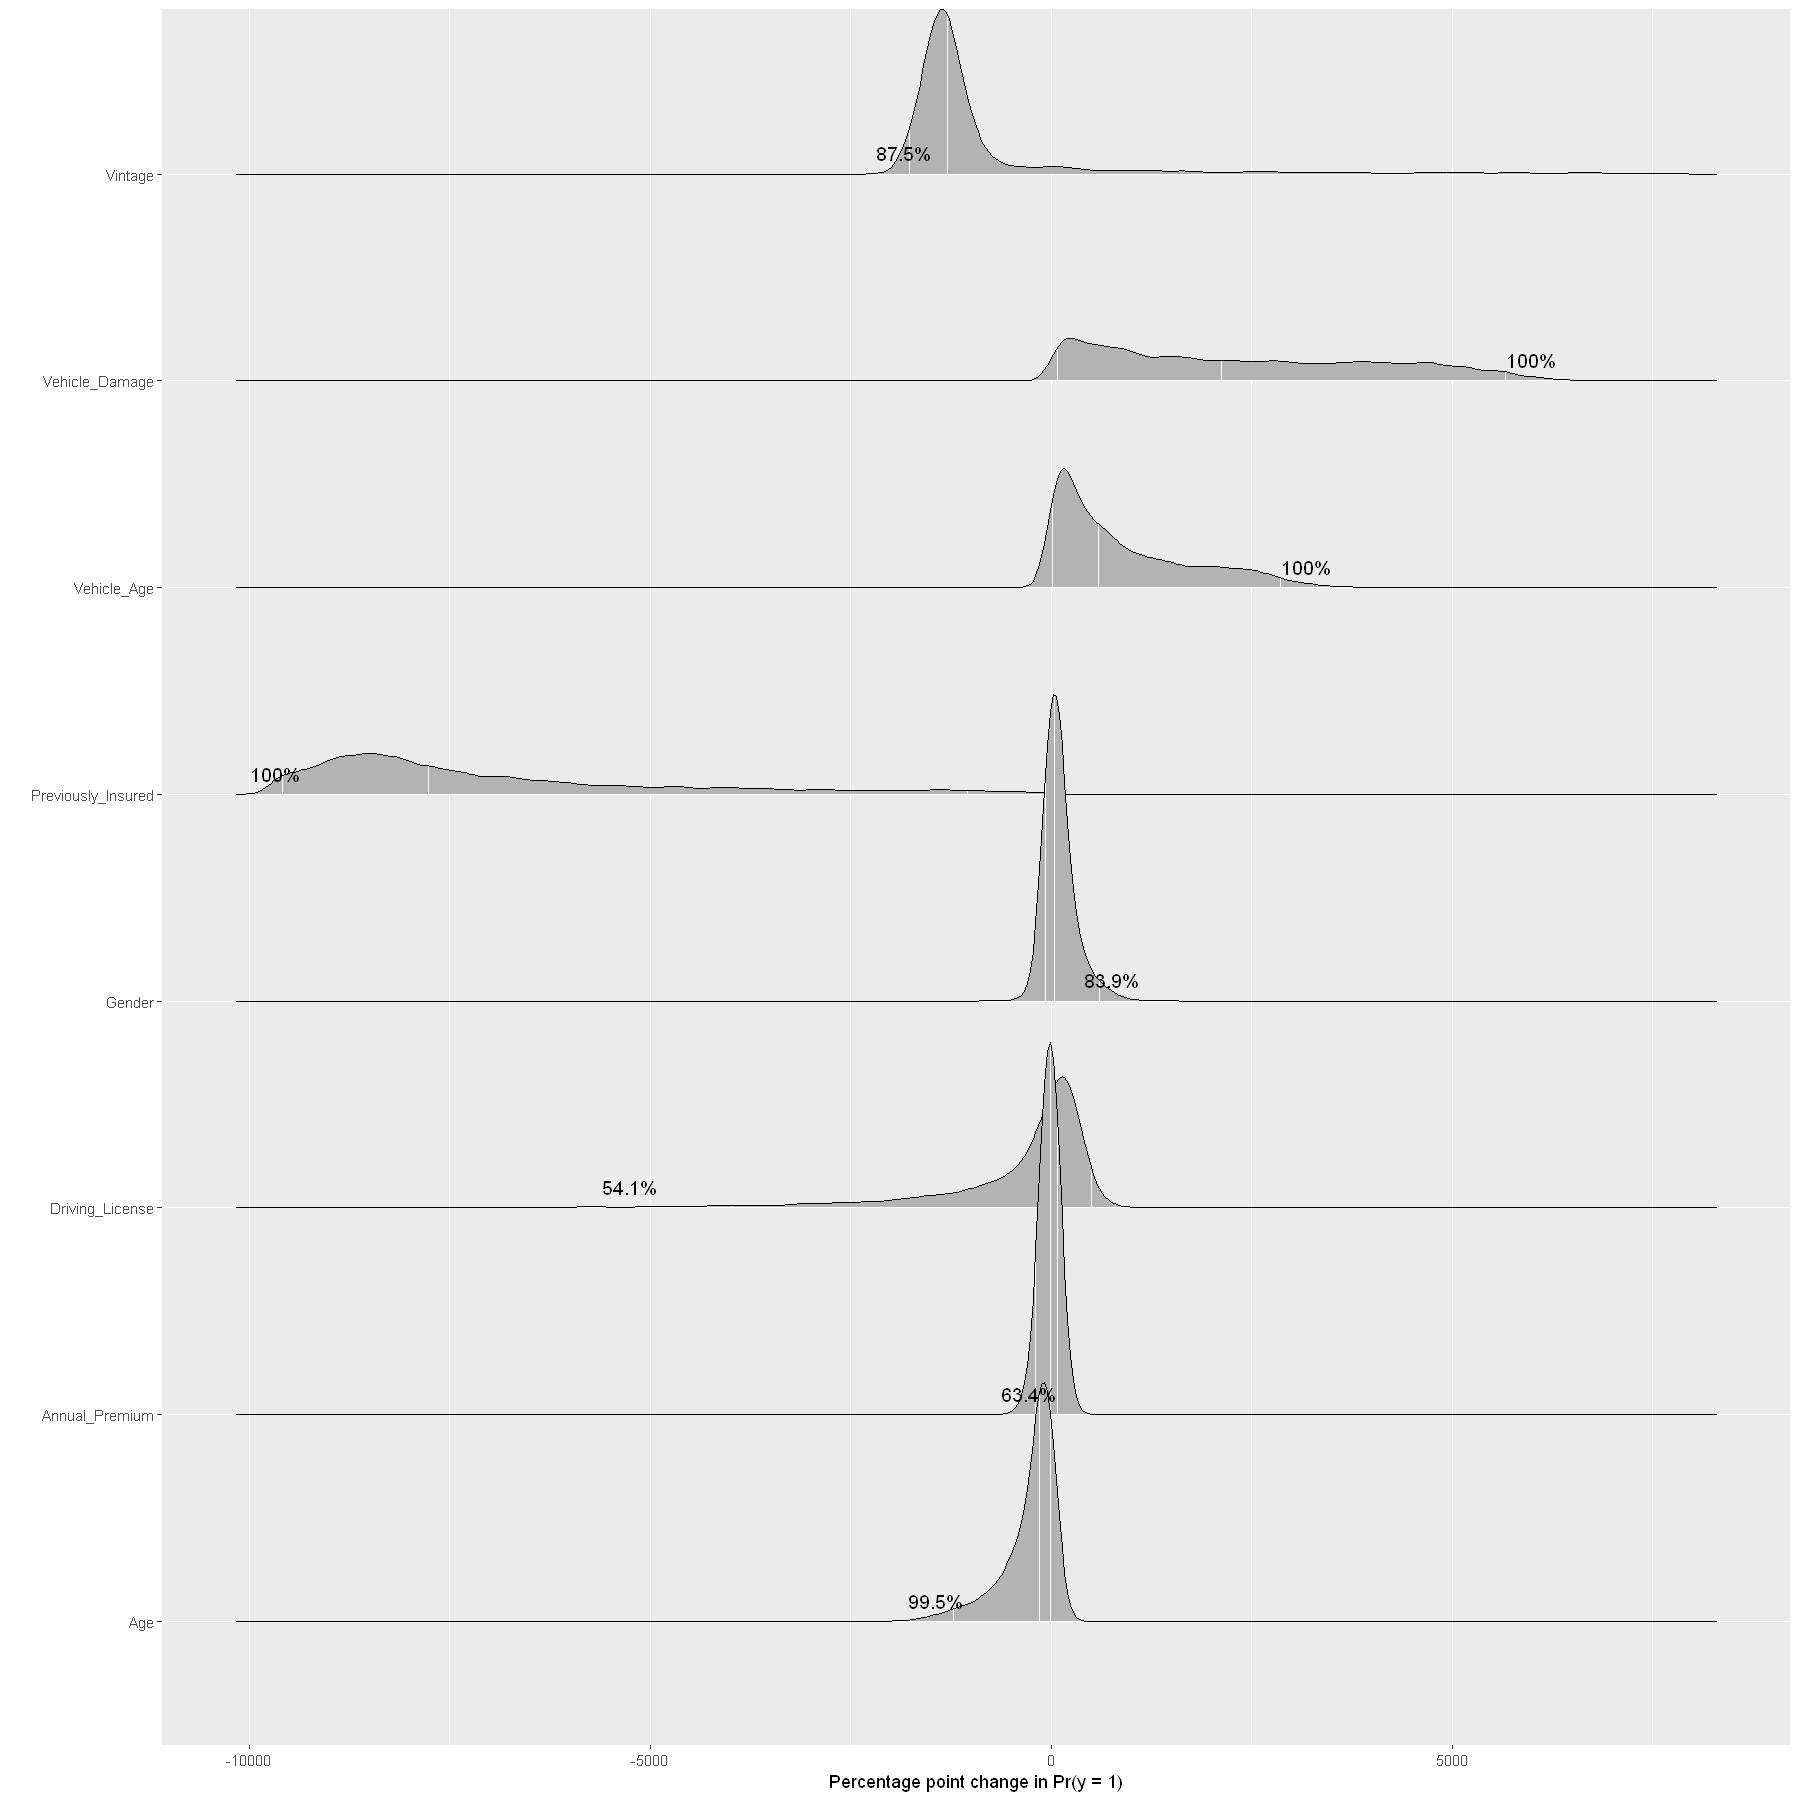

In [66]:
plot(posterior_diff.jags, ROPE = c(-0.01, 0.01))

#### Area Under the ROC Curve

The function ``mcmcRocPrc`` allows us to compute this metric as well as the Area Under the Precision-Recall Curve (PRC):

In [67]:
accuracies.jags <- mcmcRocPrc(object = jags_model,
                       data=dfCombined,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = TRUE,
                       fullsims = FALSE)

In [68]:
accuracies.jags$area_under_roc

V1 
0.8266041

In [69]:
accuracies.jags$area_under_prc

V1 
0.7474185

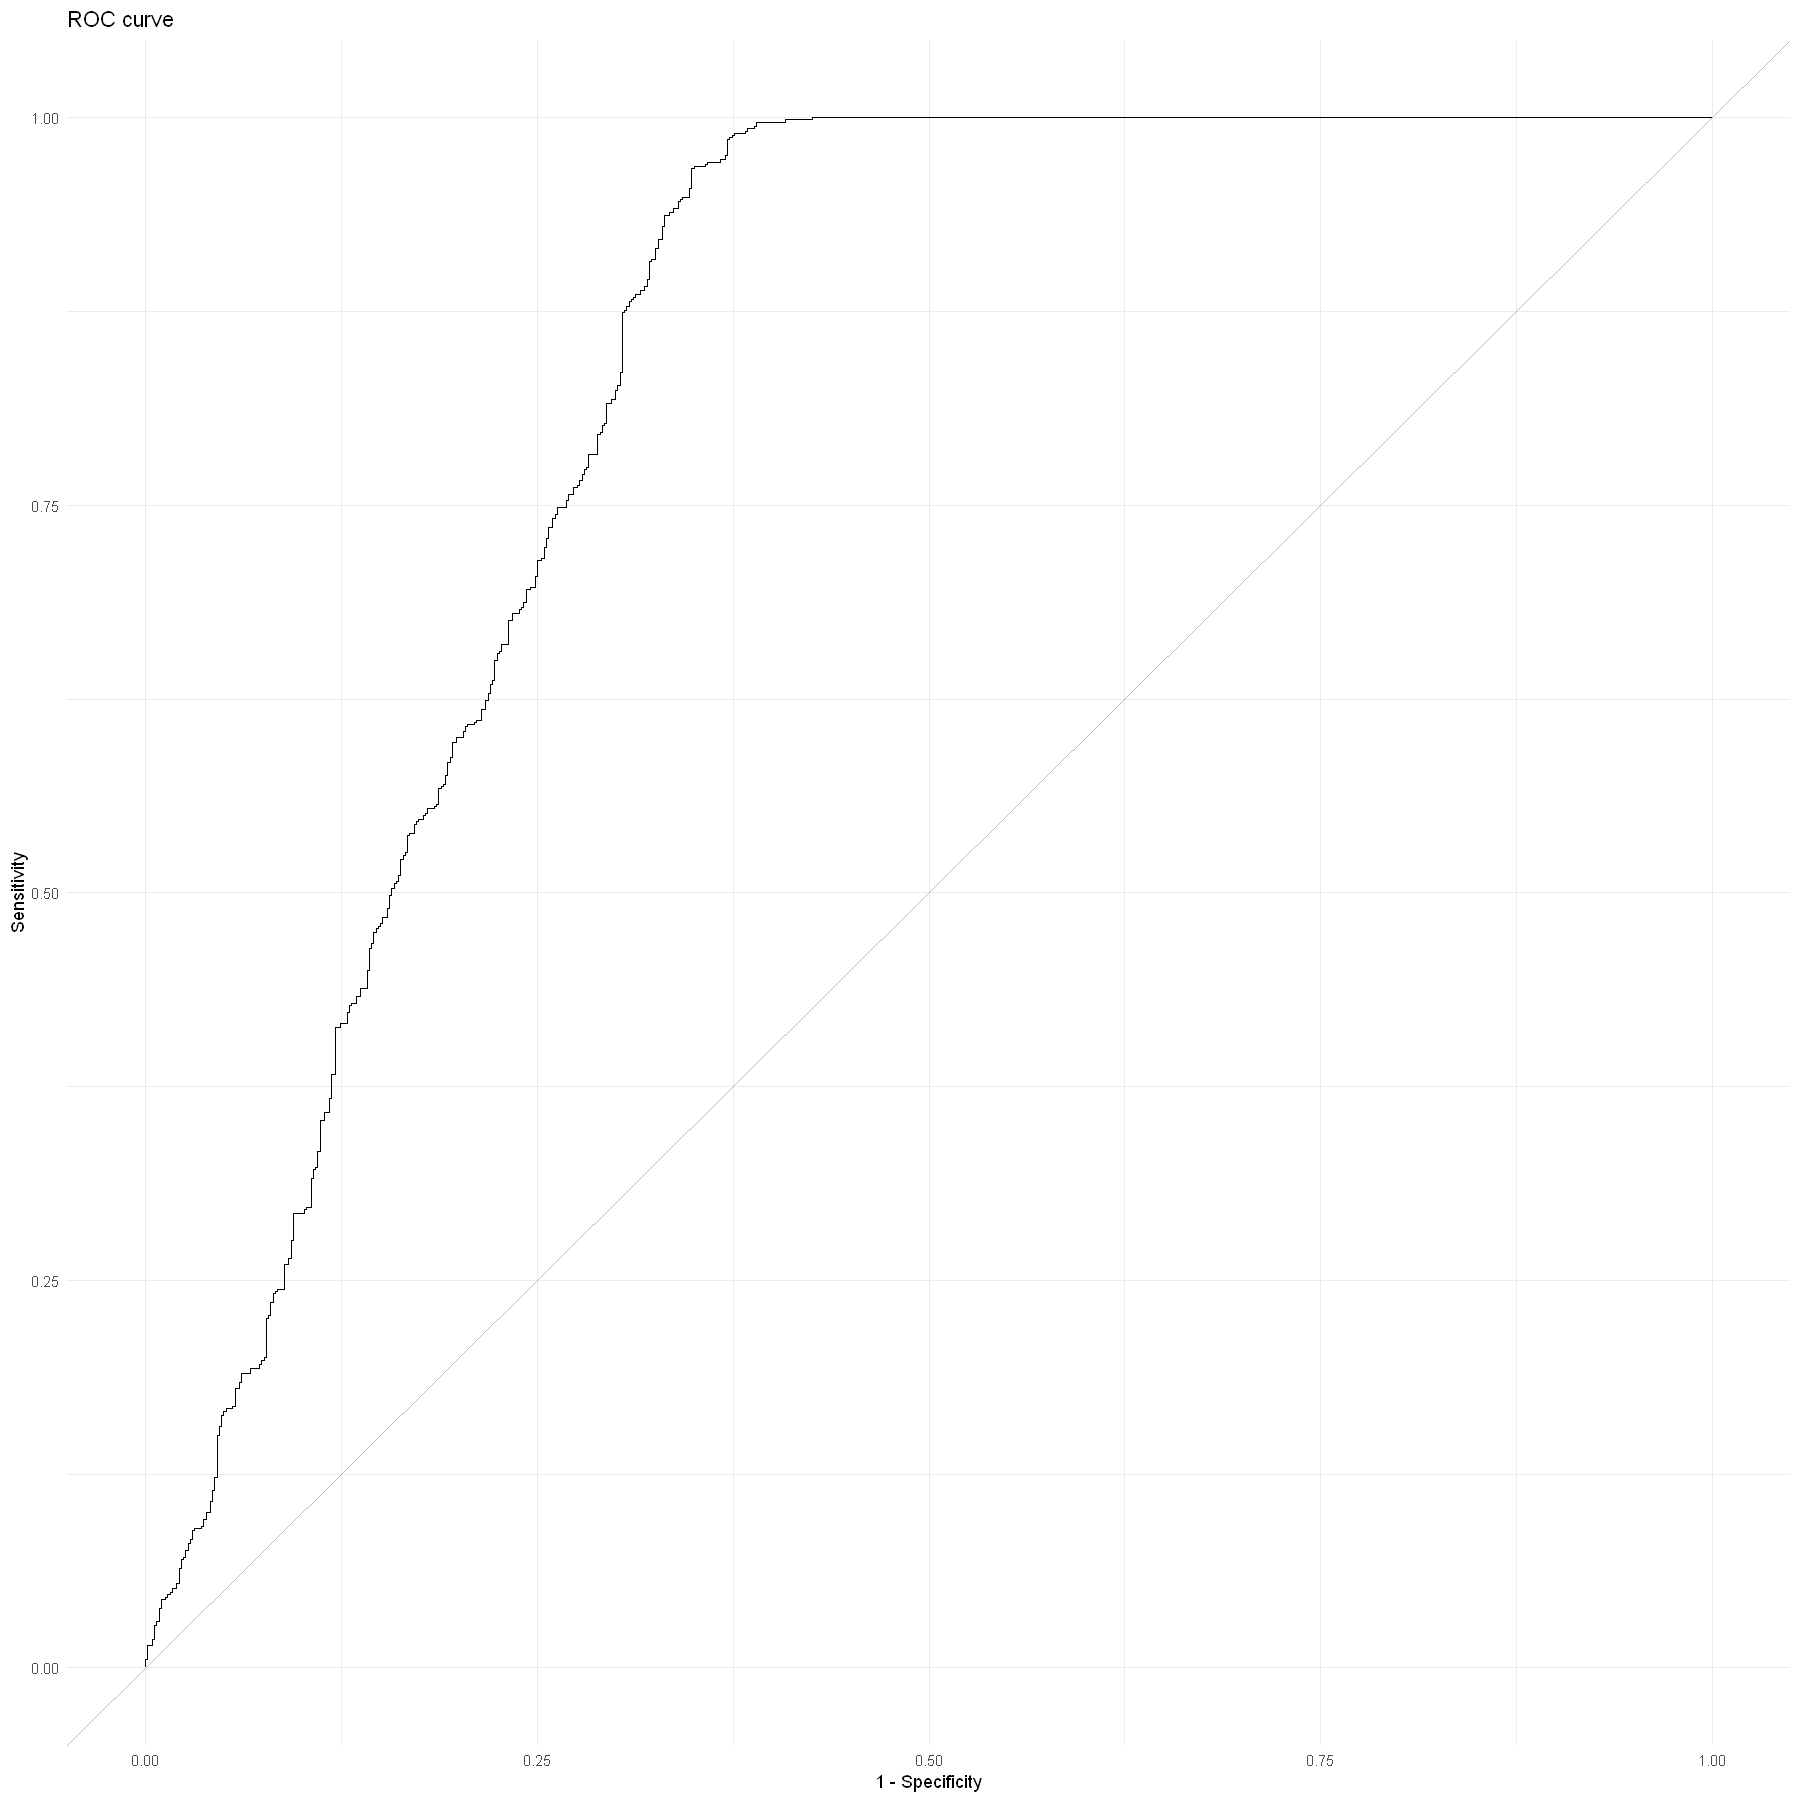

In [70]:
ggplot(data = as.data.frame(accuracies.jags, what = "roc"), aes(x = x, y = y)) +
  geom_line() + 
  geom_abline(intercept = 0, slope = 1, color = "gray") + 
  labs(title = "ROC curve") + 
  xlab("1 - Specificity") + 
  ylab("Sensitivity") +
  theme_minimal()

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


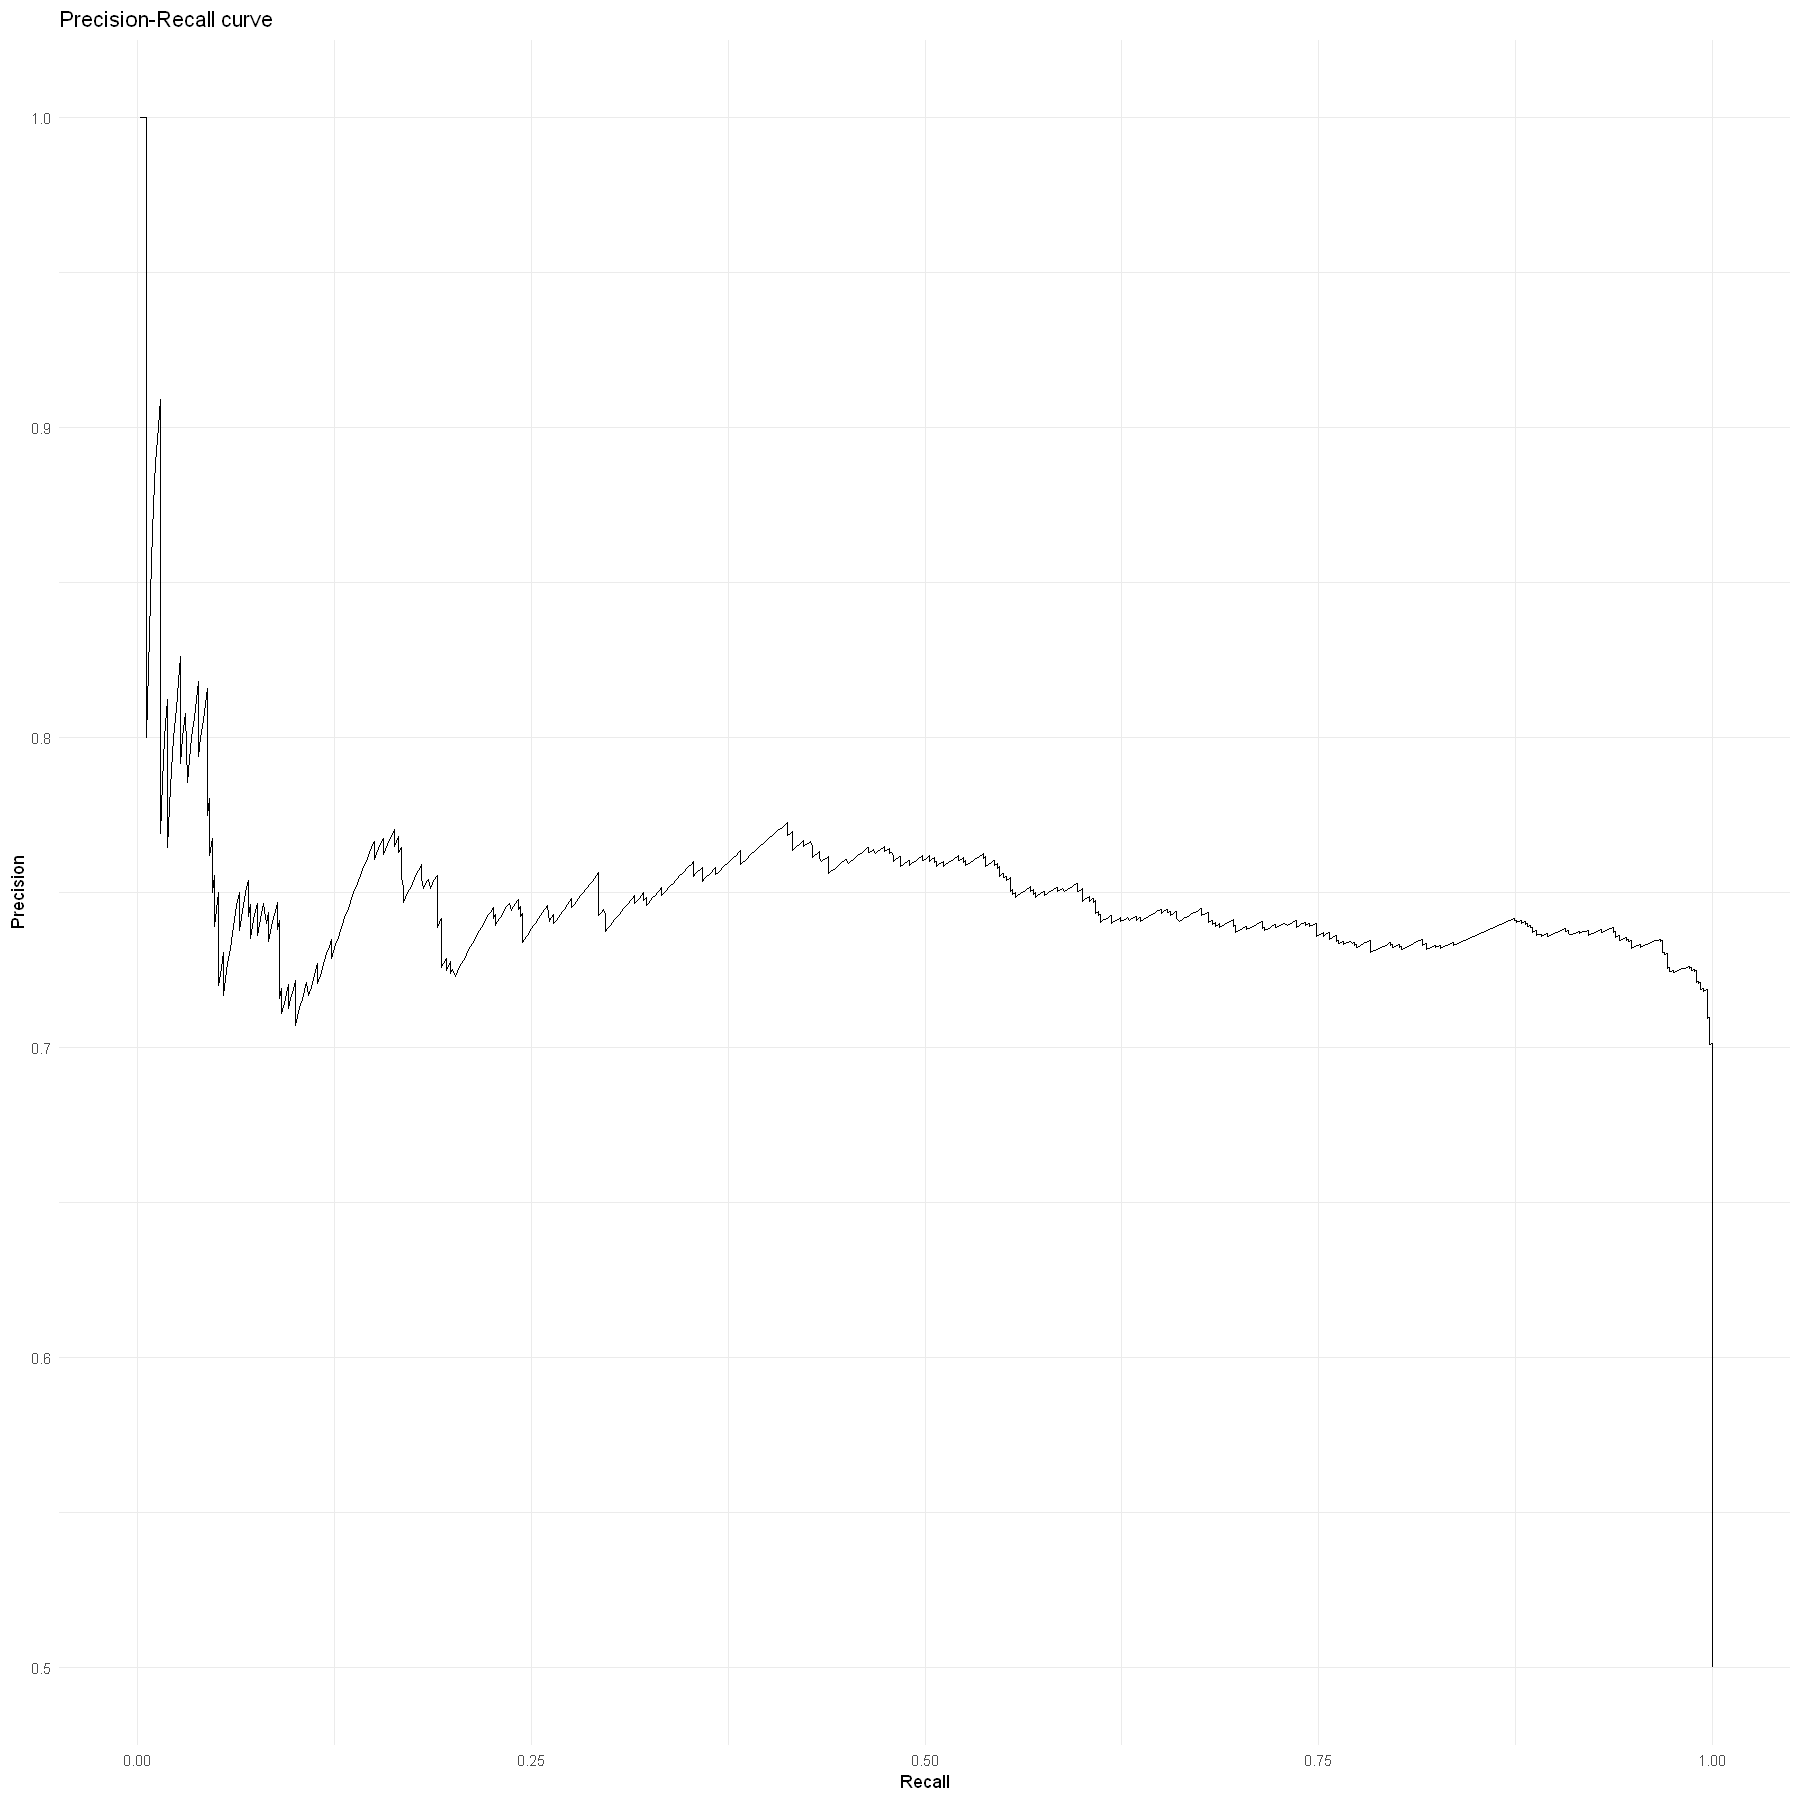

In [71]:
ggplot(data = as.data.frame(accuracies.jags, what = "prc"), aes(x = x, y = y)) +
  geom_line() + 
  labs(title = "Precision-Recall curve") + 
  xlab("Recall") + 
  ylab("Precision") +
  theme_minimal()

We can also plot the Posterior Density of the Area Under each type of Curve setting ``fullsims`` to True:

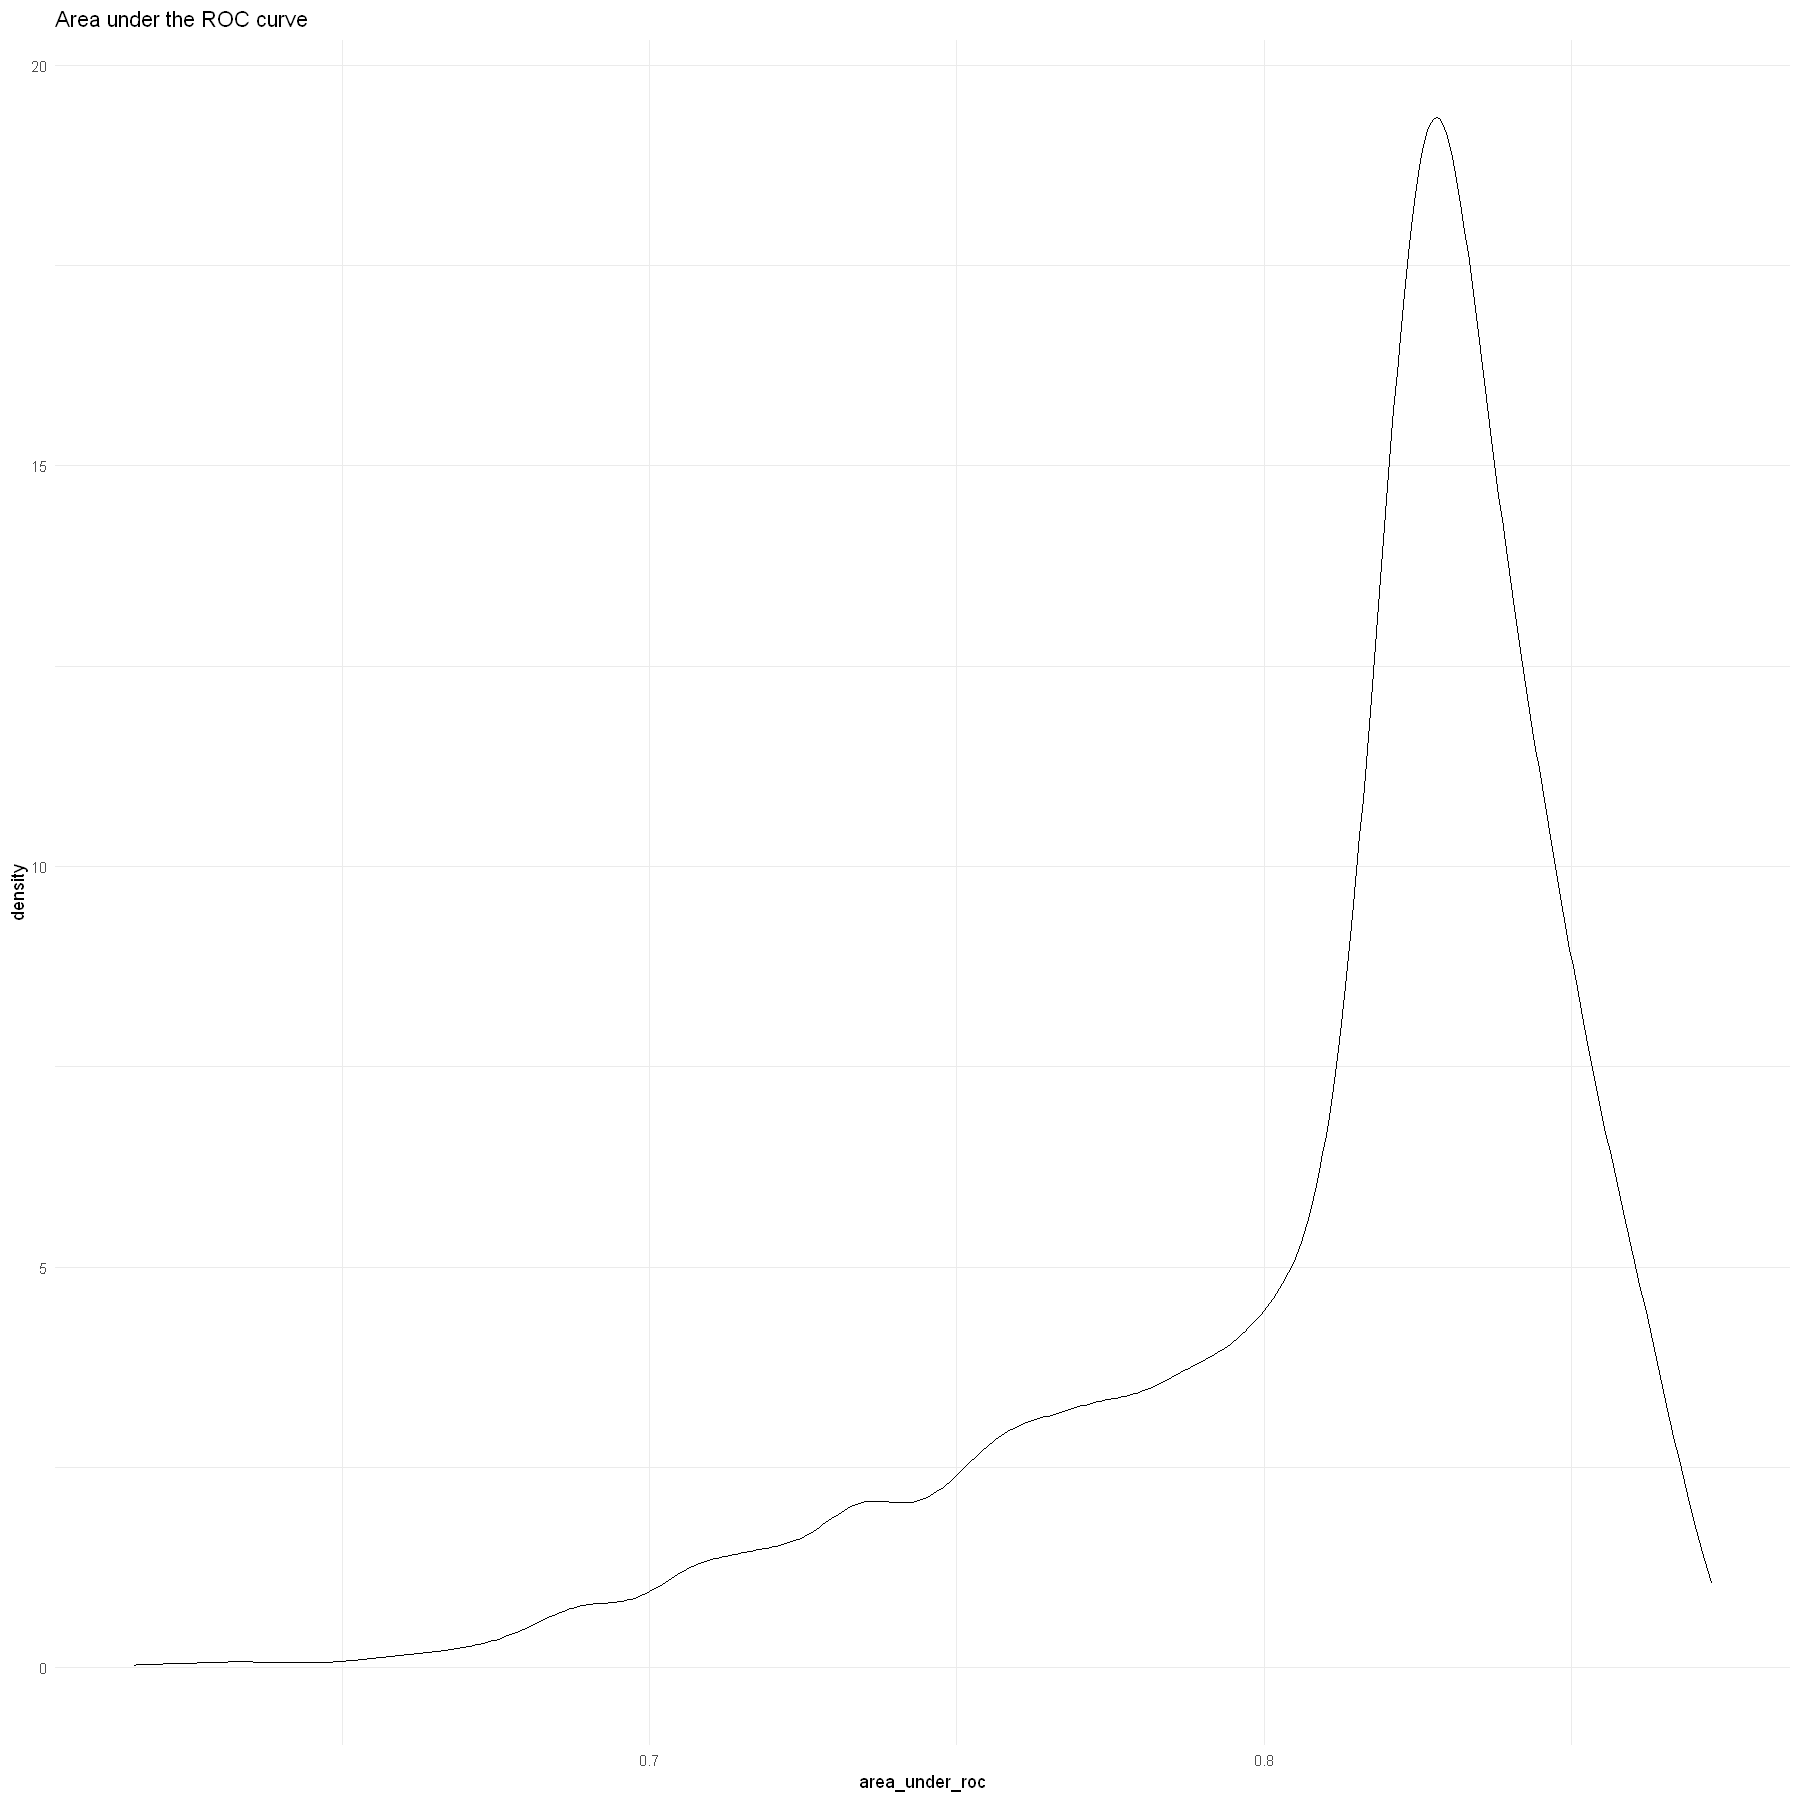

In [72]:
accuracies.jags.full <- mcmcRocPrc(object = jags_model,
                        data = dfCombined,
                        yname  = "Response",
                        xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                        curves = FALSE,
                        fullsims = TRUE)

ggplot(as.data.frame(accuracies.jags.full), 
       aes(x = area_under_roc)) +
  geom_density() +
  labs(title = "Area under the ROC curve") +
  theme_minimal()

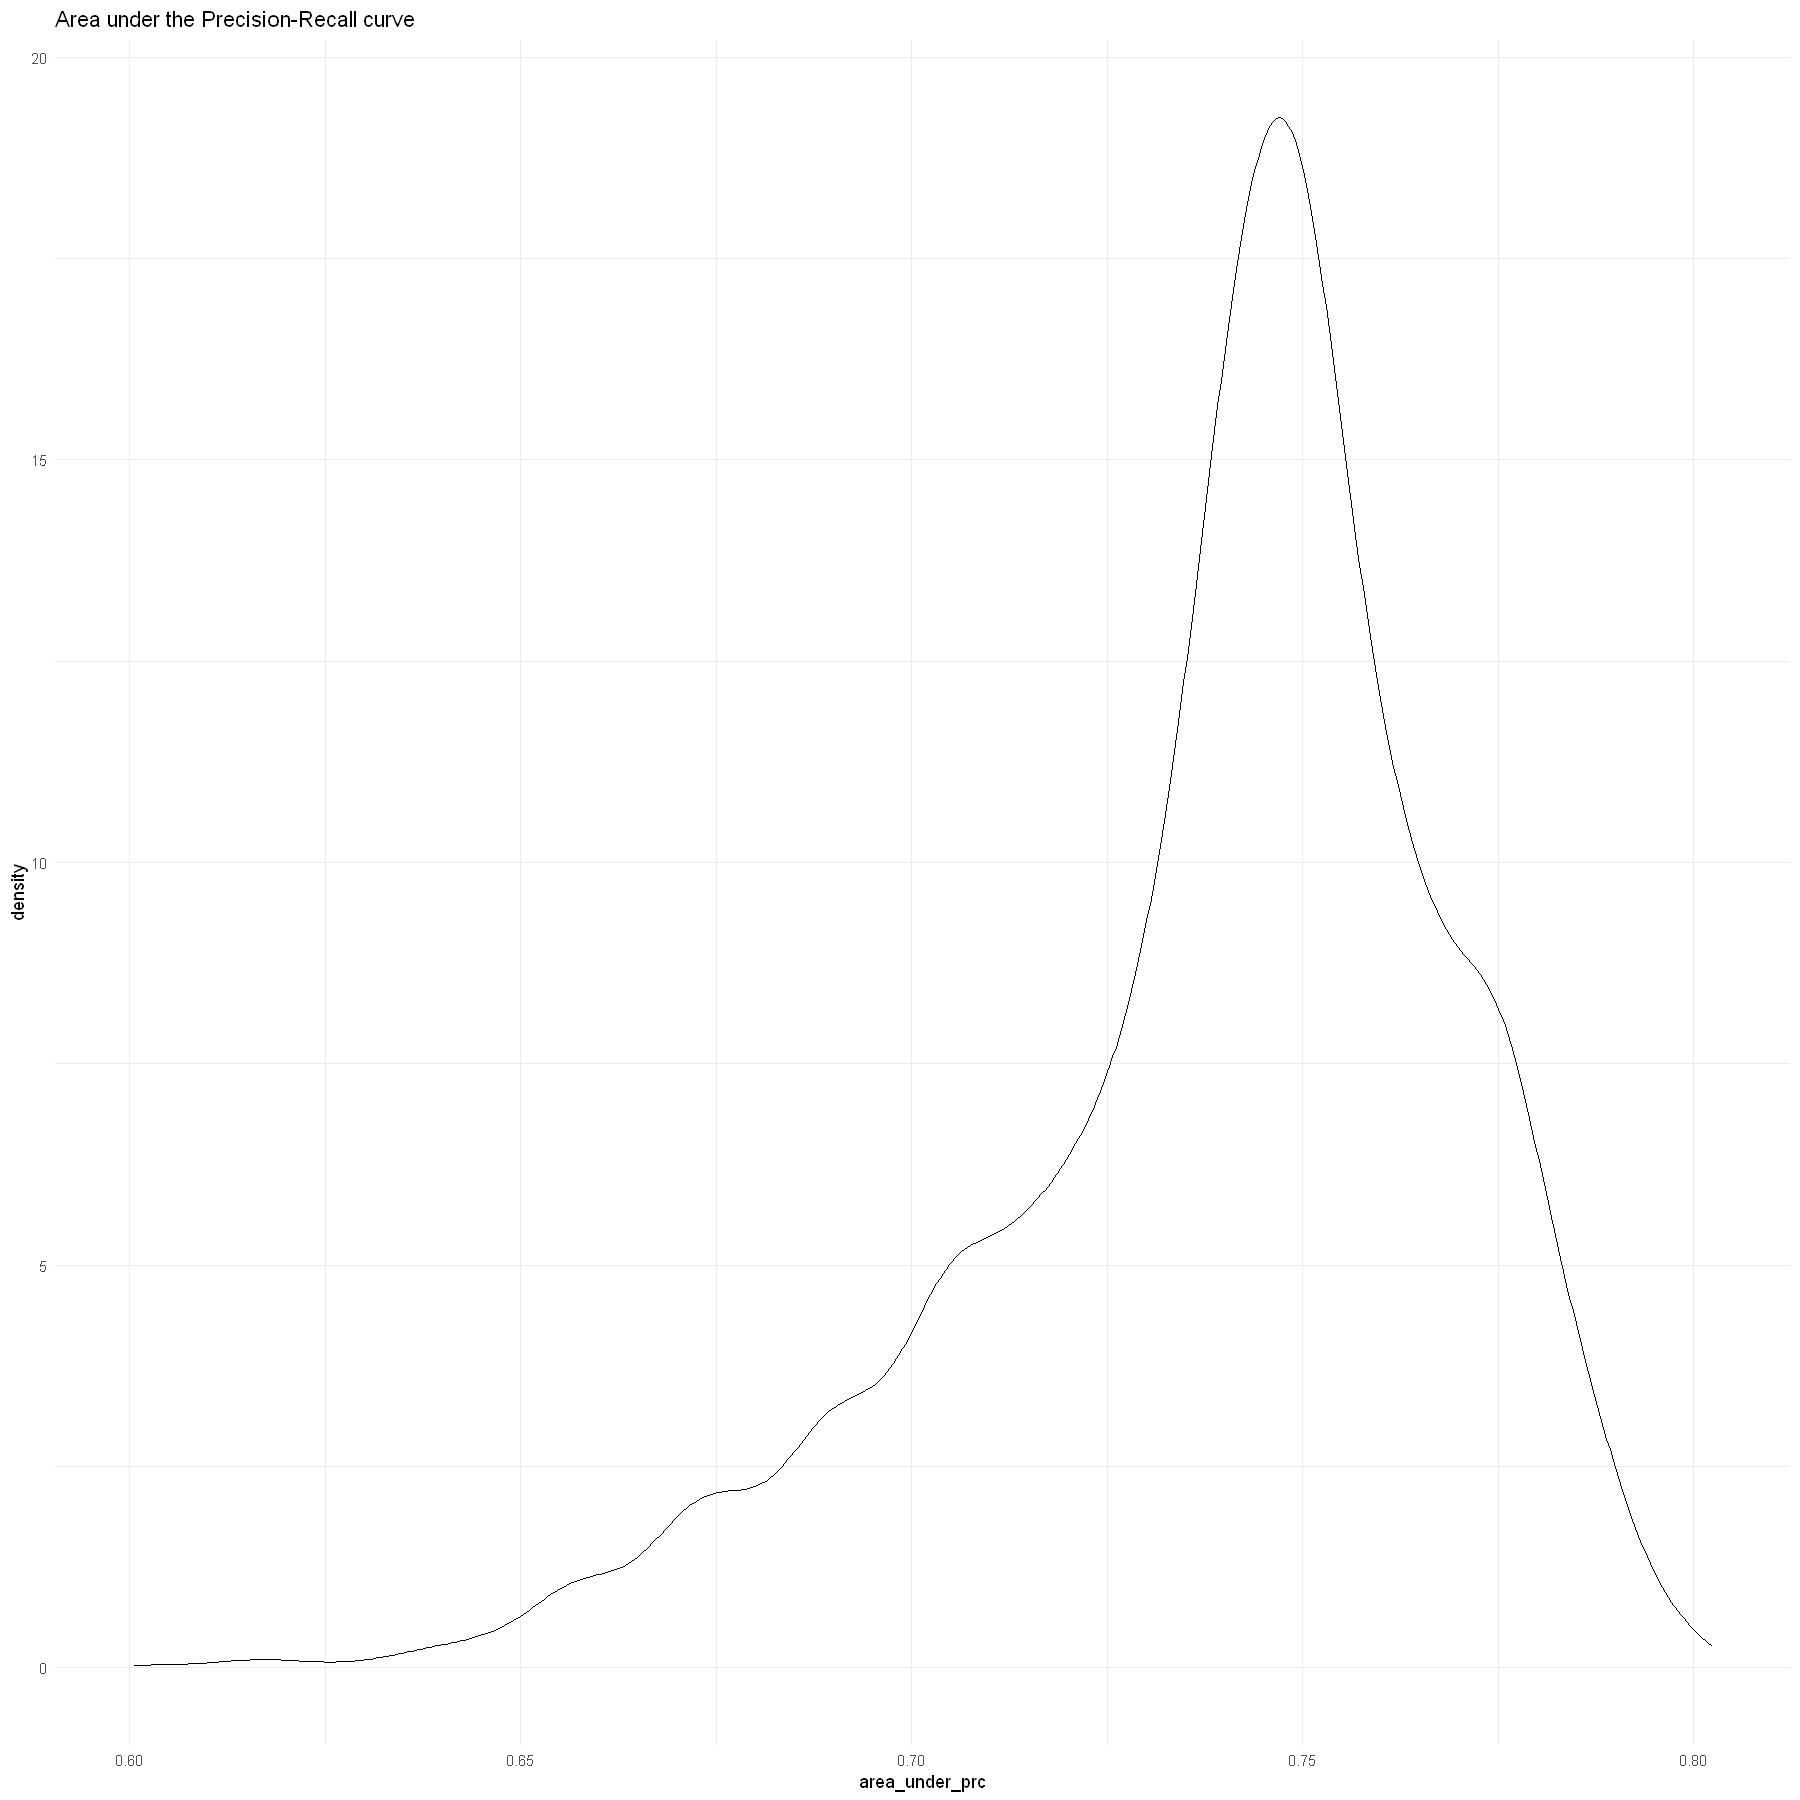

In [73]:
ggplot(as.data.frame(accuracies.jags.full), 
       aes(x = area_under_prc)) +
  geom_density() +
  labs(title = "Area under the Precision-Recall curve") +
  theme_minimal()

### Introducing second order terms

We reformulate the JAGS model including quadratic terms and interactions between variables. In order to obtain meaningful results, we let the model run longer. The initial results are not much better, because the model struggles to optimise so many parameters at the same time, but it allows us to subselect variables.

In [199]:
length(colnames(df2))

[1] 45

In [207]:
variables <- c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')

df2<-data.frame(df[, c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage',
                             'Annual_Premium','Vintage','Response')])
for (i in 1:(length(variables)-1)){
    for (j in 1:i){
        str<-paste(variables[i], variables[j], sep = "X")
        df2[str] <- df[variables[i]]*df[variables[j]]
    }
}

dfCombined2 <- as.list(df2)
dfCombined2$nrows <- nrow(df2)
col<-colnames(df2)

str<-paste("b[",9,"]", sep="")

for (i in 1:(length(colnames(df2)))){
    if(col[i]!="Response")
        str<-paste(str," + b[",i,"] * ",col[i],"[i]", sep="")
}

str

[1] "b[9] + b[1] * Gender[i] + b[2] * Age[i] + b[3] * Driving_License[i] + b[4] * Previously_Insured[i] + b[5] * Vehicle_Age[i] + b[6] * Vehicle_Damage[i] + b[7] * Annual_Premium[i] + b[8] * Vintage[i] + b[10] * GenderXGender[i] + b[11] * AgeXGender[i] + b[12] * AgeXAge[i] + b[13] * Driving_LicenseXGender[i] + b[14] * Driving_LicenseXAge[i] + b[15] * Driving_LicenseXDriving_License[i] + b[16] * Previously_InsuredXGender[i] + b[17] * Previously_InsuredXAge[i] + b[18] * Previously_InsuredXDriving_License[i] + b[19] * Previously_InsuredXPreviously_Insured[i] + b[20] * Vehicle_AgeXGender[i] + b[21] * Vehicle_AgeXAge[i] + b[22] * Vehicle_AgeXDriving_License[i] + b[23] * Vehicle_AgeXPreviously_Insured[i] + b[24] * Vehicle_AgeXVehicle_Age[i] + b[25] * Vehicle_DamageXGender[i] + b[26] * Vehicle_DamageXAge[i] + b[27] * Vehicle_DamageXDriving_License[i] + b[28] * Vehicle_DamageXPreviously_Insured[i] + b[29] * Vehicle_DamageXVehicle_Age[i] + b[30] * Vehicle_DamageXVehicle_Damage[i] + b[31] * Annual_PremiumXGender[i] + b[32] * Annual_PremiumXAge[i] + b[33] * Annual_PremiumXDriving_License[i] + b[34] * Annual_PremiumXPreviously_Insured[i] + b[35] * Annual_PremiumXVehicle_Age[i] + b[36] * Annual_PremiumXVehicle_Damage[i] + b[37] * Annual_PremiumXAnnual_Premium[i] + b[38] * VintageXGender[i] + b[39] * VintageXAge[i] + b[40] * VintageXDriving_License[i] + b[41] * VintageXPreviously_Insured[i] + b[42] * VintageXVehicle_Age[i] + b[43] * VintageXVehicle_Damage[i] + b[44] * VintageXAnnual_Premium[i] + b[45] * VintageXVintage[i]"

In [257]:
mod2.jags <- paste(" 
model {
for (i in 1:nrows){
  Response[i] ~ dbern(p[i])  
  logit(p[i]) <- mu[i]   
  mu[i] <-" ,str,"
}
for(j in 1:46){
  b[j] ~ dnorm(0, 0.1)
  }

}
")
writeLines(mod2.jags, "mod2.jags")    

In [258]:
params.jags2 <- c("b")
inits1.jags2 <- list("b" = rep(0, 46))
inits.jags2 <- list(inits1.jags2,inits1.jags2,inits1.jags2,inits1.jags2)

In [259]:
library("R2jags")
set.seed(123)

jags_model2 <- jags(data = dfCombined2, inits = inits.jags2, 
  parameters.to.save = params.jags2, n.chains = 4, n.iter = 4000, 
  n.burnin = 2000, model.file = "mod2.jags")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1400
   Unobserved stochastic nodes: 46
   Total graph size: 78094

Initializing model



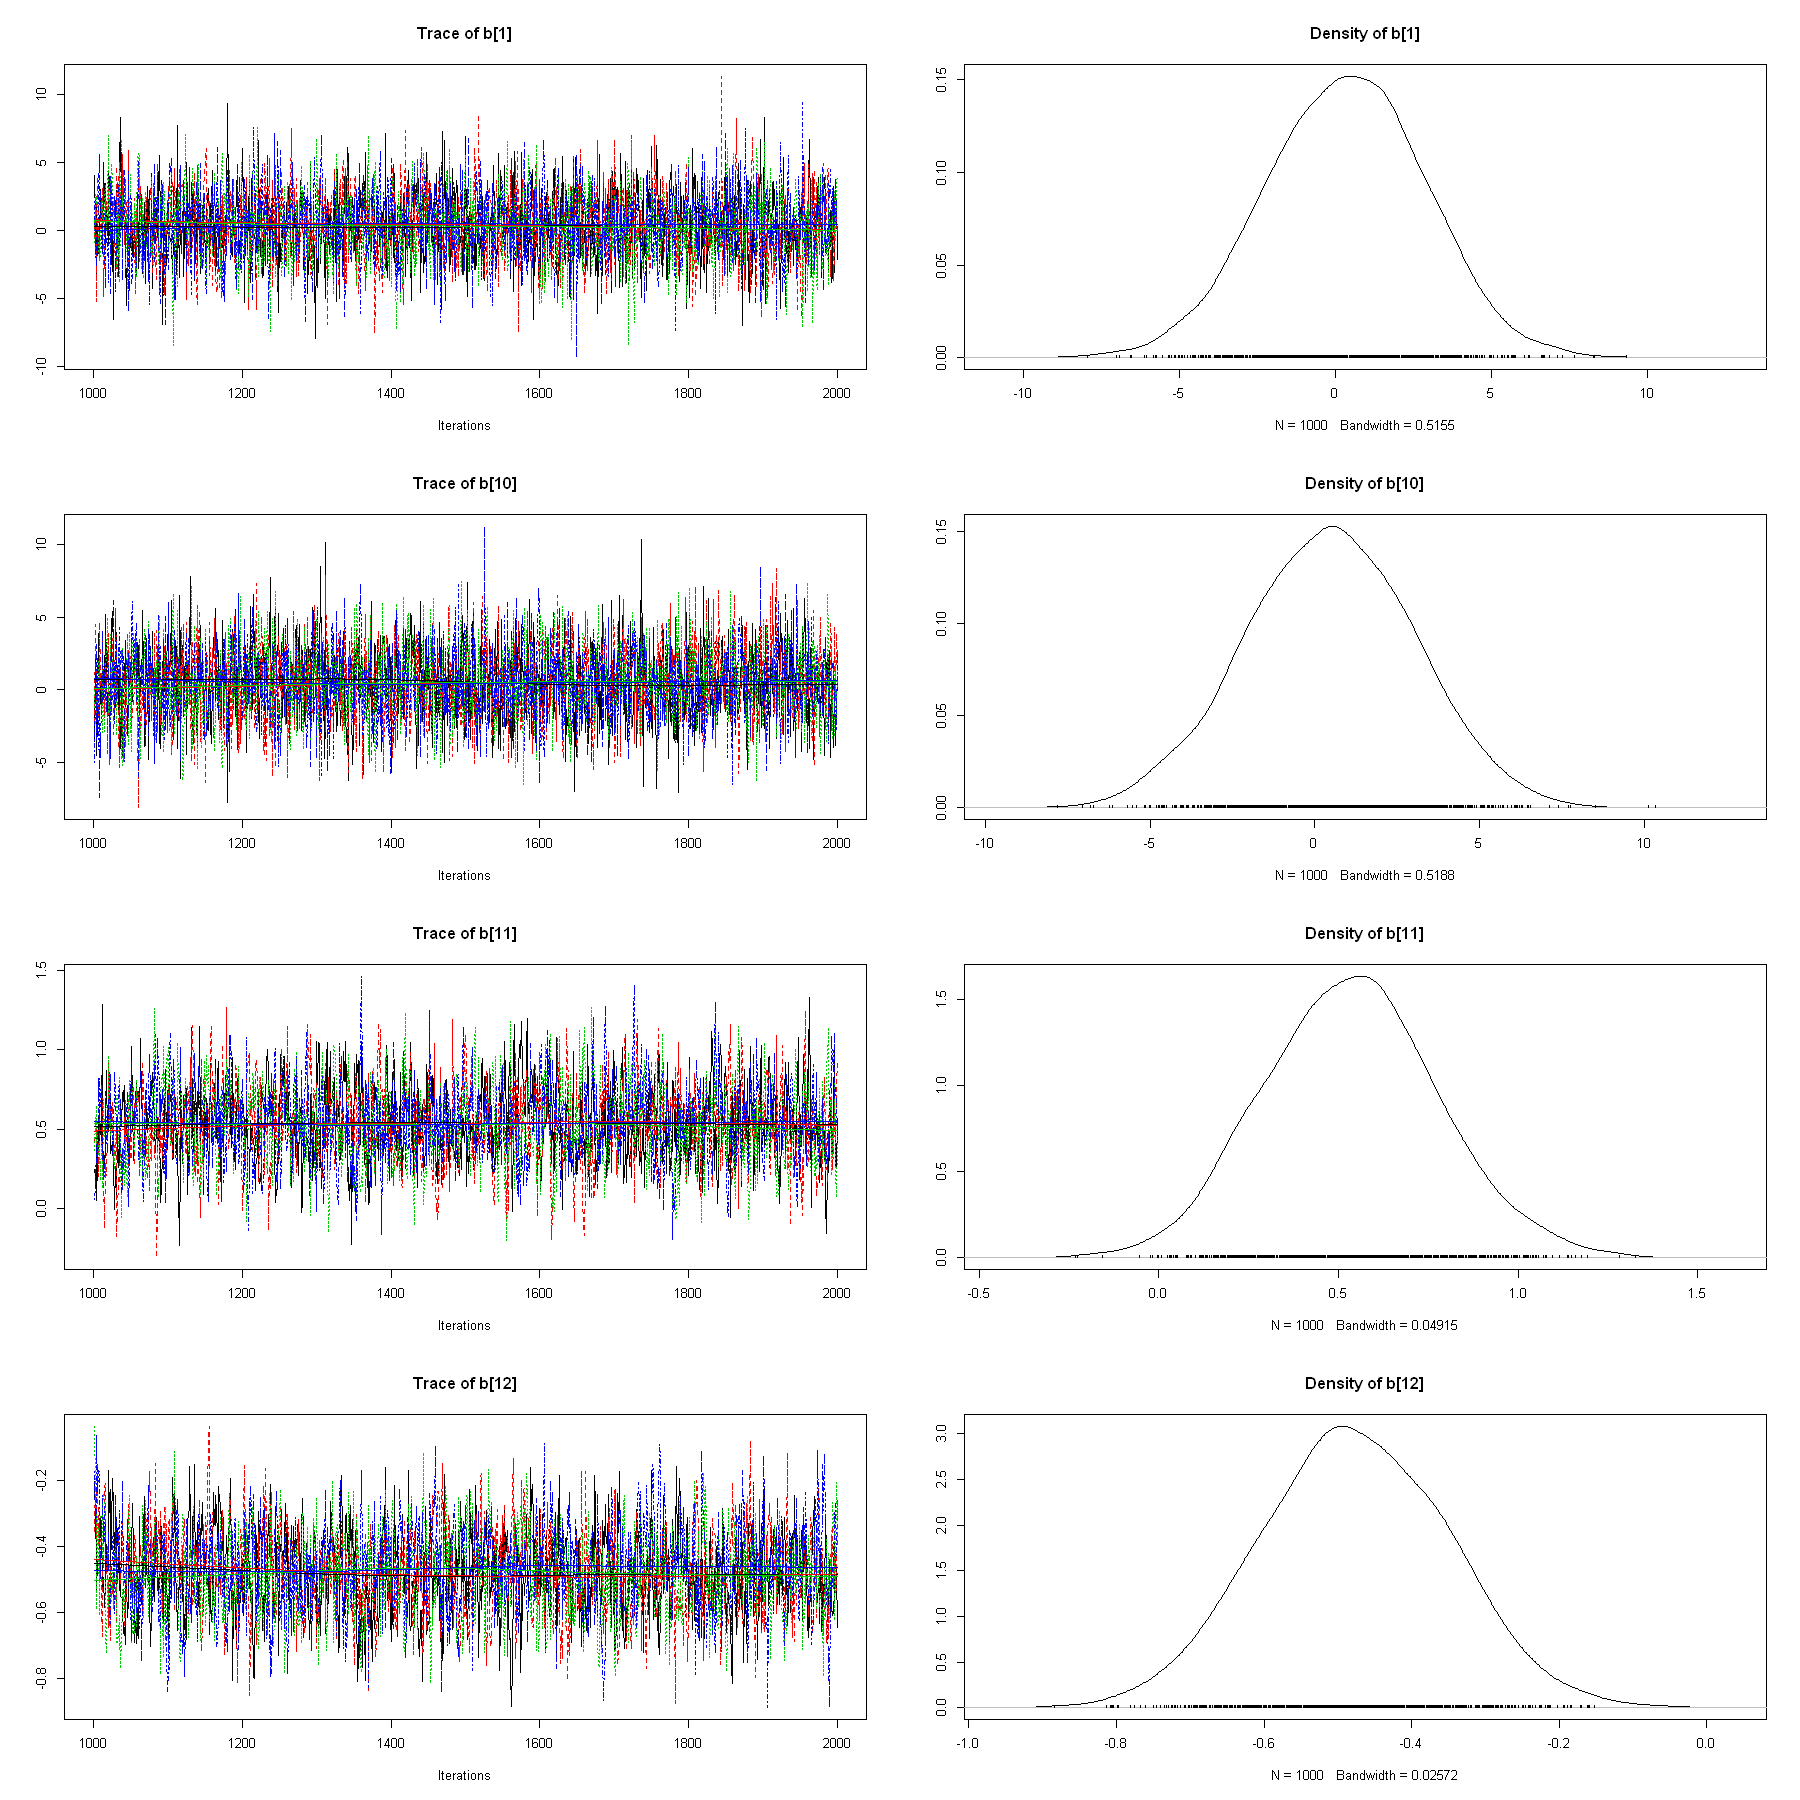

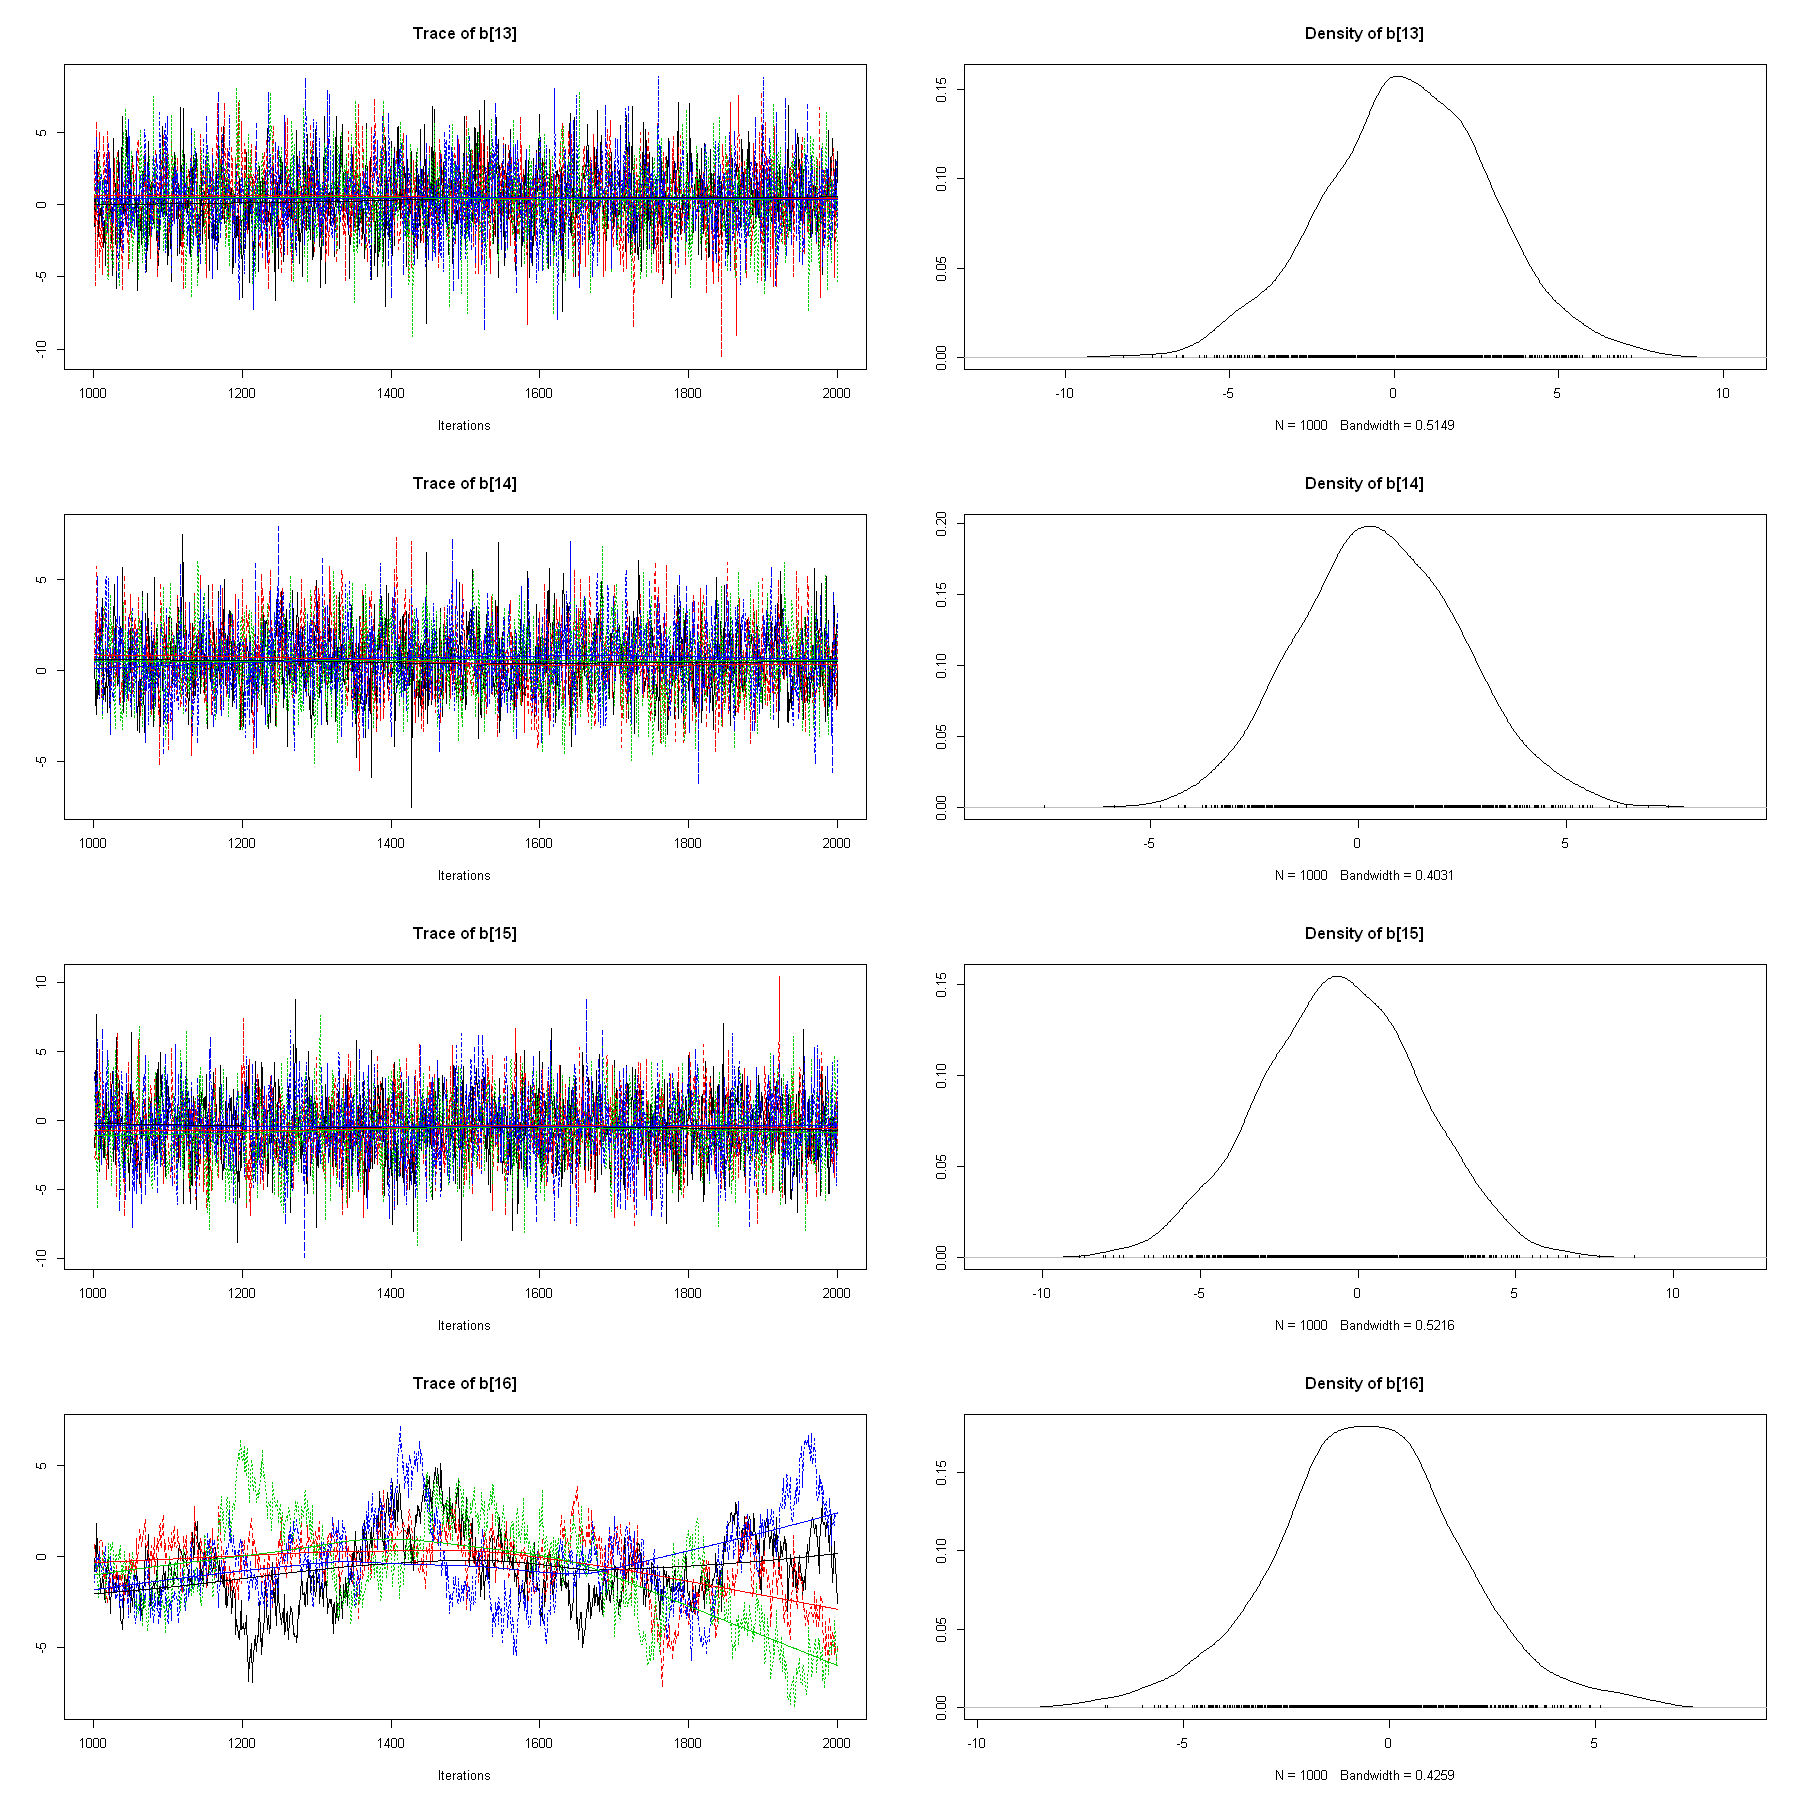

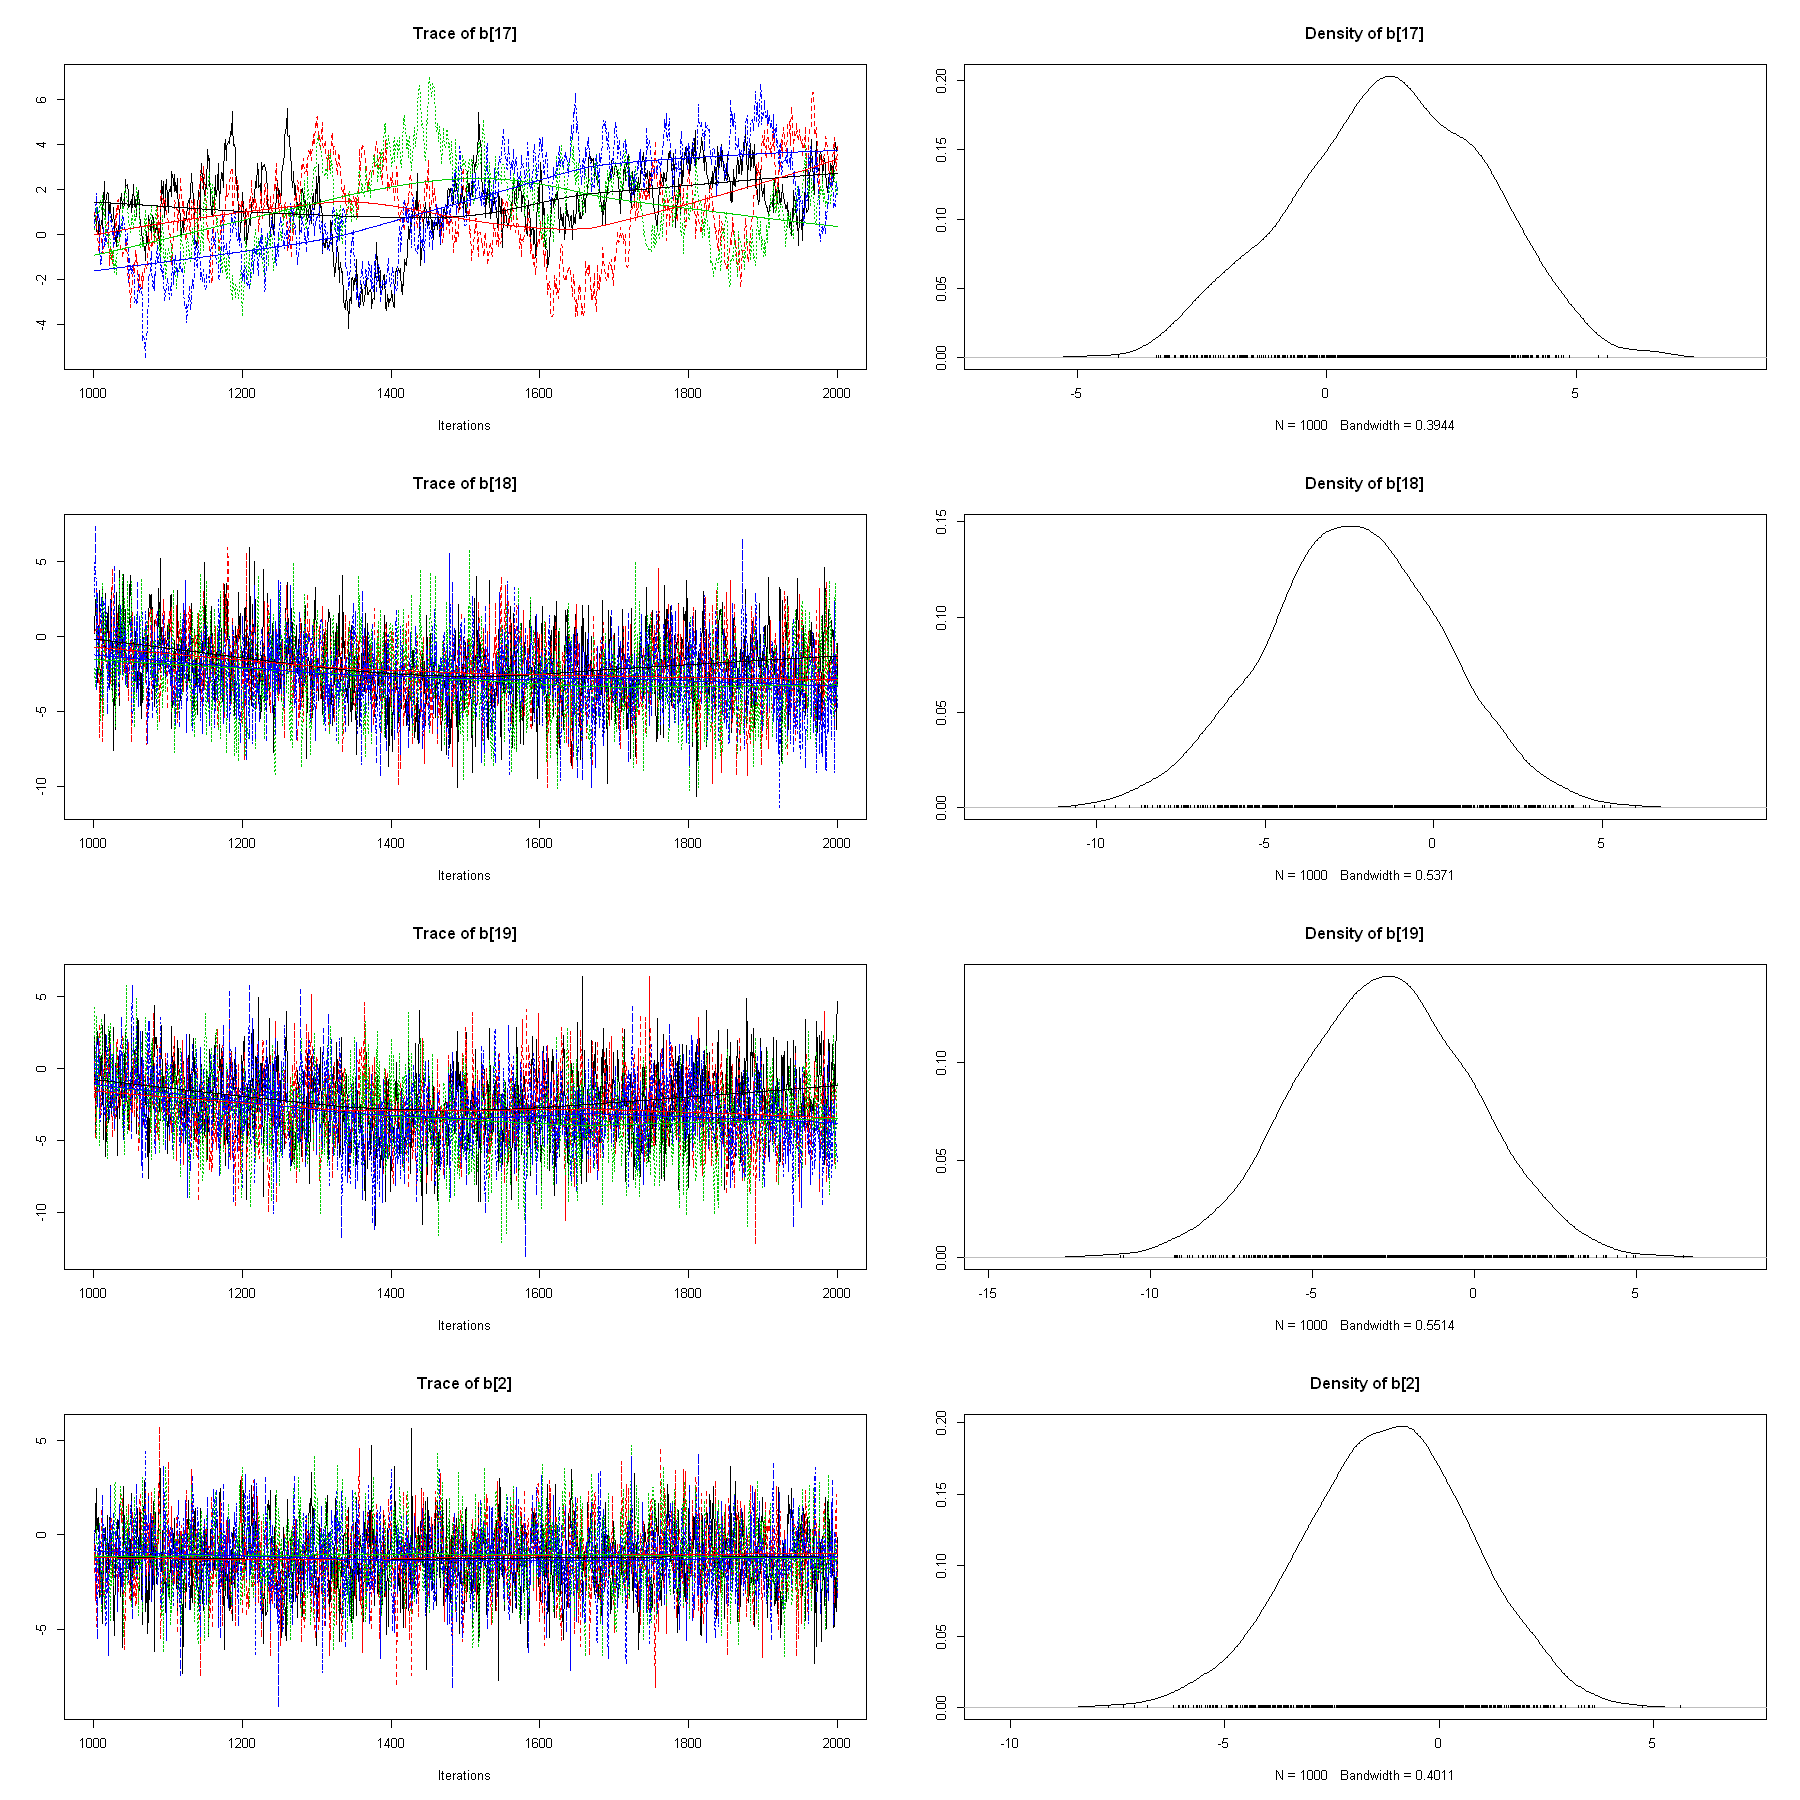

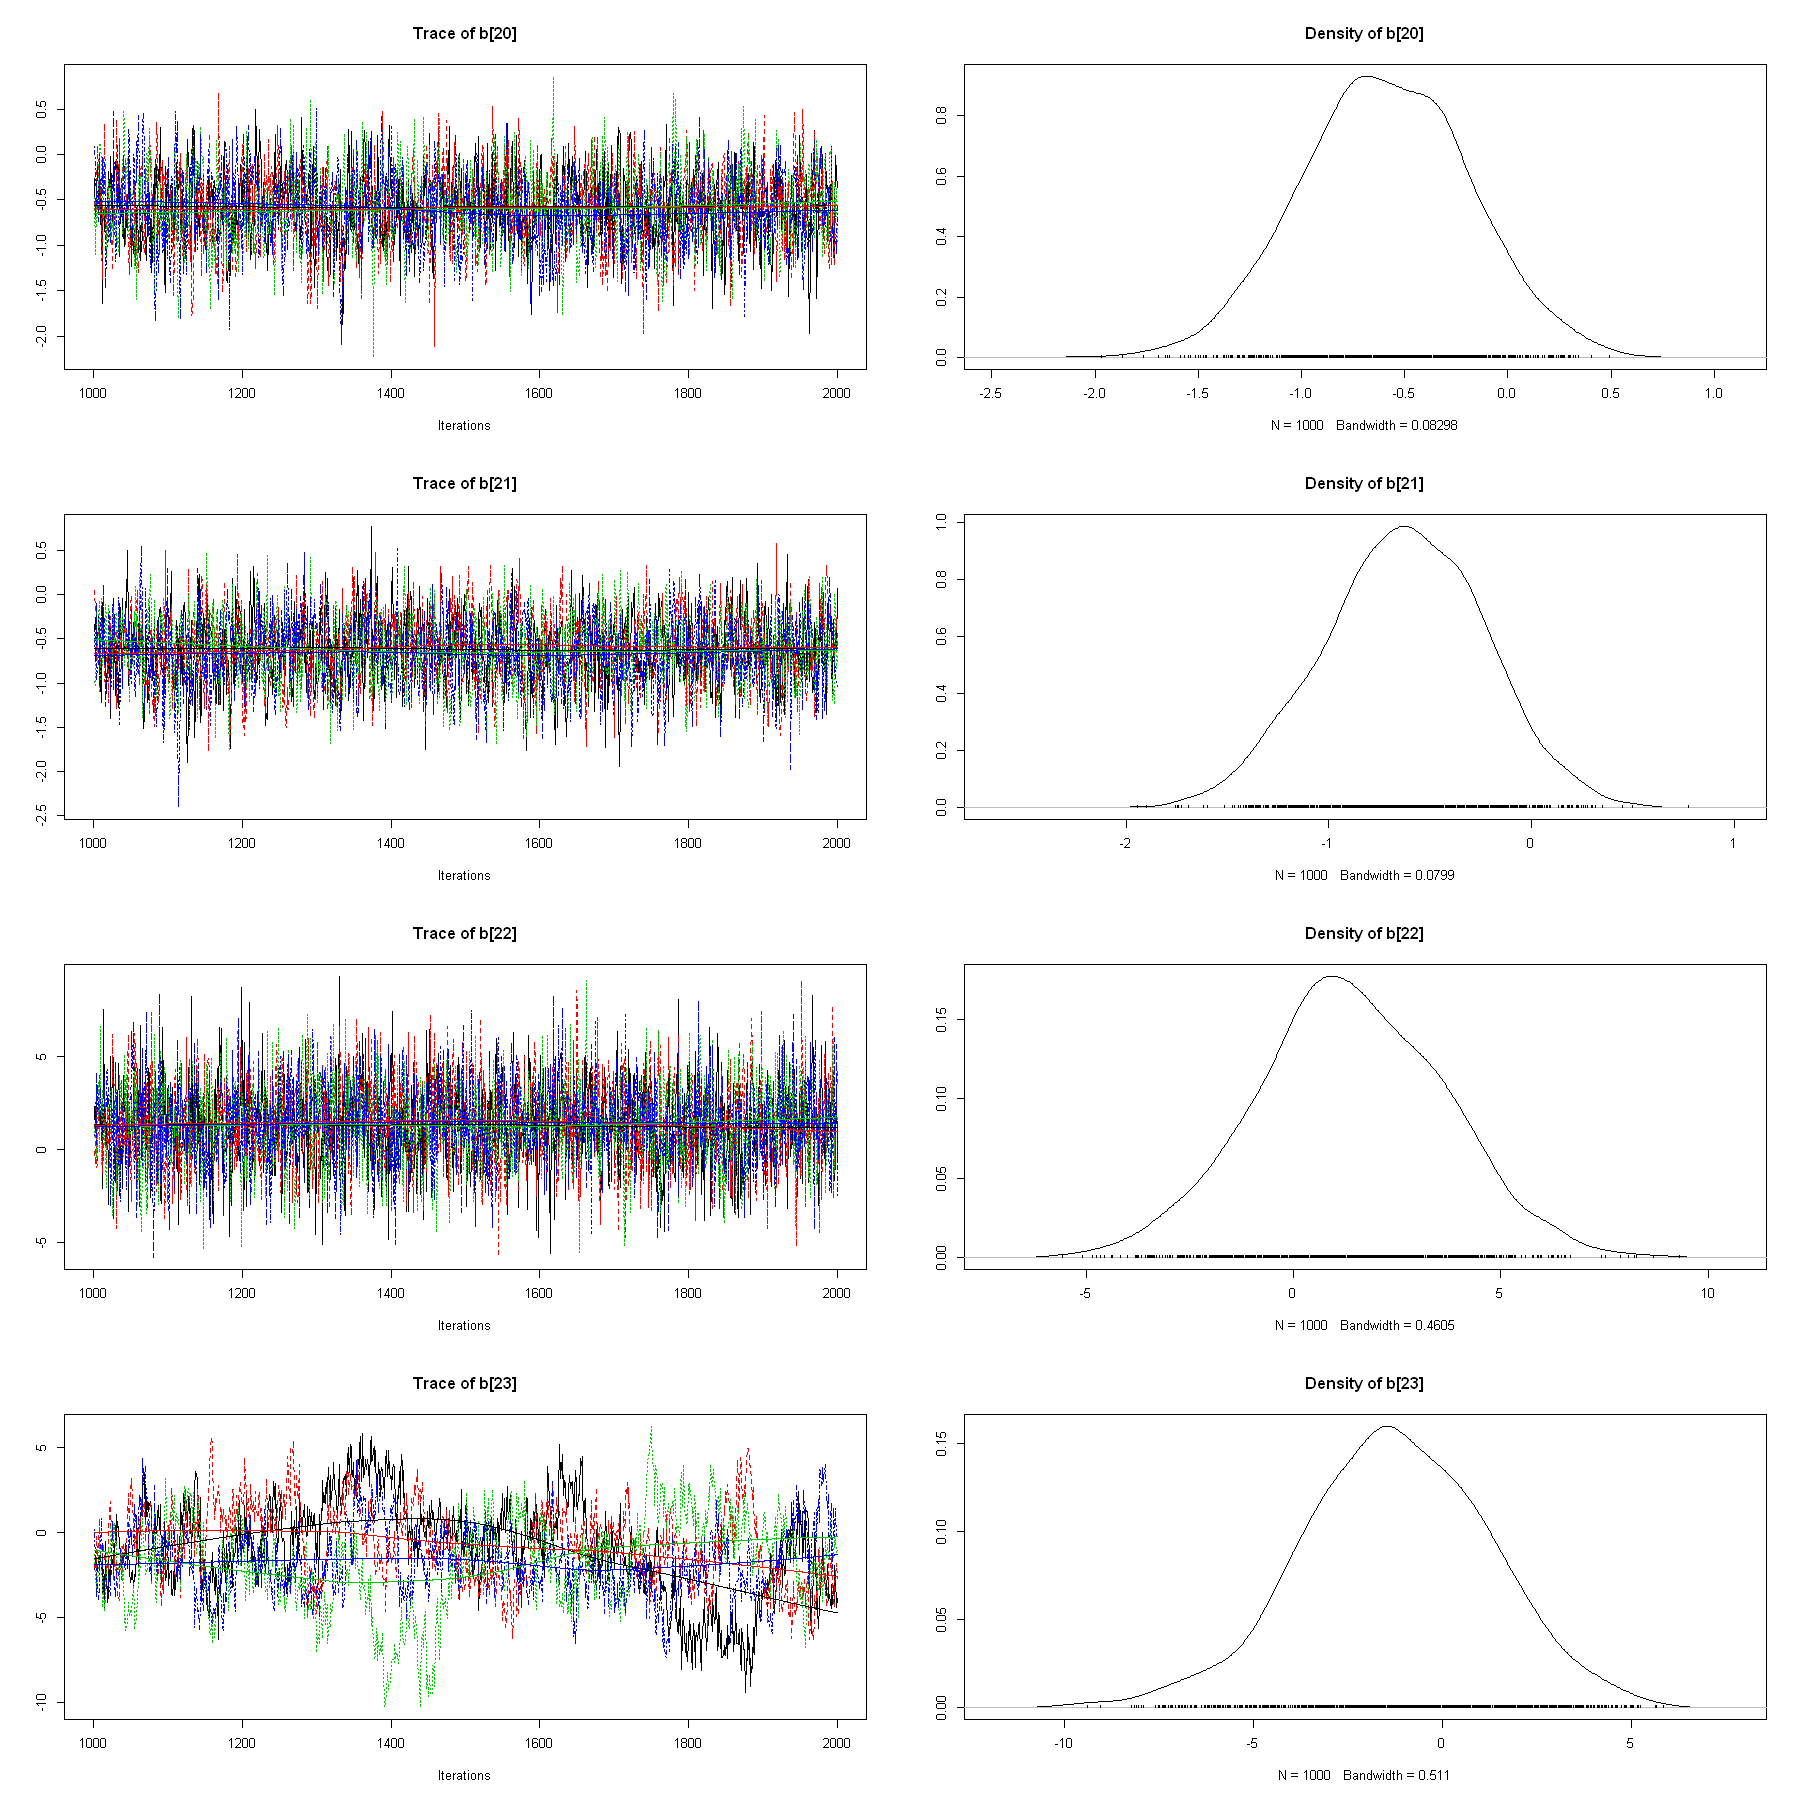

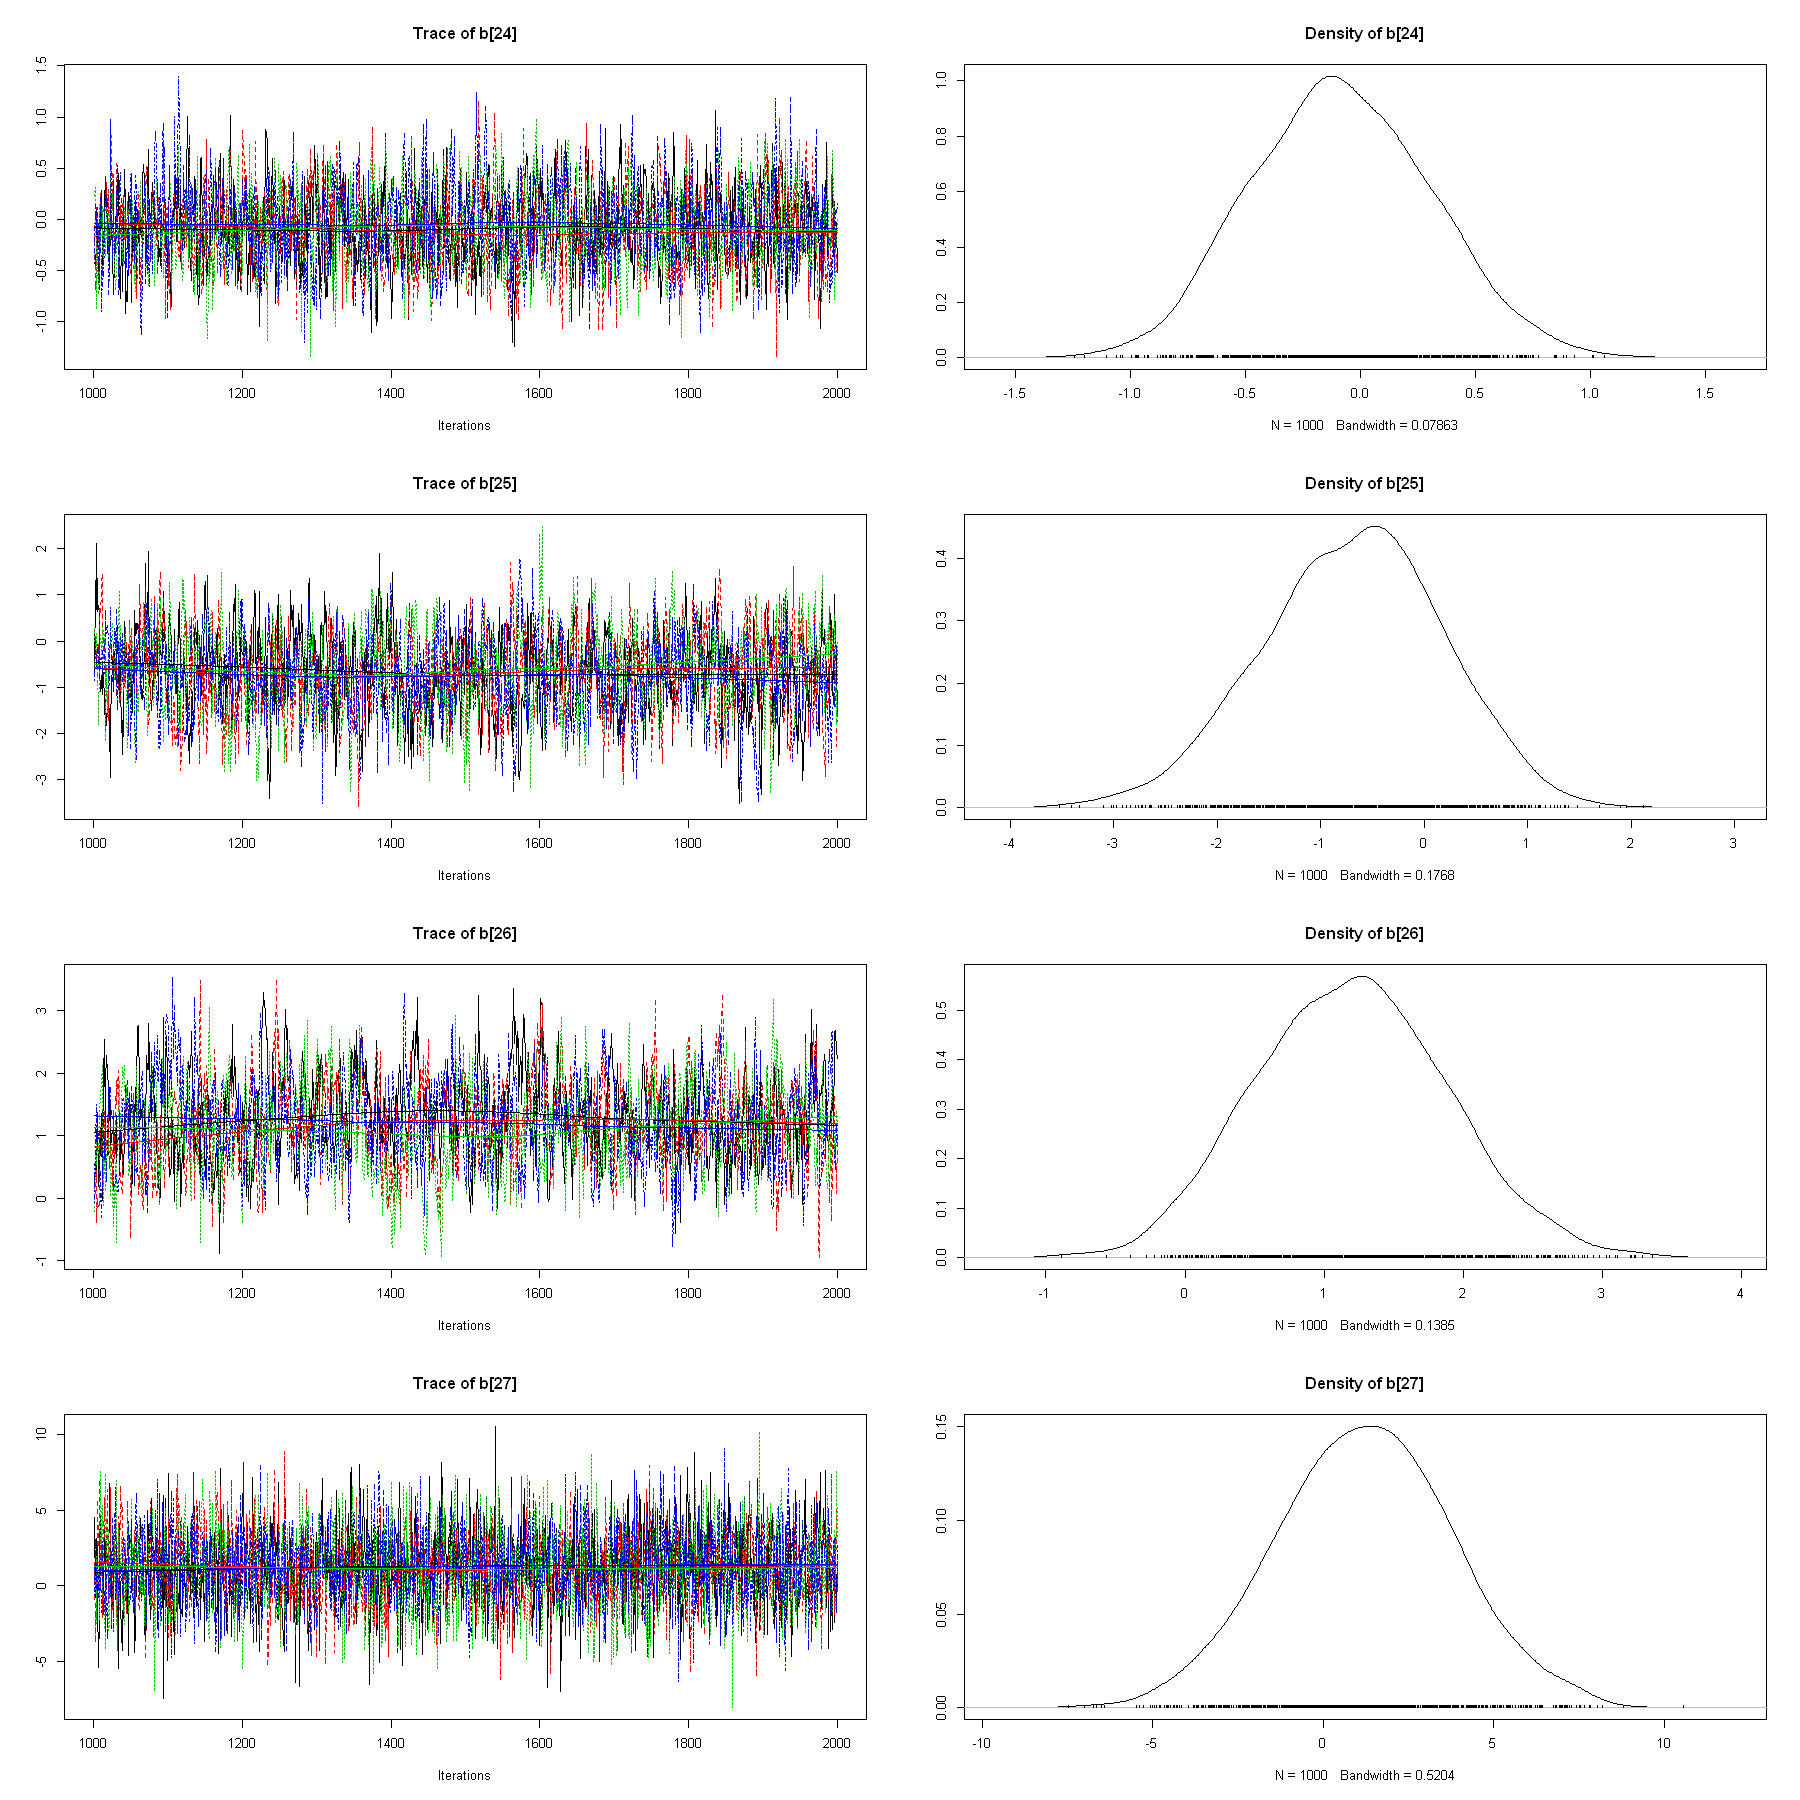

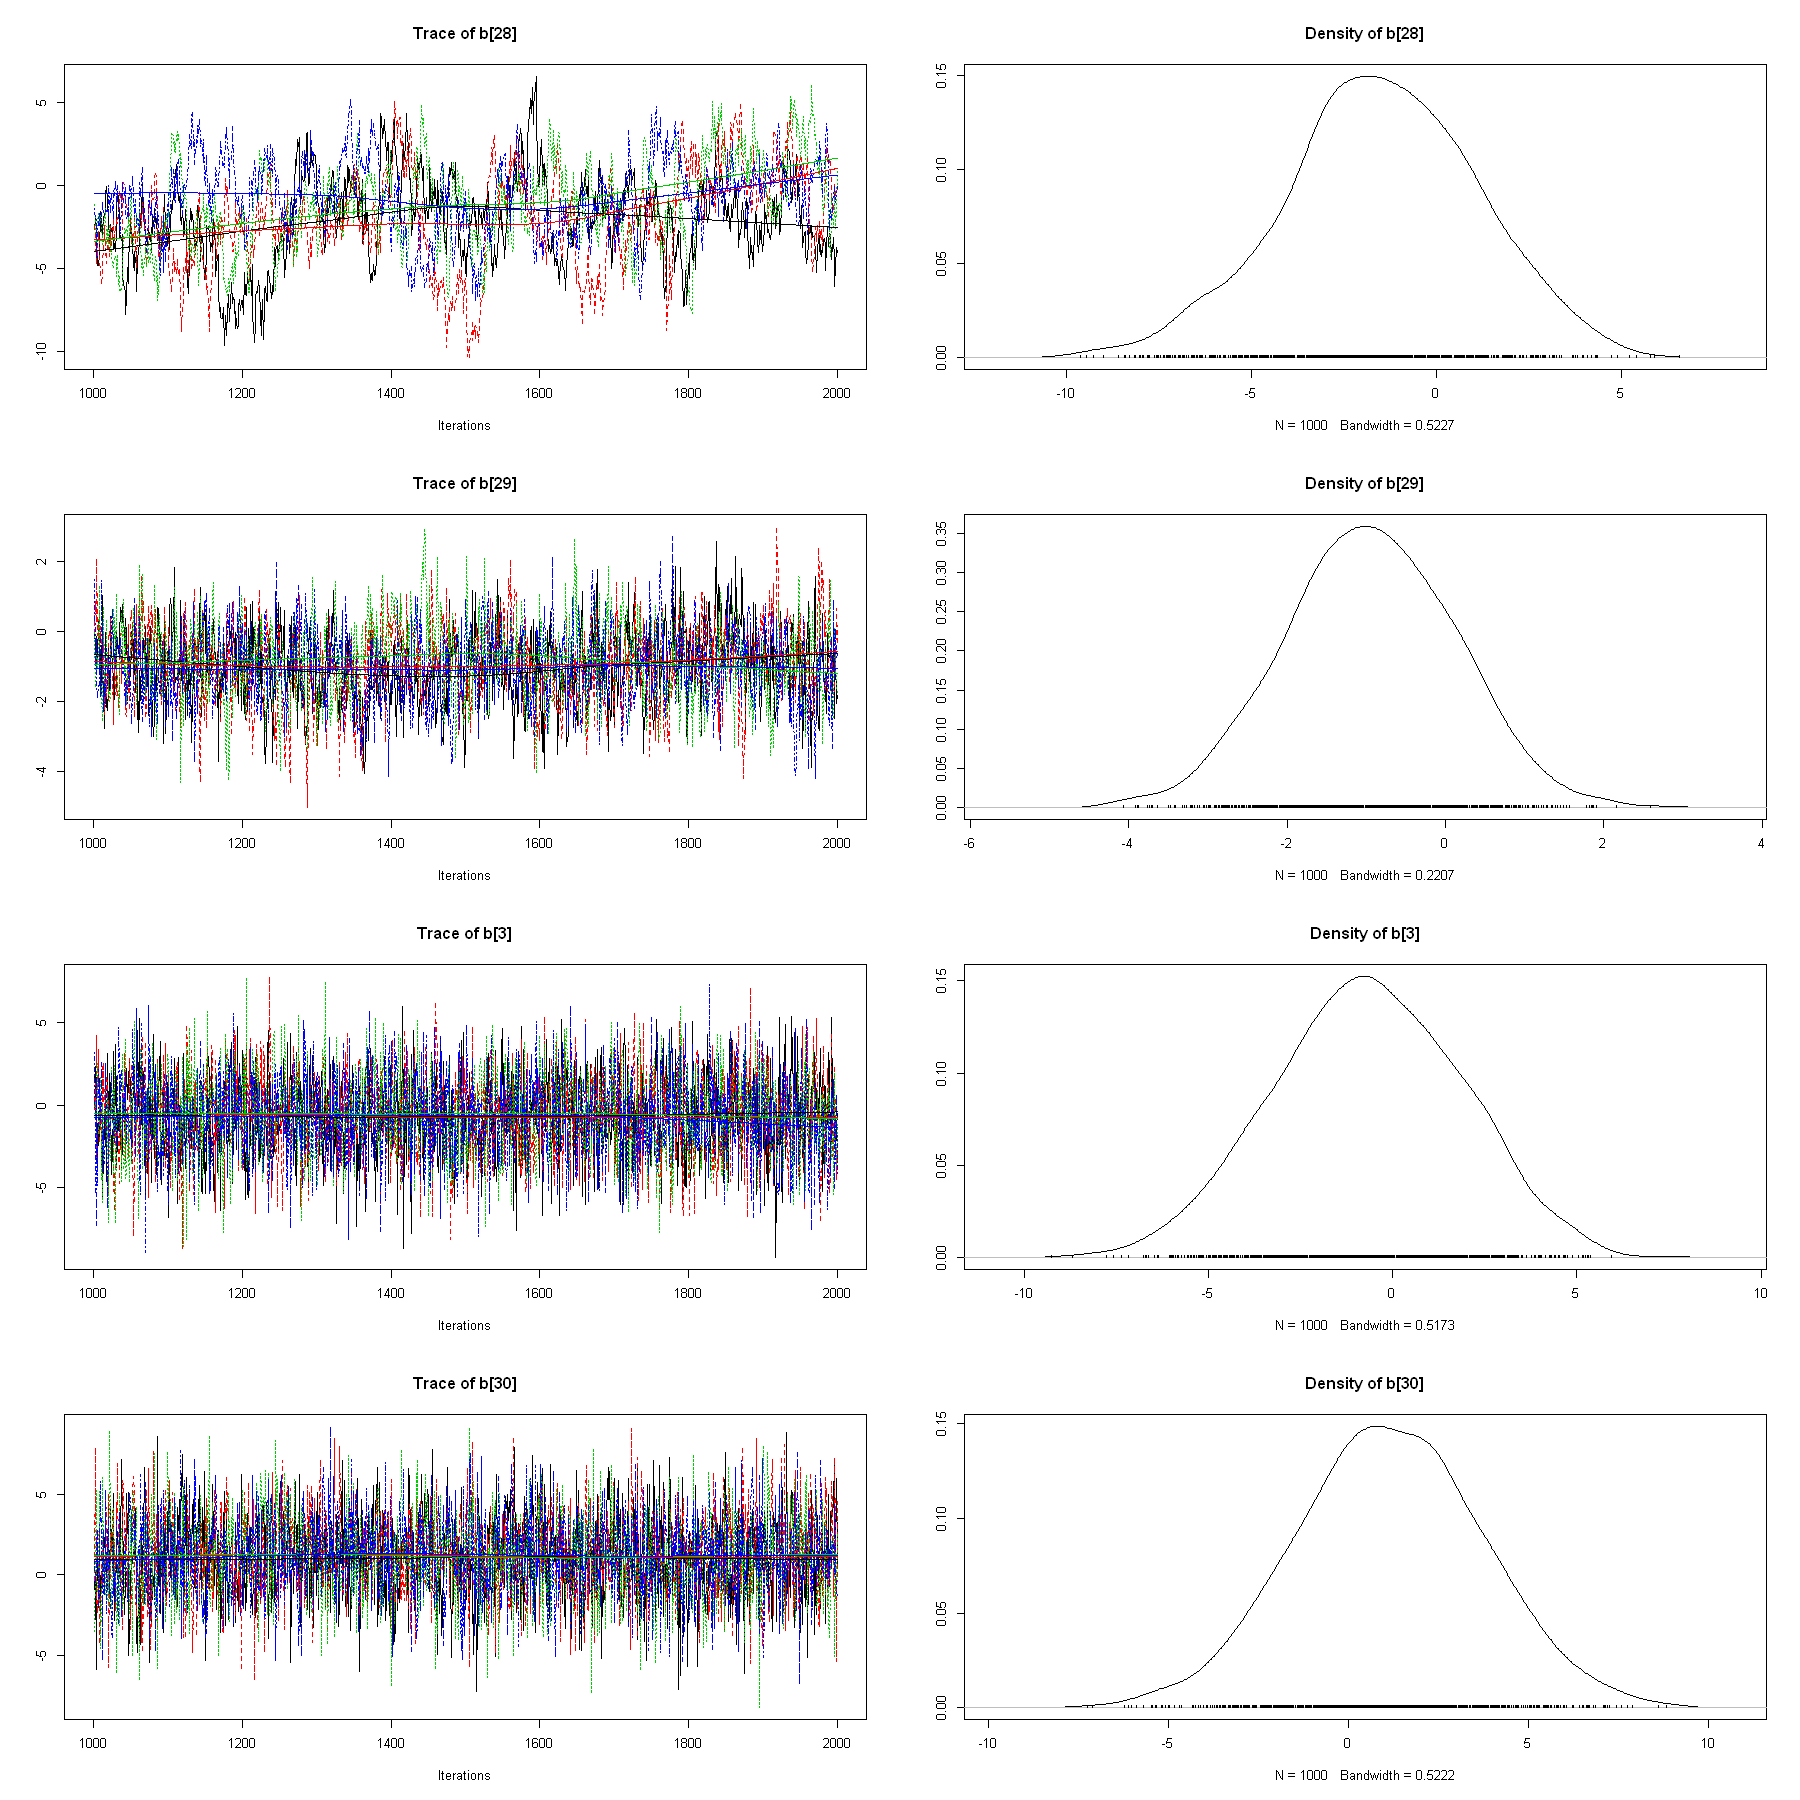

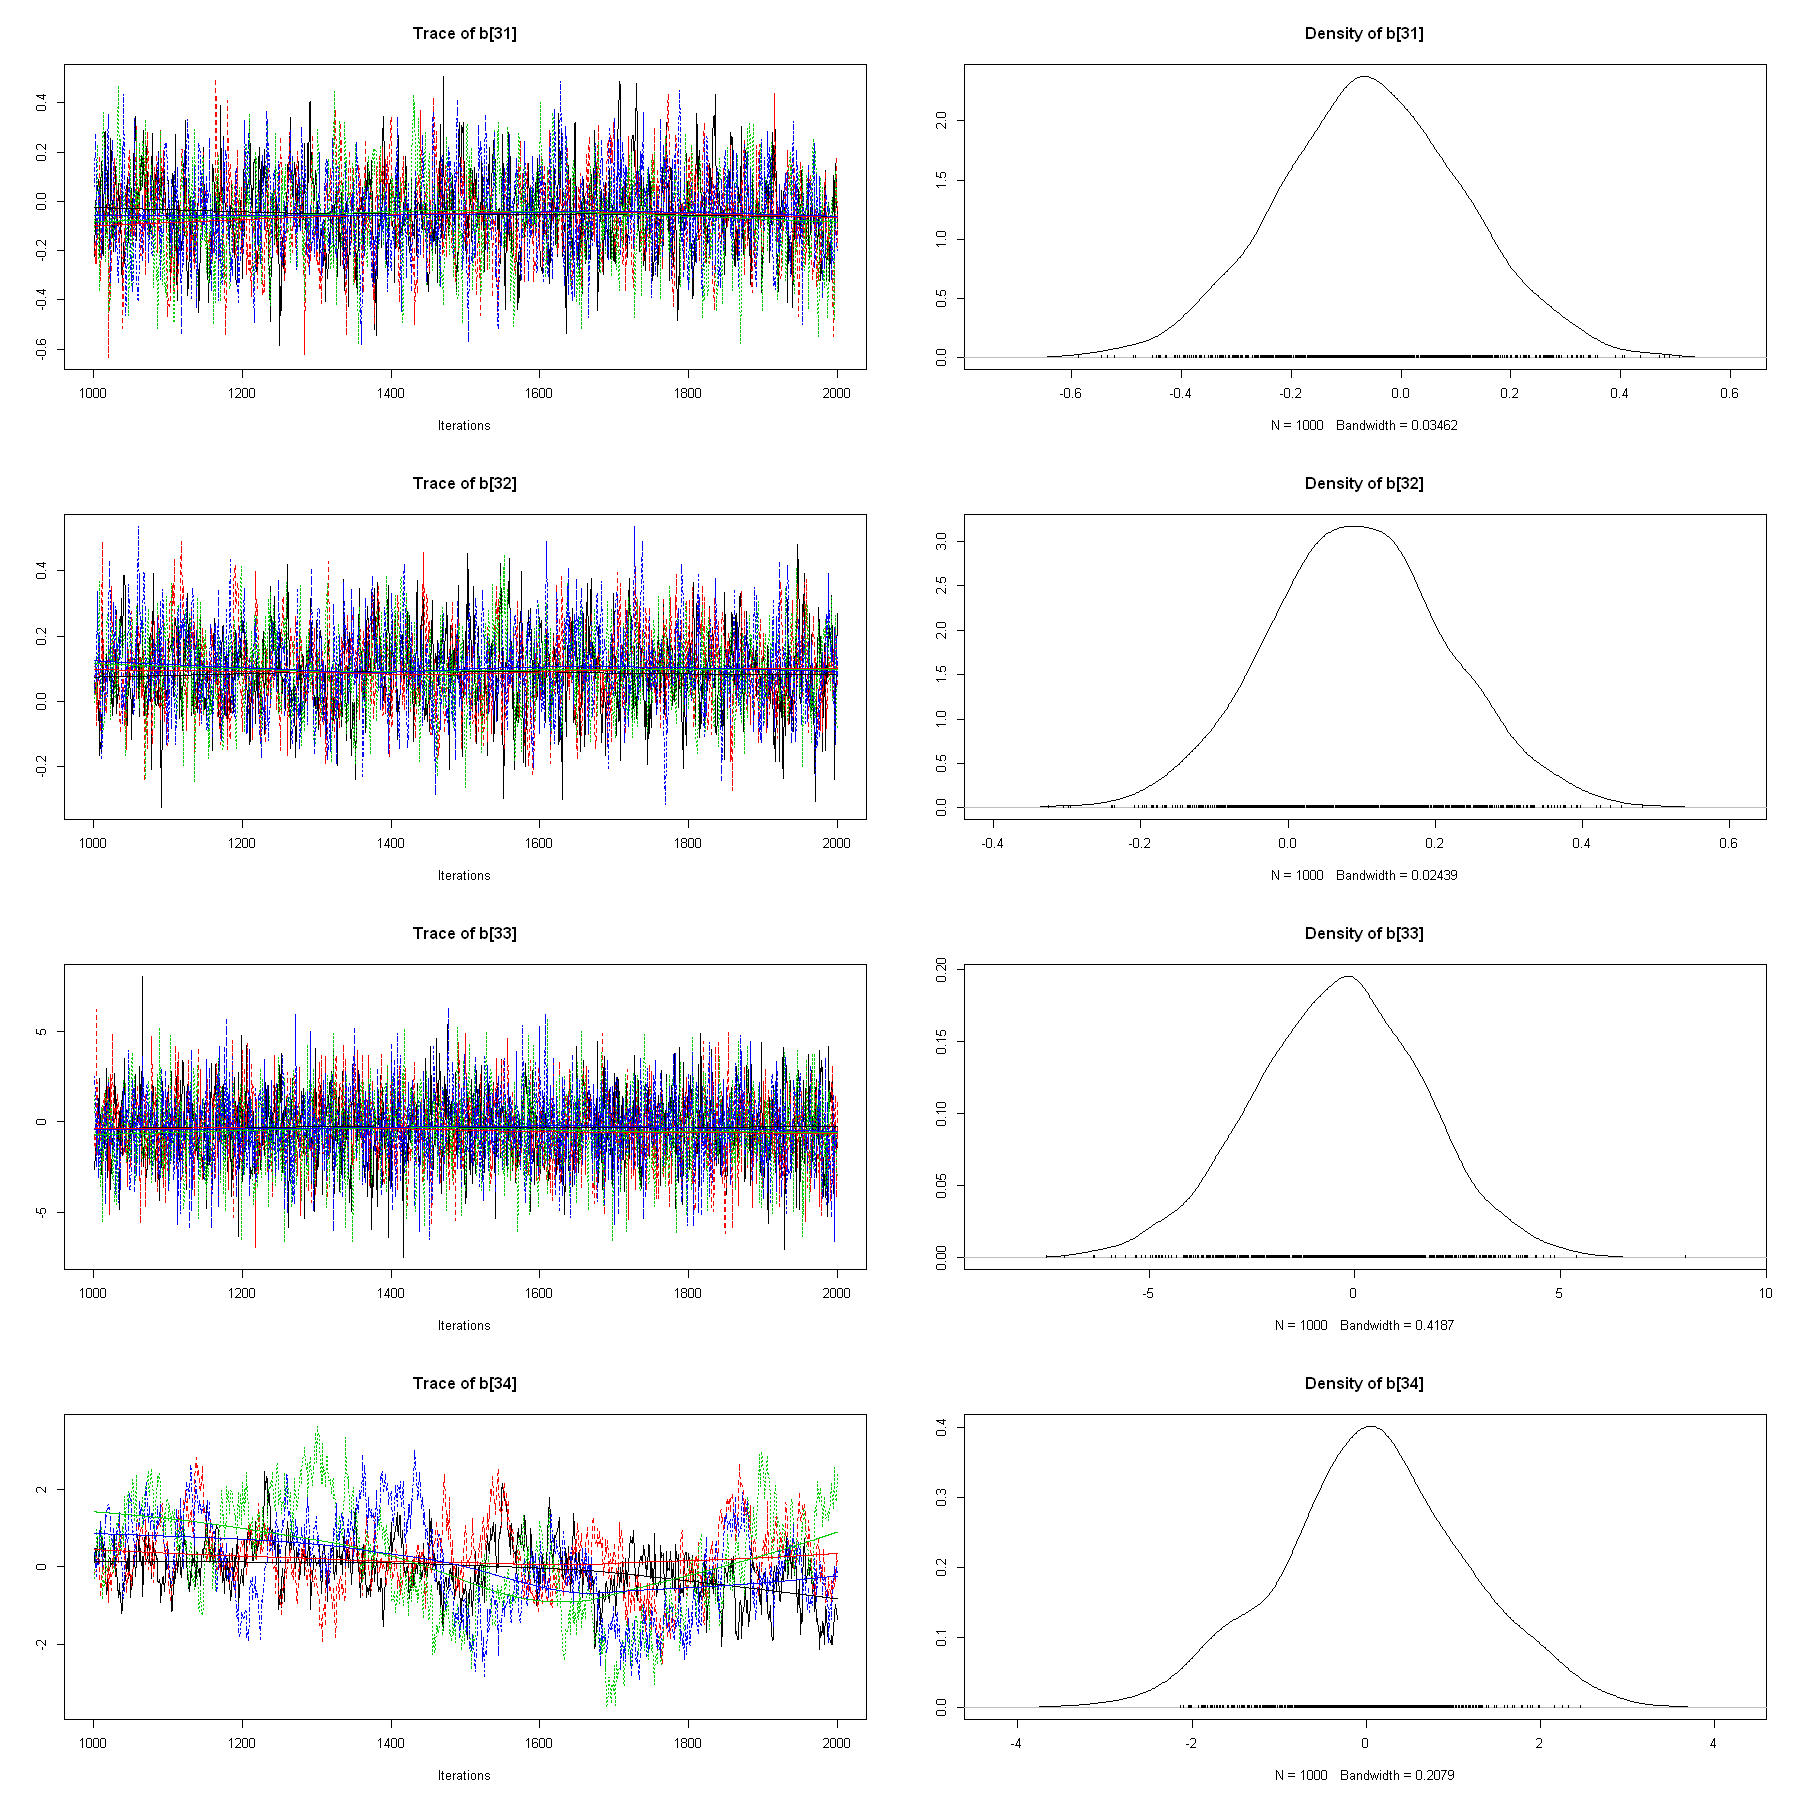

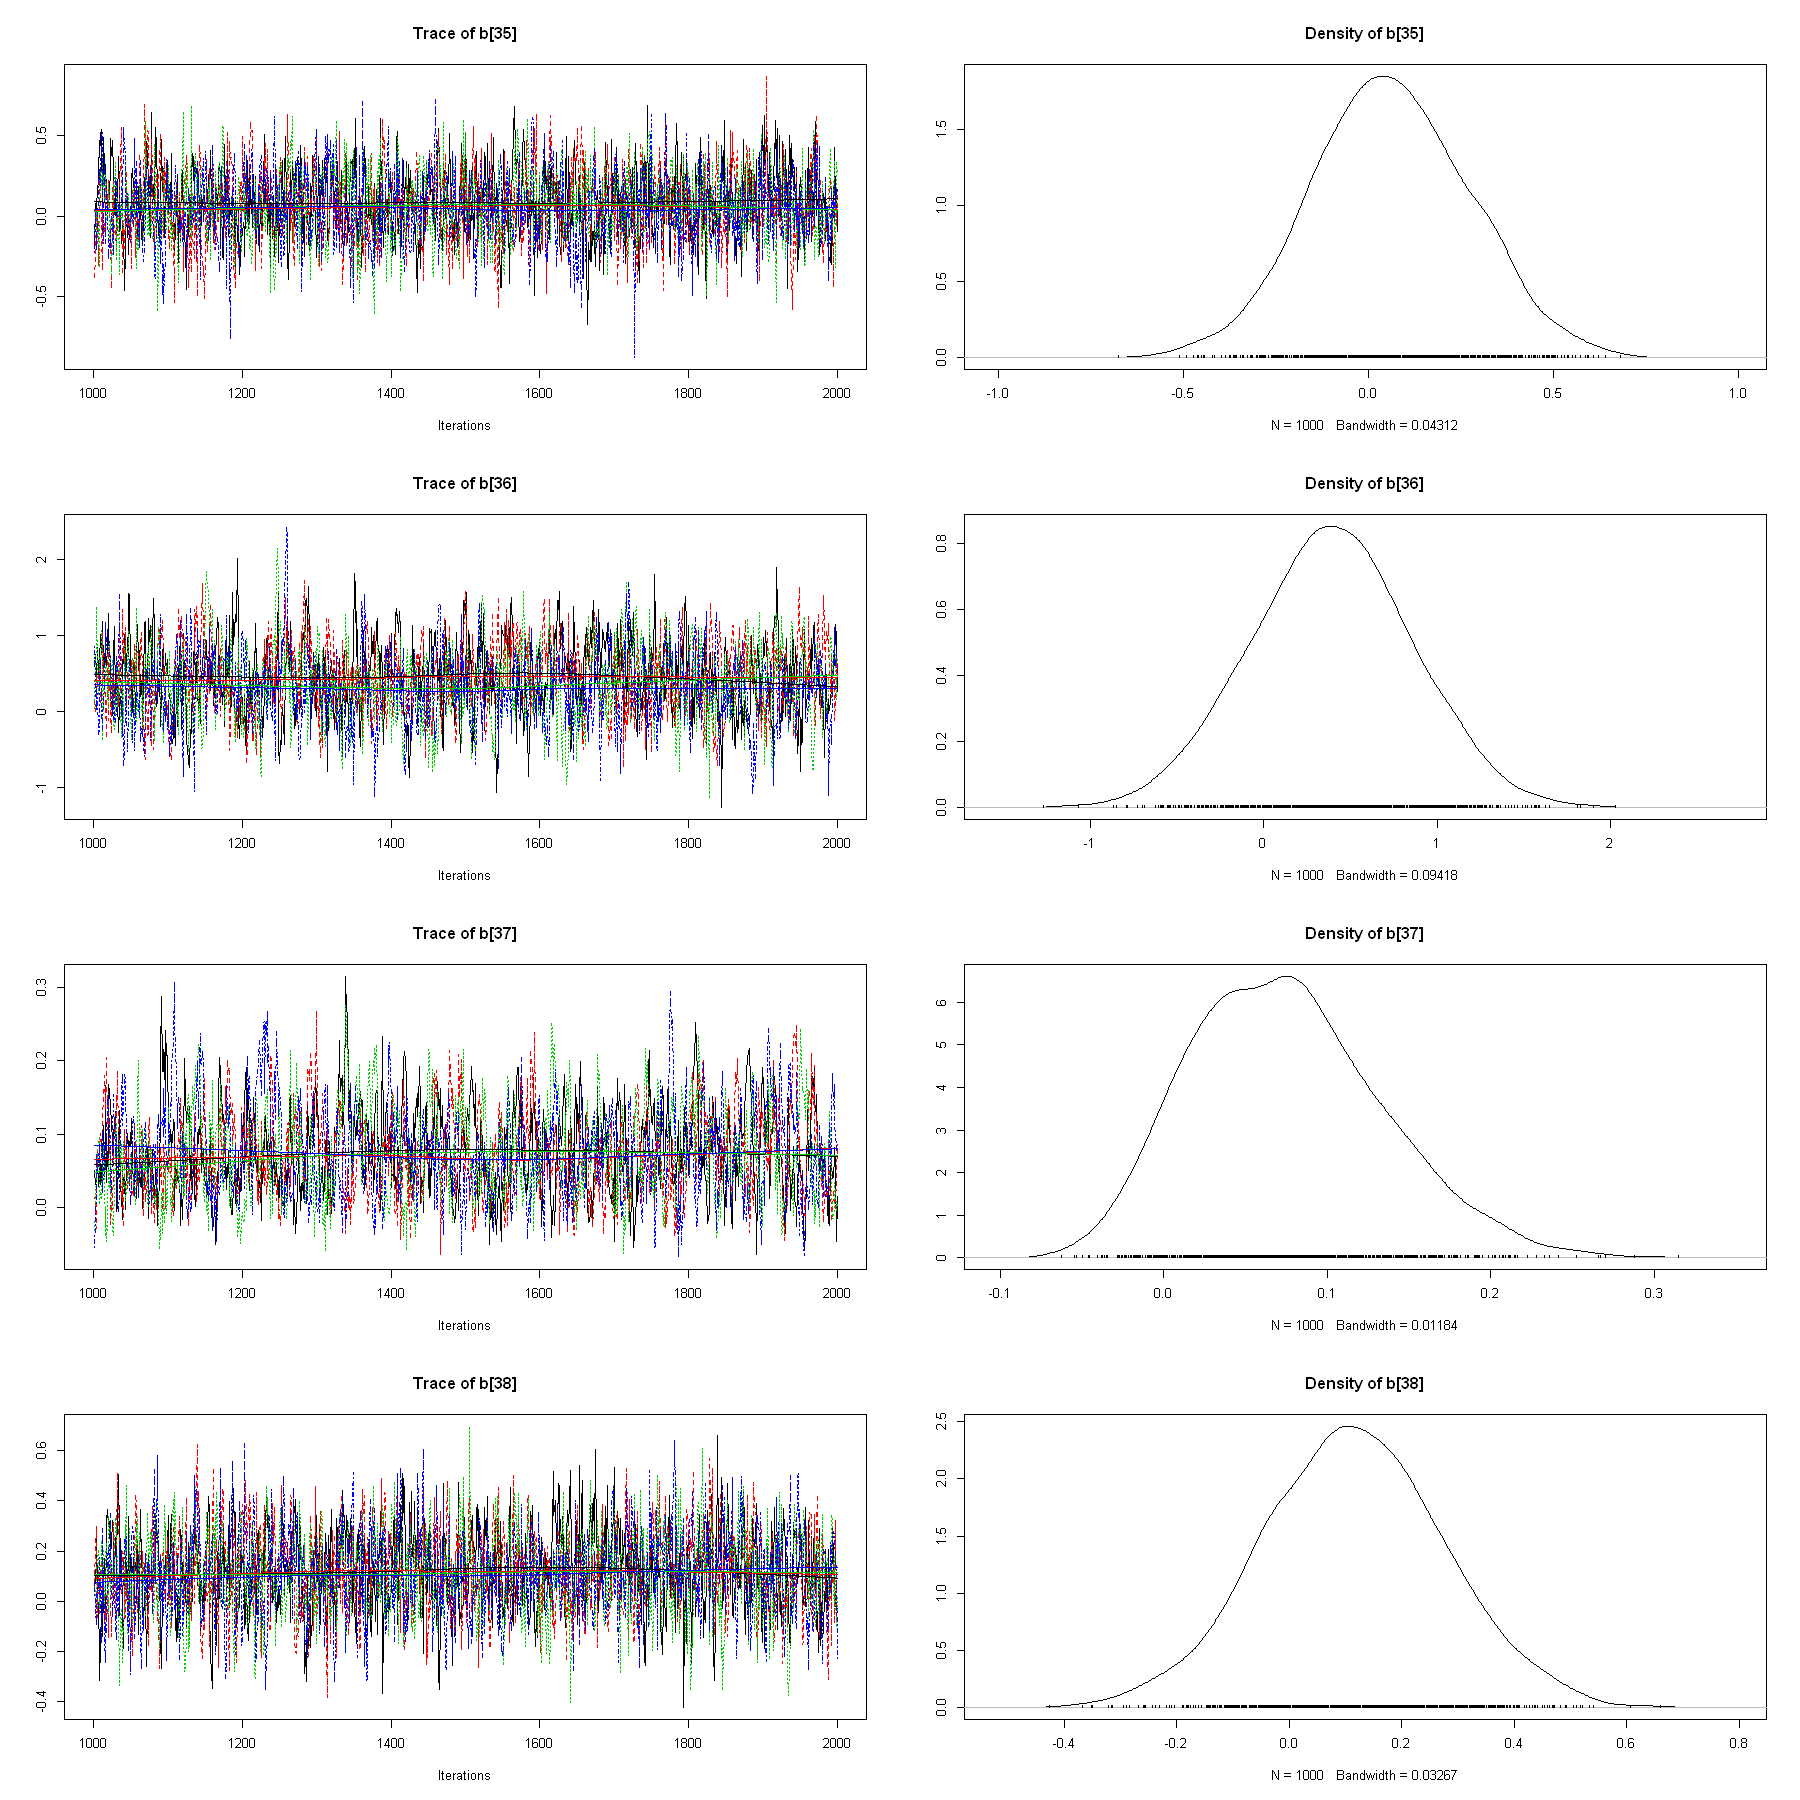

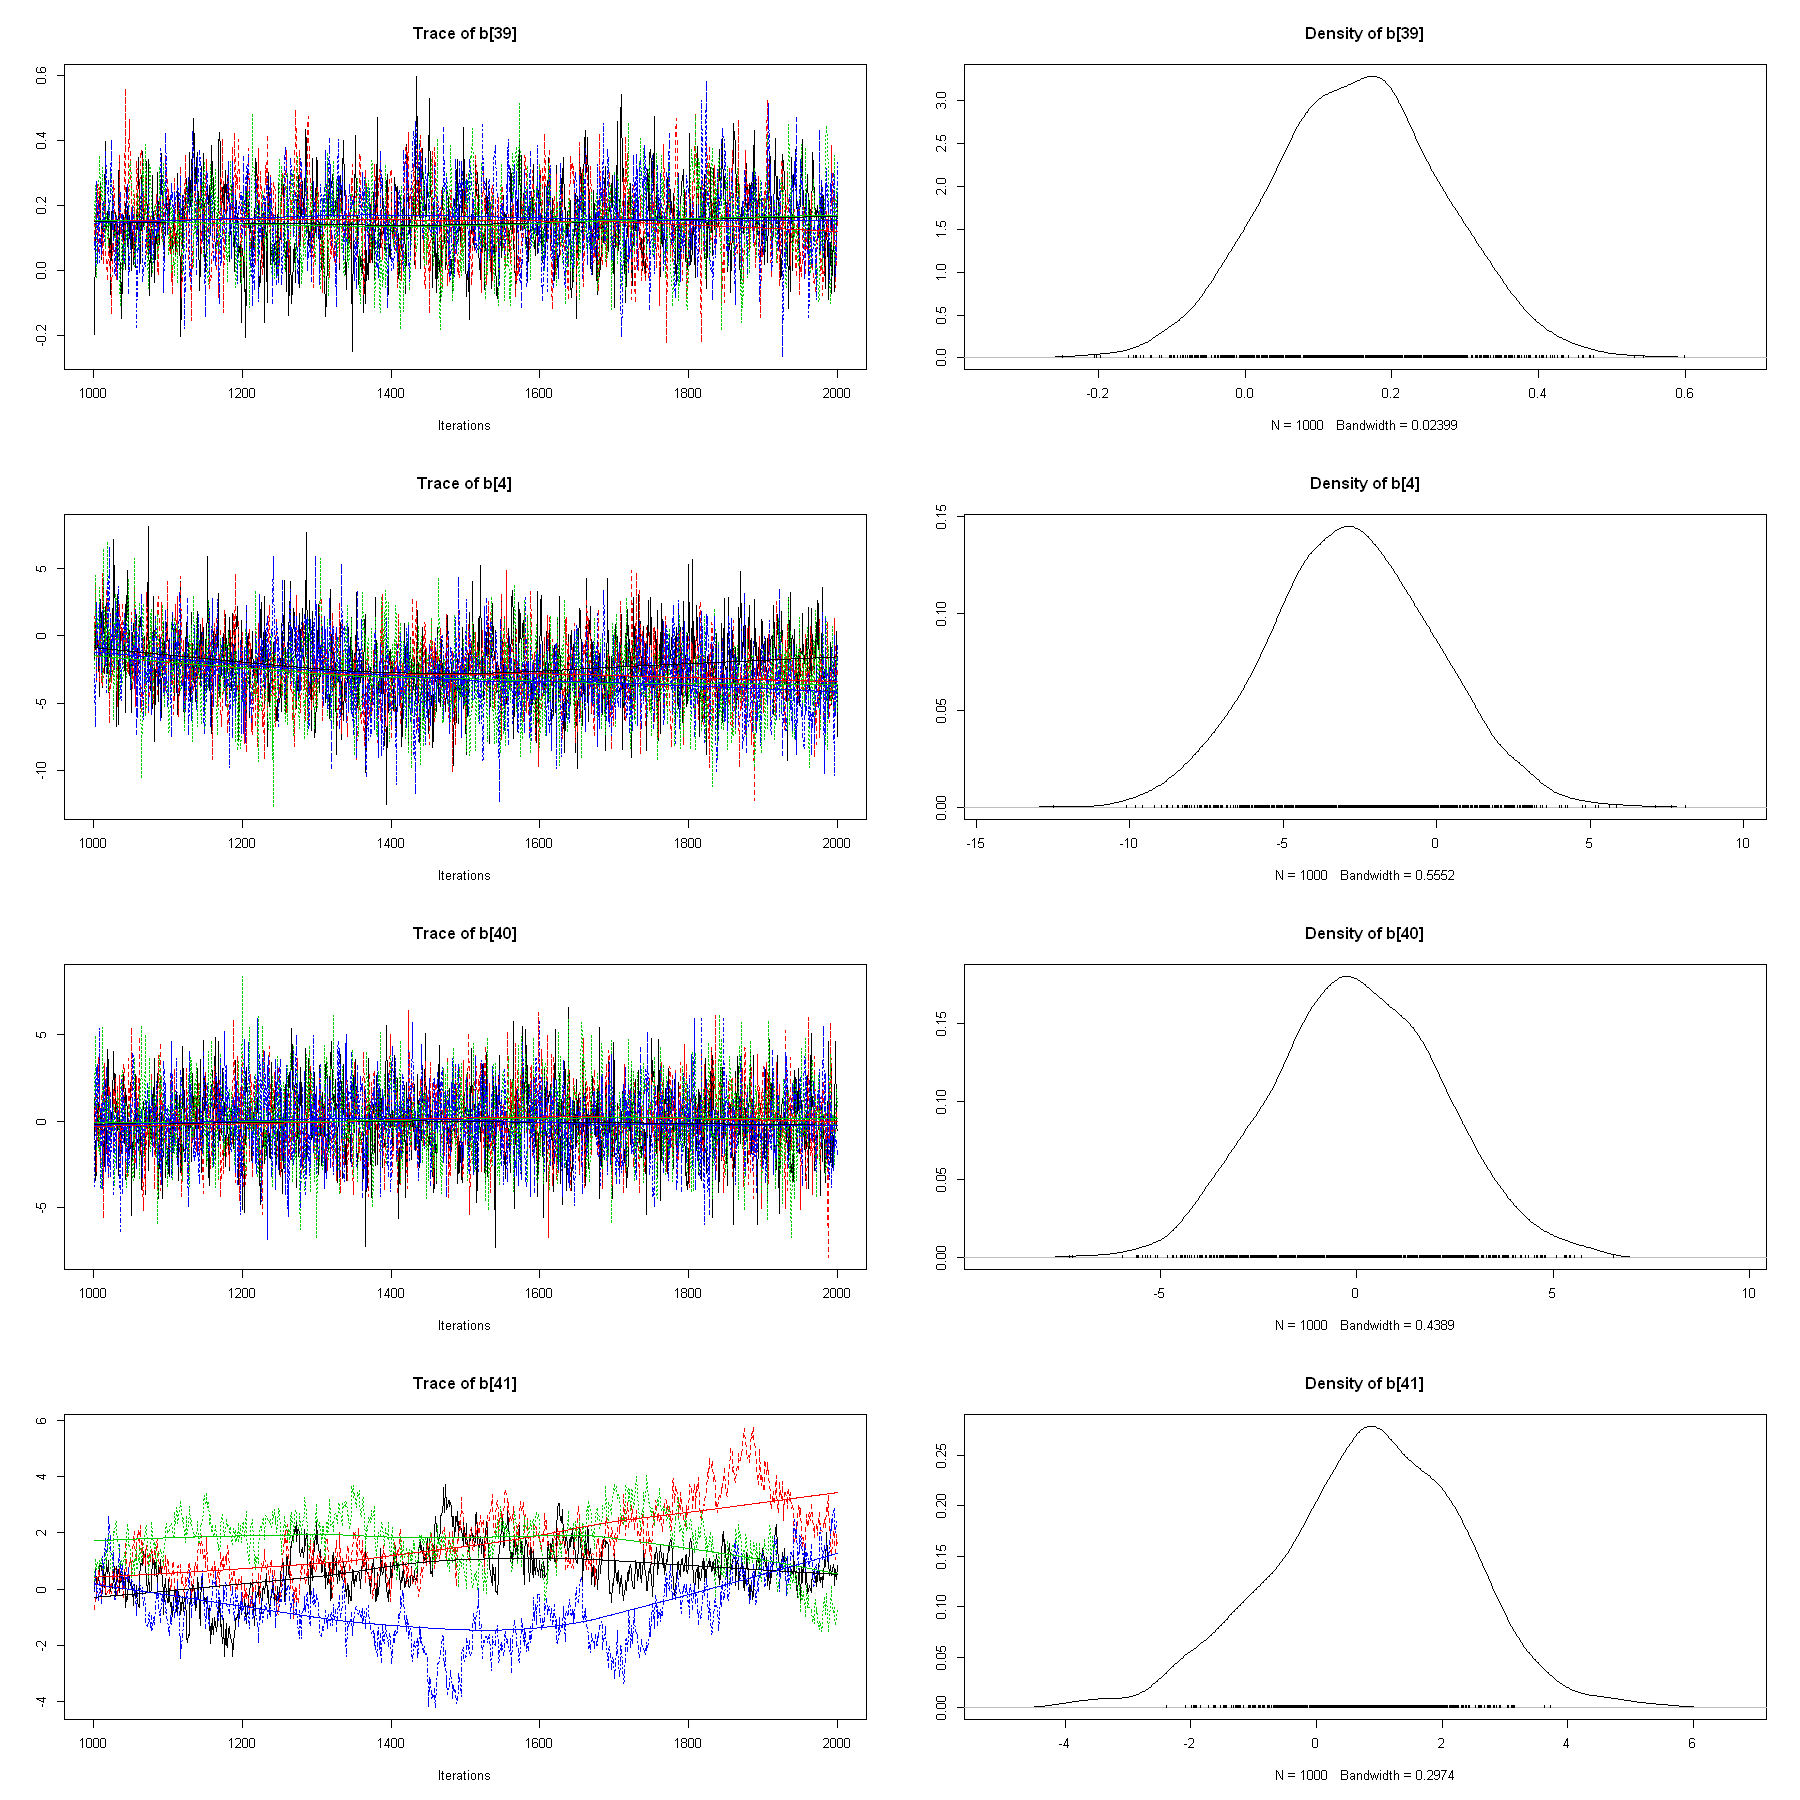

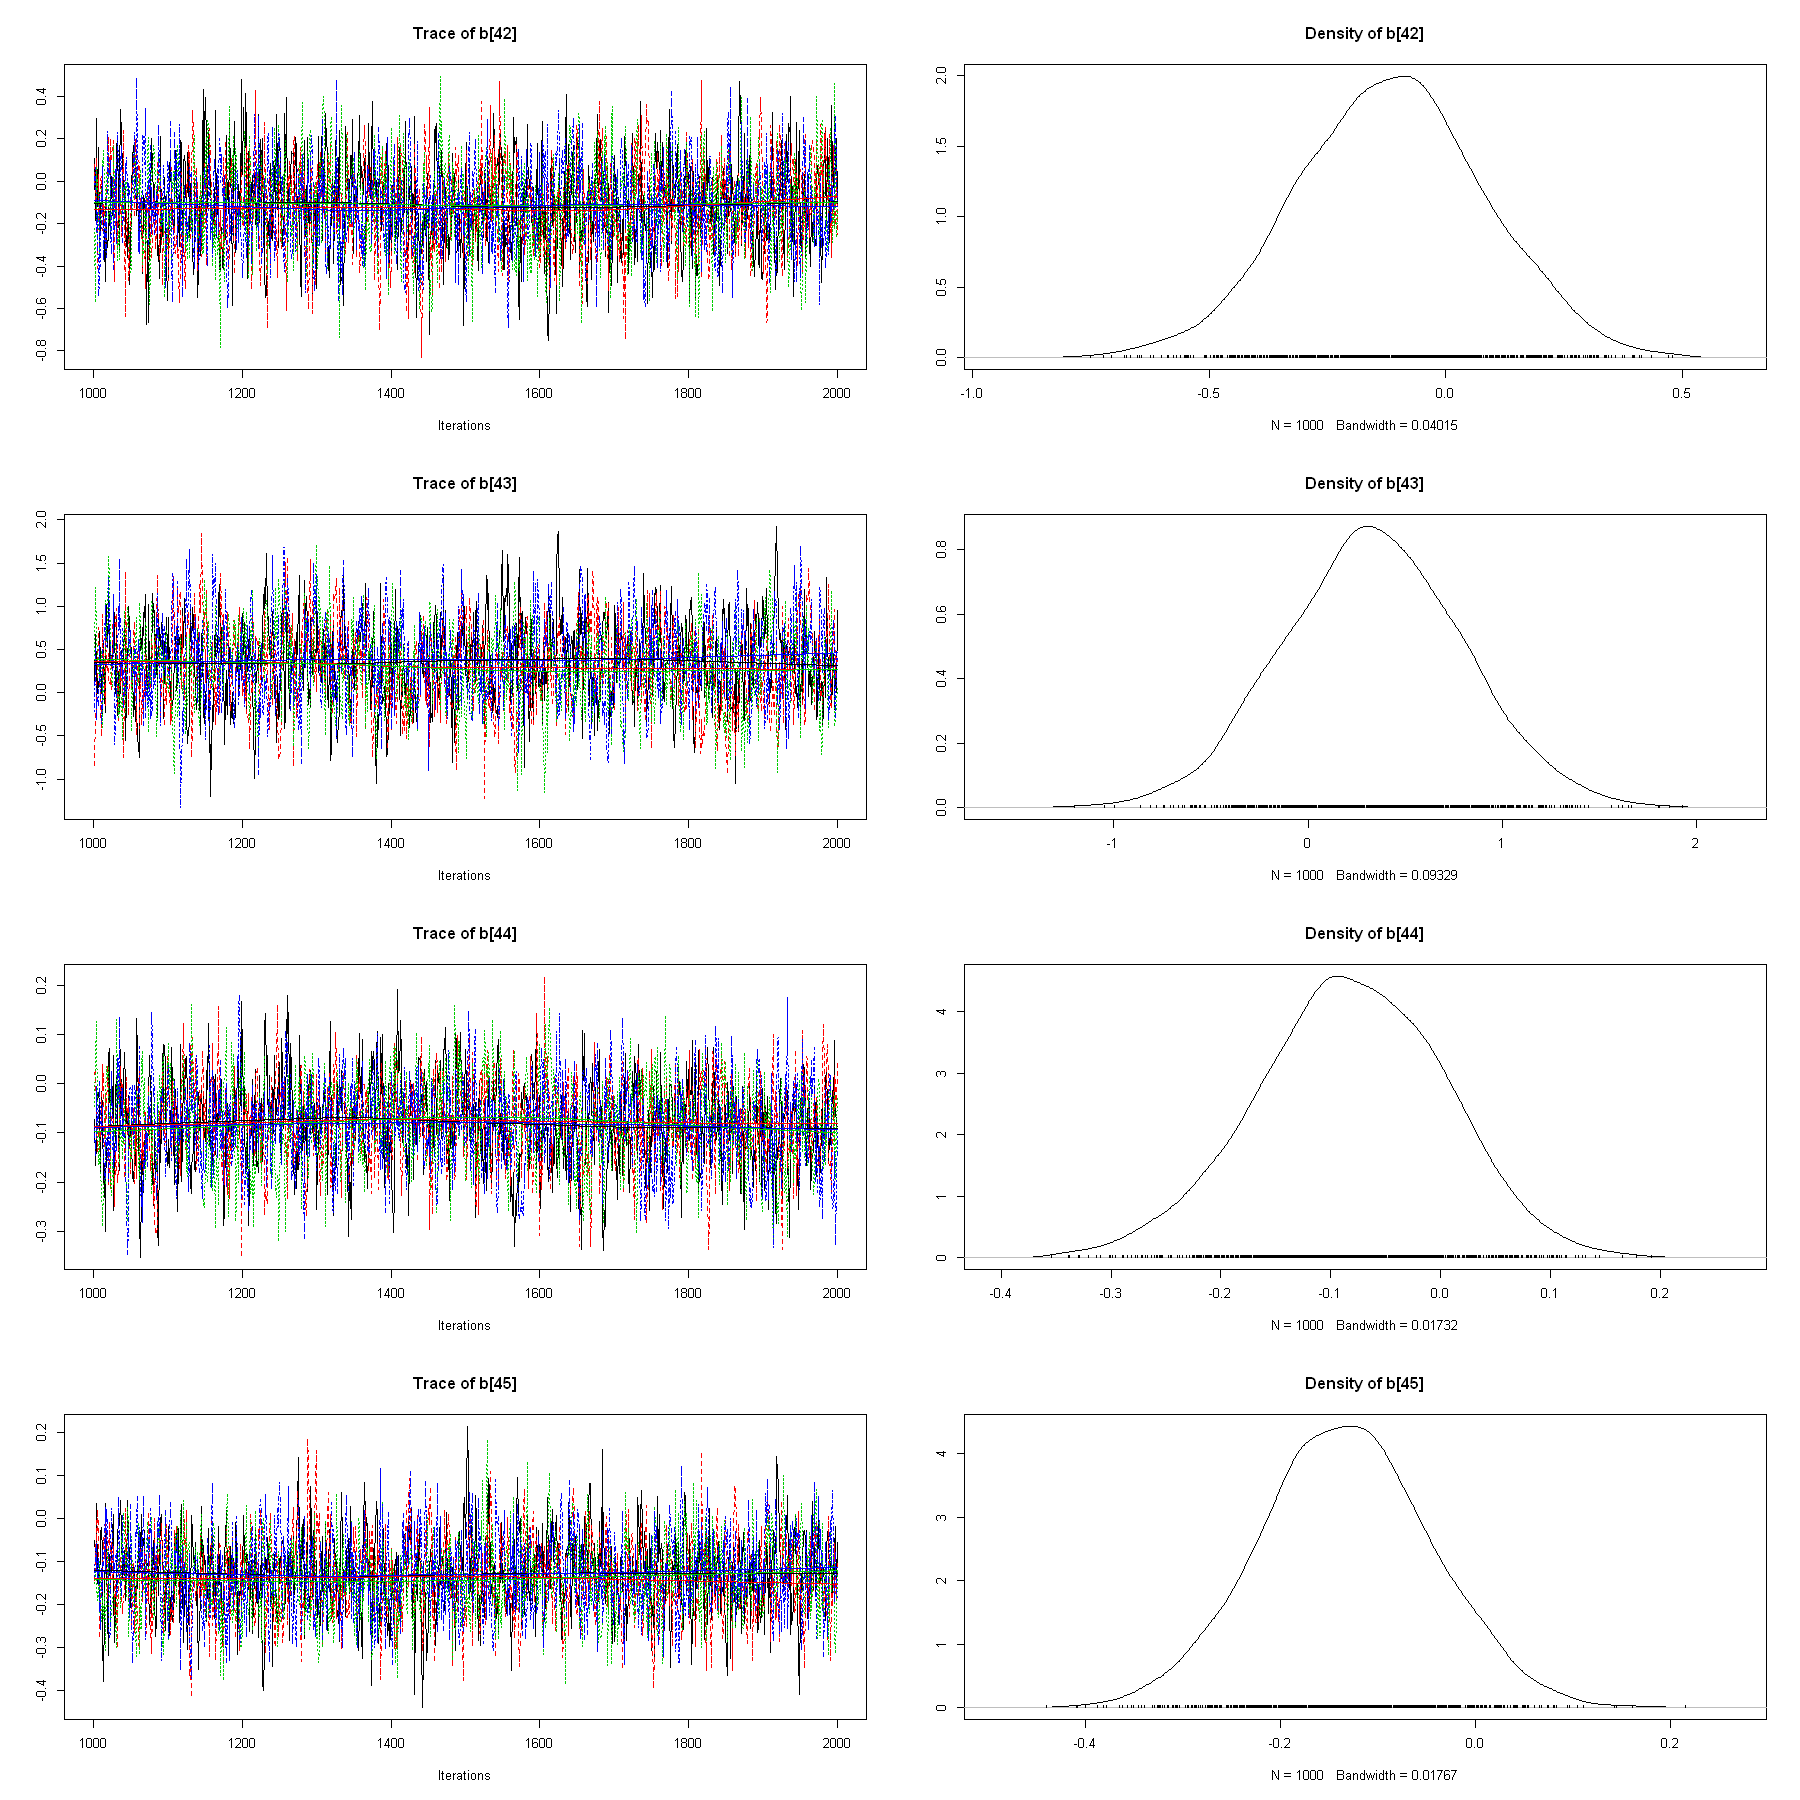

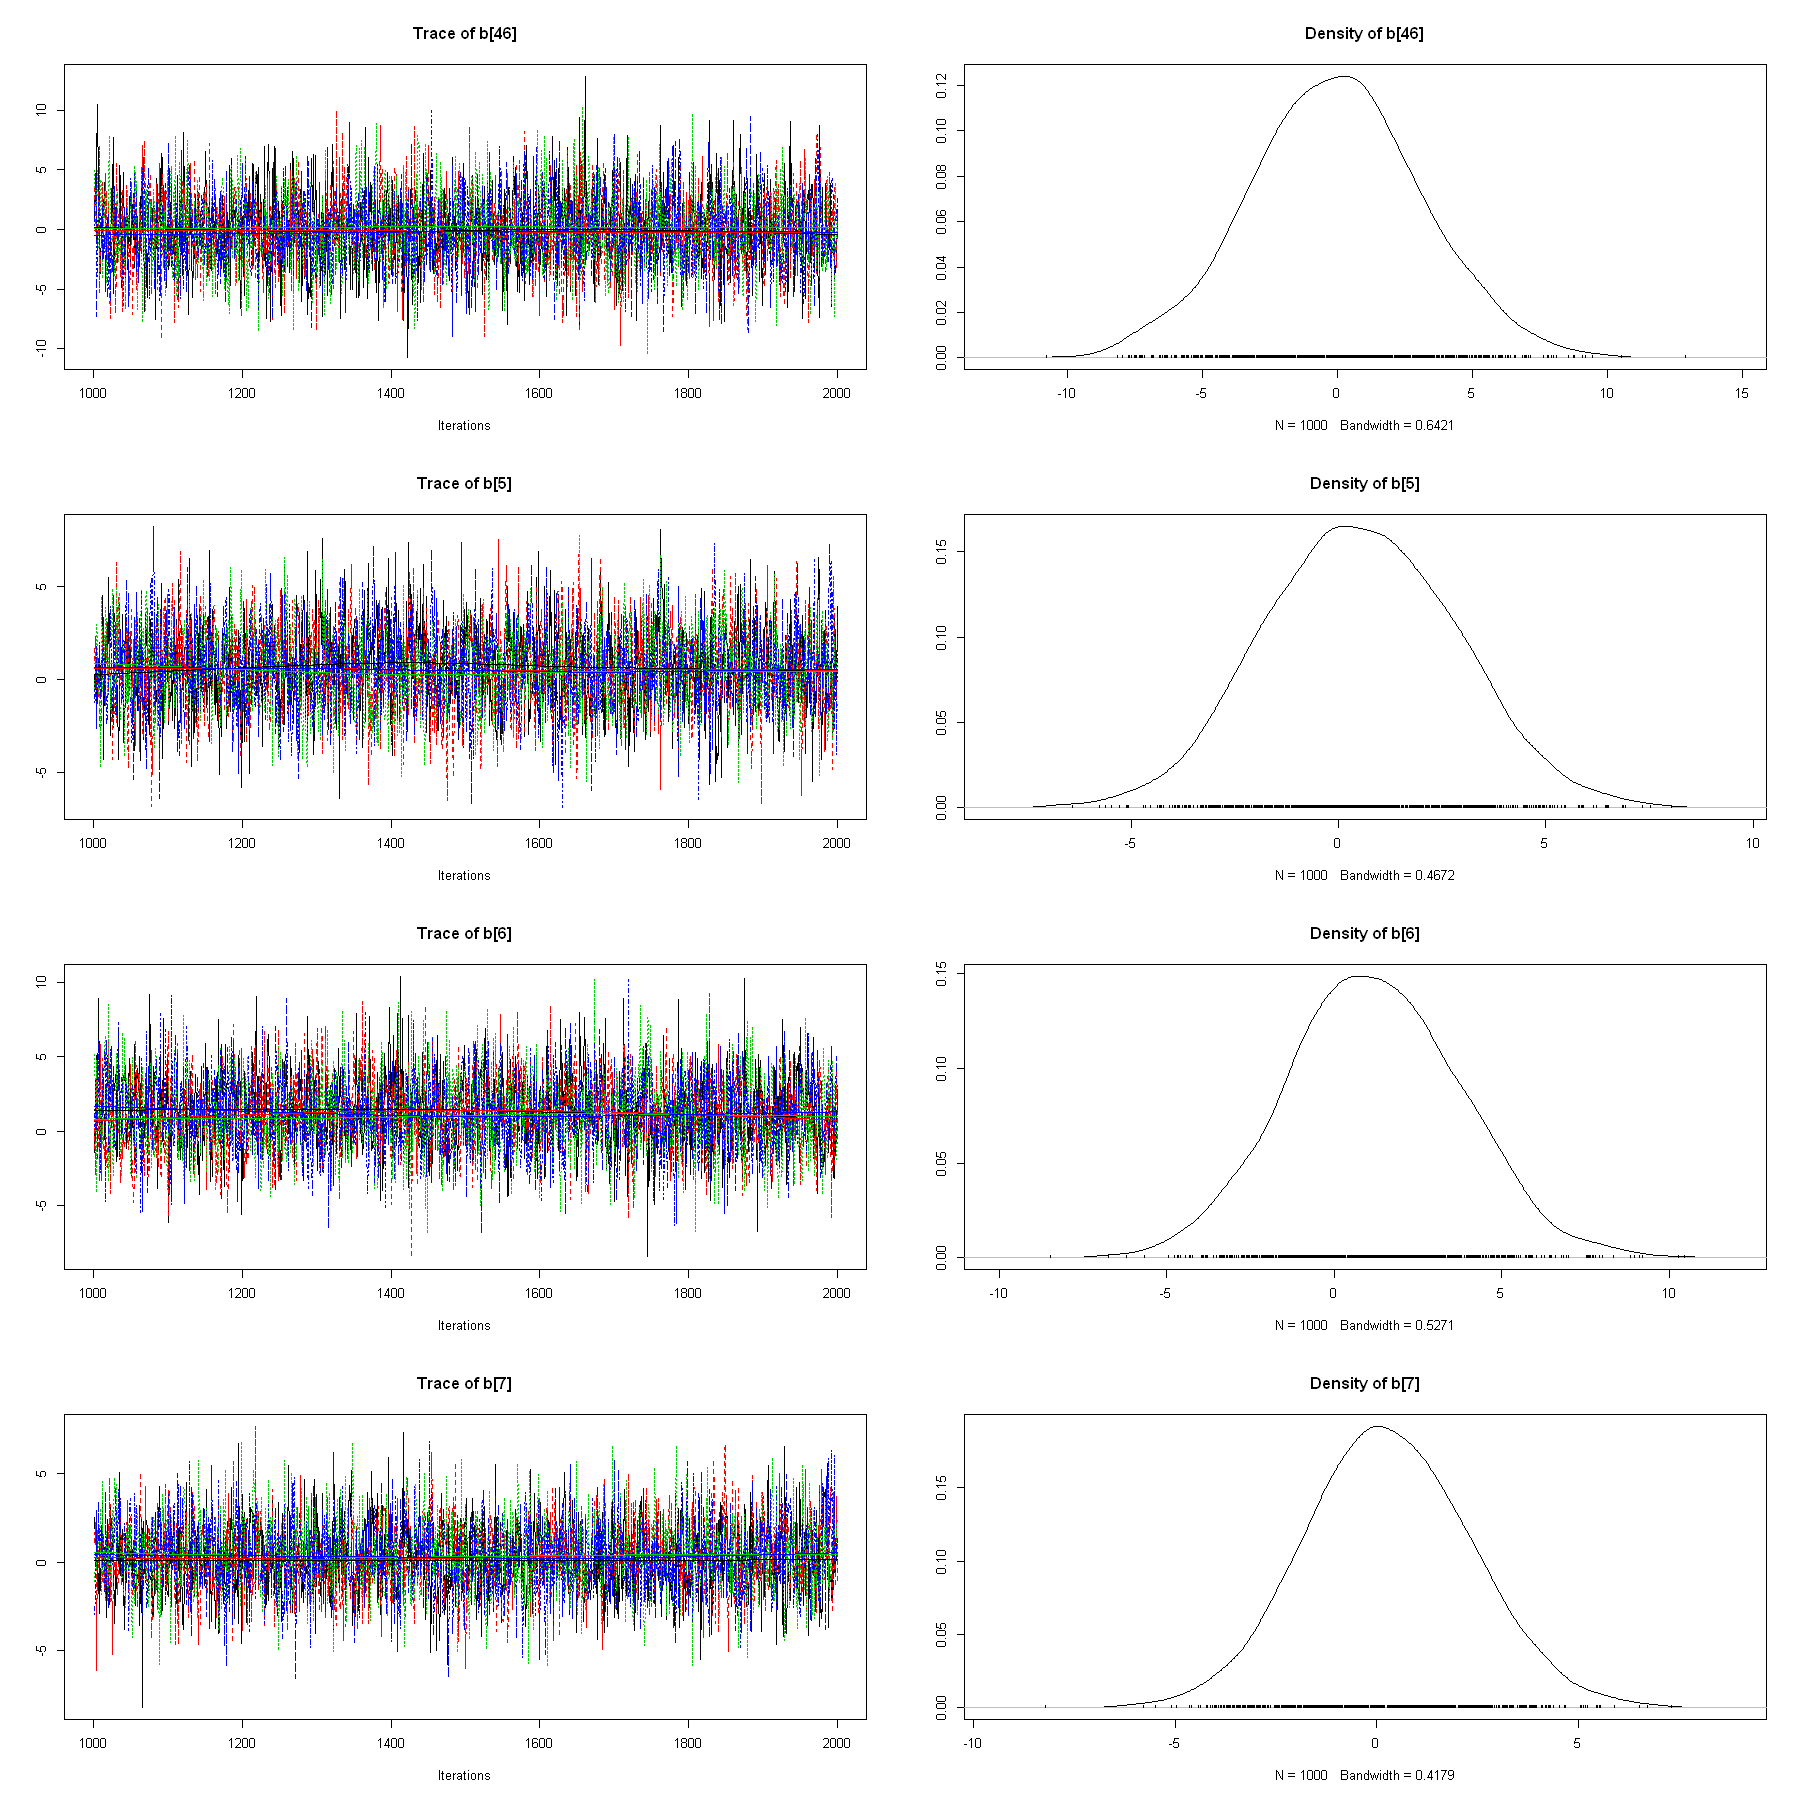

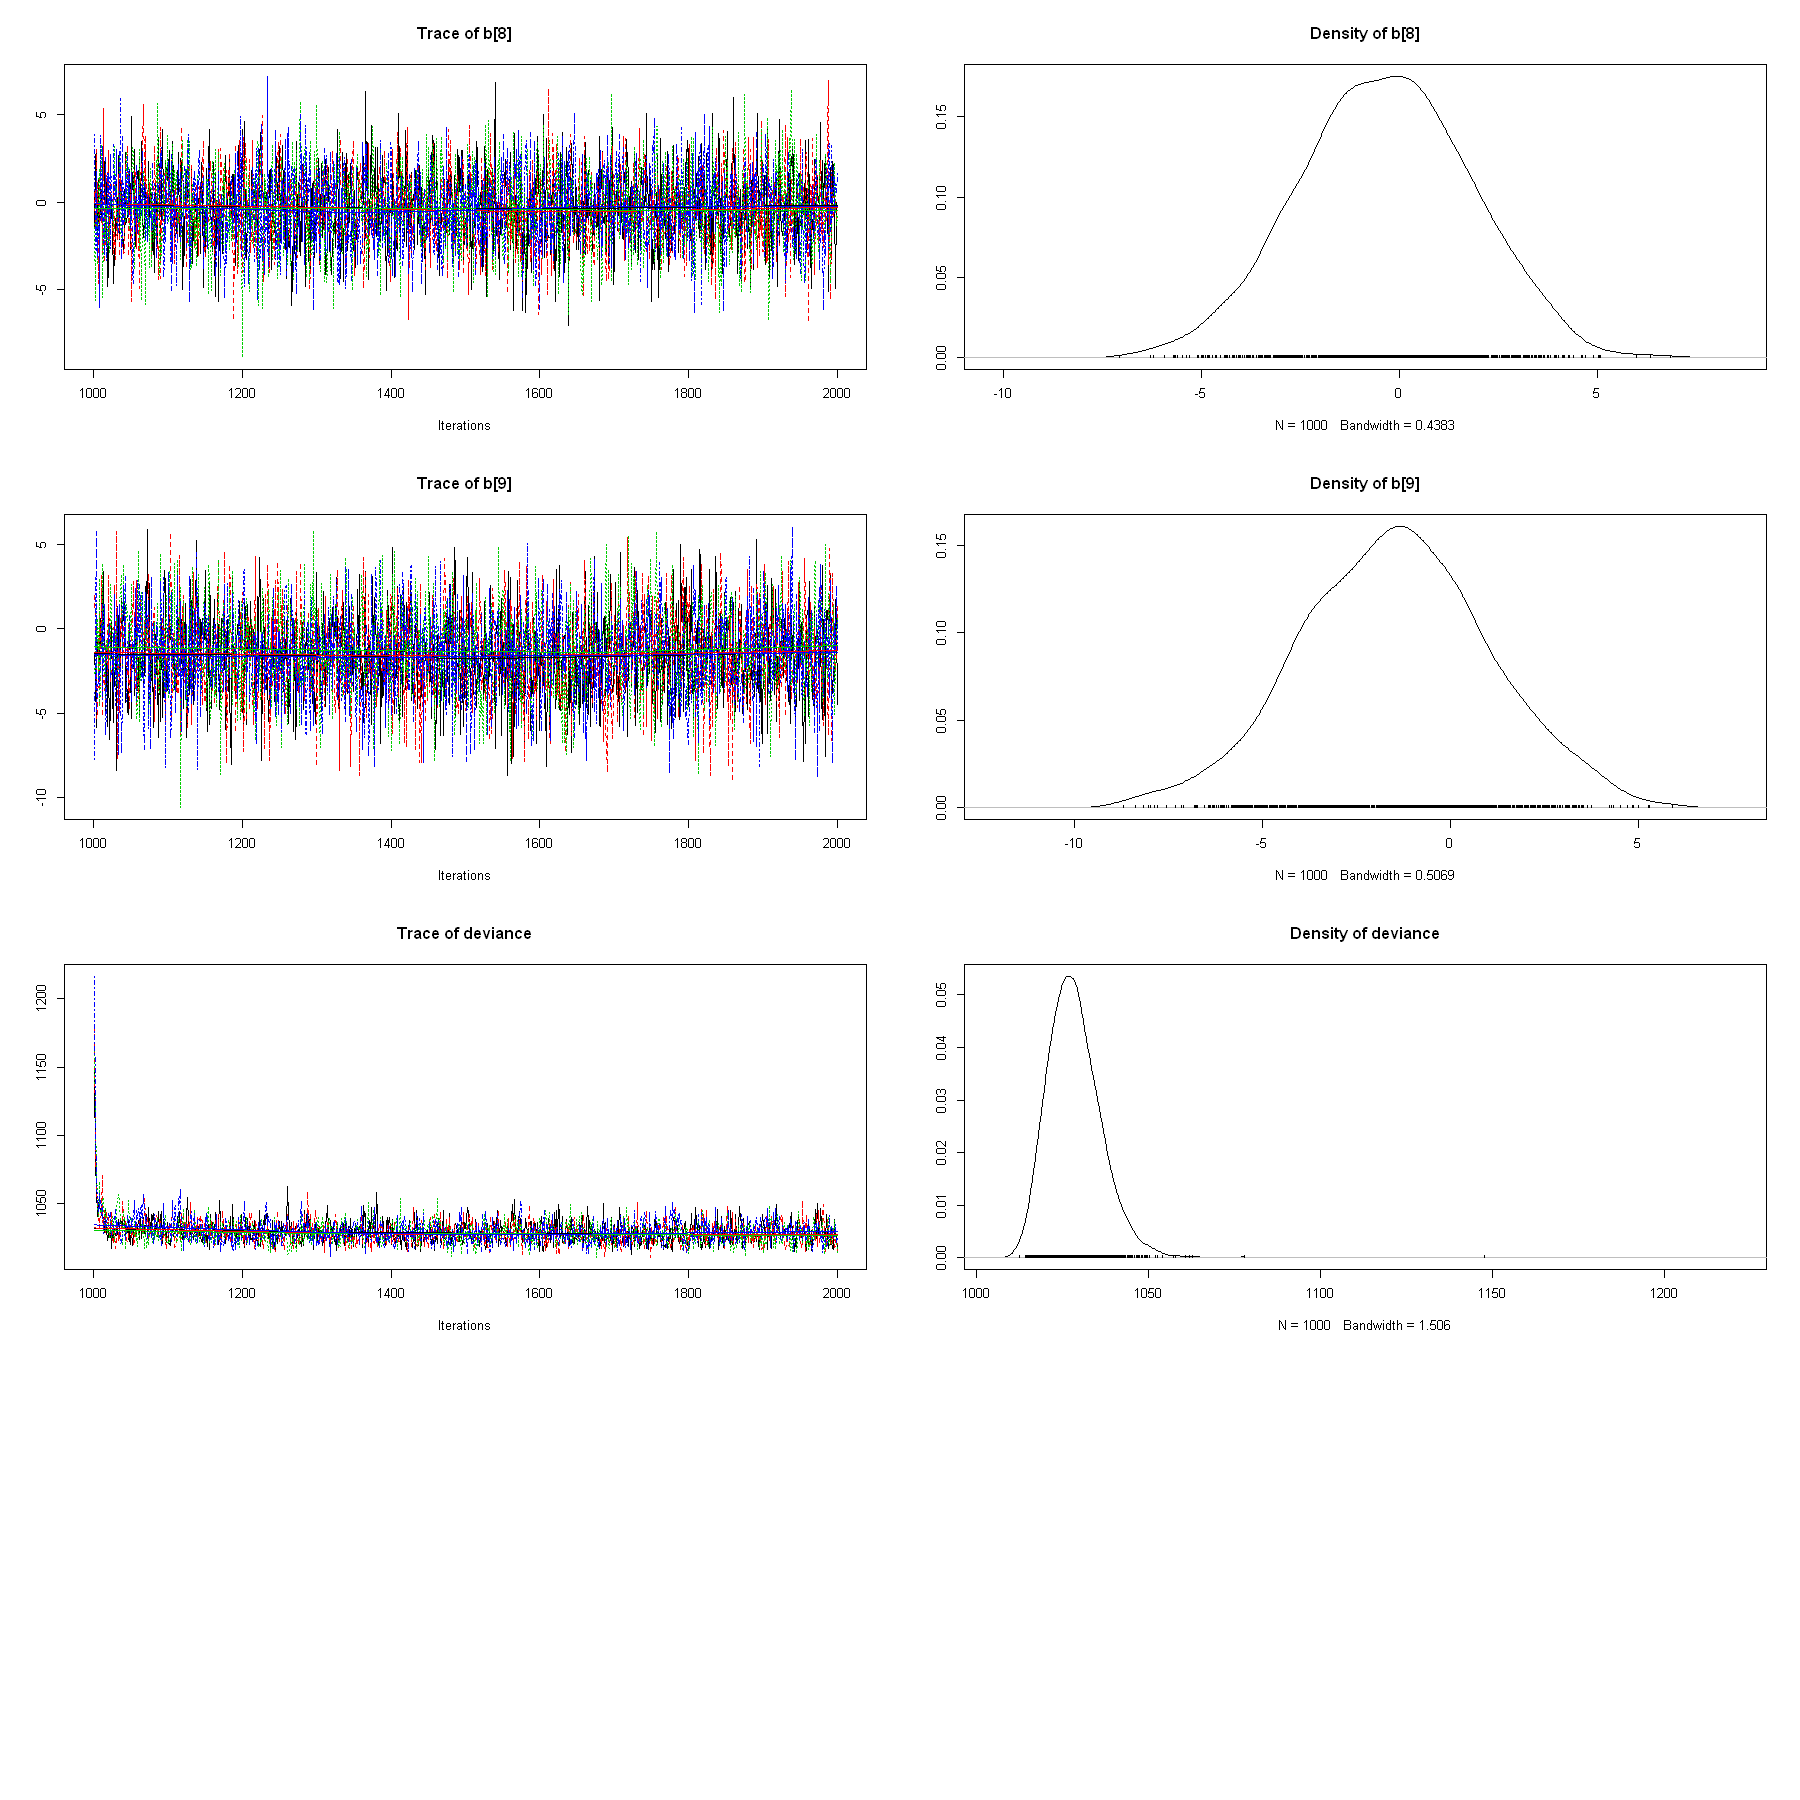

In [211]:
# Slow
out2.mcmc <- as.mcmc(jags_model2)
plot(out2.mcmc)

In [260]:
accuracies.jags2 <- mcmcRocPrc(object = jags_model2,
                       data=dfCombined,
                       yname  = "Response",
                       xnames = c('Gender','Age','Driving_License','Previously_Insured','Vehicle_Age',
                                  'Vehicle_Damage','Annual_Premium','Vintage'),
                       curves = TRUE,
                       fullsims = FALSE)

In [261]:
accuracies.jags2$area_under_roc

V1 
0.5155949

In [262]:
accuracies.jags2$area_under_prc

V1 
0.5167614

In [263]:
accuracies.jags$area_under_roc

V1 
0.8266041

In [264]:
accuracies.jags$area_under_prc

V1 
0.7474185

#### First differences

We use first differences to search the most impactful second order interaction terms

In [265]:
matstr<-paste("Response ~ ", sep="")

for (i in 1:(length(colnames(df2))-1)){
    if(col[i]!="Response")
        matstr<-paste(matstr,col[i]," + ", sep="")
}
matstr<-paste(matstr,col[i+1], sep="")
p <- parse(text = matstr)[[1]]
p

Response ~ Gender + Age + Driving_License + Previously_Insured + 
    Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage + 
    GenderXGender + AgeXGender + AgeXAge + Driving_LicenseXGender + 
    Driving_LicenseXAge + Driving_LicenseXDriving_License + Previously_InsuredXGender + 
    Previously_InsuredXAge + Previously_InsuredXDriving_License + 
    Previously_InsuredXPreviously_Insured + Vehicle_AgeXGender + 
    Vehicle_AgeXAge + Vehicle_AgeXDriving_License + Vehicle_AgeXPreviously_Insured + 
    Vehicle_AgeXVehicle_Age + Vehicle_DamageXGender + Vehicle_DamageXAge + 
    Vehicle_DamageXDriving_License + Vehicle_DamageXPreviously_Insured + 
    Vehicle_DamageXVehicle_Age + Vehicle_DamageXVehicle_Damage + 
    Annual_PremiumXGender + Annual_PremiumXAge + Annual_PremiumXDriving_License + 
    Annual_PremiumXPreviously_Insured + Annual_PremiumXVehicle_Age + 
    Annual_PremiumXVehicle_Damage + Annual_PremiumXAnnual_Premium + 
    VintageXGender + VintageXAge + VintageXDriving_Licen

In [266]:
matrix_jags2 <- as.matrix(coda::as.mcmc(jags_model2))

In [267]:
mm.jags2 <- model.matrix(Response ~ Gender + Age + Driving_License + Previously_Insured + 
    Vehicle_Age + Vehicle_Damage + Annual_Premium + Vintage + 
    GenderXGender + AgeXGender + AgeXAge + Driving_LicenseXGender + 
    Driving_LicenseXAge + Driving_LicenseXDriving_License + Previously_InsuredXGender + 
    Previously_InsuredXAge + Previously_InsuredXDriving_License + 
    Previously_InsuredXPreviously_Insured + Vehicle_AgeXGender + 
    Vehicle_AgeXAge + Vehicle_AgeXDriving_License + Vehicle_AgeXPreviously_Insured + 
    Vehicle_AgeXVehicle_Age + Vehicle_DamageXGender + Vehicle_DamageXAge + 
    Vehicle_DamageXDriving_License + Vehicle_DamageXPreviously_Insured + 
    Vehicle_DamageXVehicle_Age + Vehicle_DamageXVehicle_Damage + 
    Annual_PremiumXGender + Annual_PremiumXAge + Annual_PremiumXDriving_License + 
    Annual_PremiumXPreviously_Insured + Annual_PremiumXVehicle_Age + 
    Annual_PremiumXVehicle_Damage + Annual_PremiumXAnnual_Premium + 
    VintageXGender + VintageXAge + VintageXDriving_License + 
    VintageXPreviously_Insured + VintageXVehicle_Age + VintageXVehicle_Damage + 
    VintageXAnnual_Premium + VintageXVintage,
                   data = df2)

In [268]:
first_difference.jags2 <- mcmcFD(modelmatrix = mm.jags2,
                  mcmcout = matrix_jags2[, 1:ncol(mm.jags2)],
                  link = "logit",
                  ci = c(0.025, 0.975),
                  fullsims = FALSE)

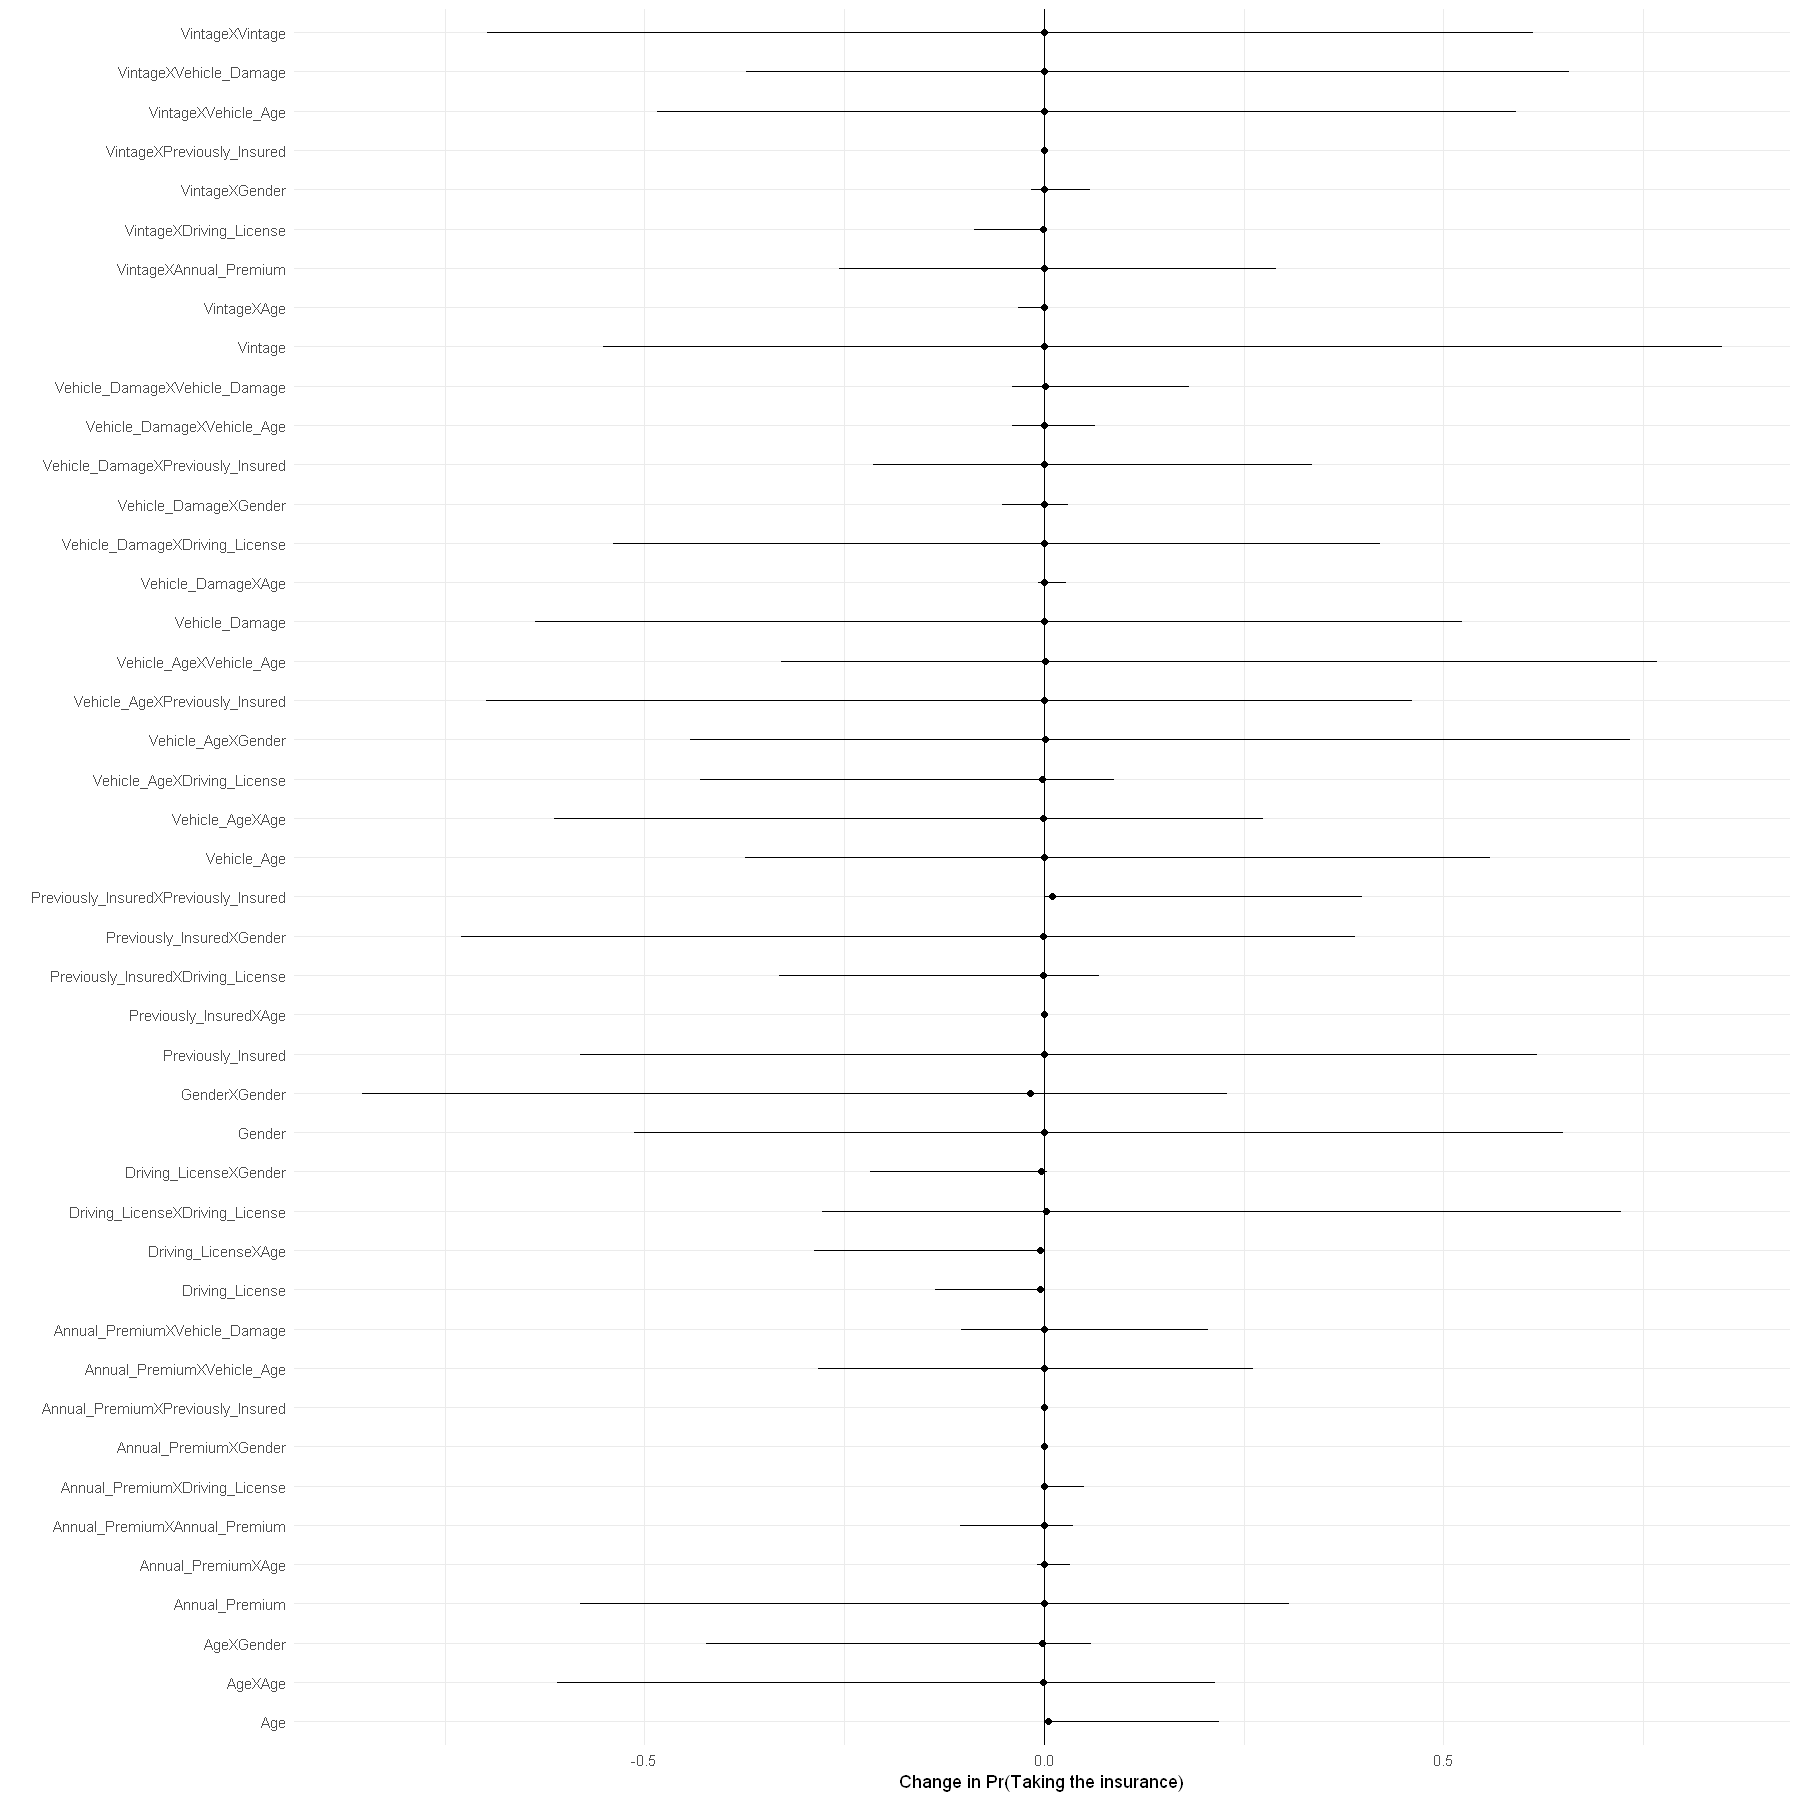

In [269]:
ggplot(data = first_difference.jags2, 
       aes(x = median_fd, y = VarName)) + 
  geom_point() + 
  geom_segment(aes(x = lower_fd, xend = upper_fd, yend = VarName)) + 
  geom_vline(xintercept = 0) + 
  xlab("Change in Pr(Taking the insurance)") + 
  ylab("") +
  theme_minimal()

In [272]:
first_difference.jags2["median_fd"]

,median_fd
Gender,3.207053e-05
Age,5.648927e-03
Driving_License,-4.642555e-03
Previously_Insured,6.850722e-05
Vehicle_Age,6.165945e-05
Vehicle_Damage,-1.436884e-04
Annual_Premium,-3.327447e-04
Vintage,5.661929e-04
GenderXGender,-1.788984e-02
AgeXGender,-2.620788e-03


In [290]:
aux=first_difference.jags2[order(abs(first_difference.jags2$median_fd),decreasing = TRUE),]
aux

,median_fd,lower_fd,upper_fd,VarName,VarID
GenderXGender,-1.788984e-02,-8.537293e-01,2.296194e-01,GenderXGender,9
Previously_InsuredXPreviously_Insured,1.011435e-02,-1.543568e-04,3.985111e-01,Previously_InsuredXPreviously_Insured,18
Age,5.648927e-03,2.998672e-08,2.197509e-01,Age,2
Driving_LicenseXAge,-4.909437e-03,-2.880136e-01,1.545731e-03,Driving_LicenseXAge,13
Driving_License,-4.642555e-03,-1.361532e-01,-1.490051e-07,Driving_License,3
Driving_LicenseXGender,-3.483105e-03,-2.175893e-01,3.594133e-03,Driving_LicenseXGender,12
AgeXGender,-2.620788e-03,-4.224192e-01,5.938720e-02,AgeXGender,10
Vehicle_AgeXDriving_License,-2.309152e-03,-4.308274e-01,8.778948e-02,Vehicle_AgeXDriving_License,21
Driving_LicenseXDriving_License,2.197849e-03,-2.774640e-01,7.216724e-01,Driving_LicenseXDriving_License,14
Vehicle_AgeXVehicle_Age,1.780408e-03,-3.289240e-01,7.675508e-01,Vehicle_AgeXVehicle_Age,23


In [295]:
list(aux$VarName)

[[1]]
 [1] "GenderXGender"                        
 [2] "Previously_InsuredXPreviously_Insured"
 [3] "Age"                                  
 [4] "Driving_LicenseXAge"                  
 [5] "Driving_License"                      
 [6] "Driving_LicenseXGender"               
 [7] "AgeXGender"                           
 [8] "Vehicle_AgeXDriving_License"          
 [9] "Driving_LicenseXDriving_License"      
[10] "Vehicle_AgeXVehicle_Age"              
[11] "AgeXAge"                              
[12] "Previously_InsuredXDriving_License"   
[13] "Vehicle_AgeXGender"                   
[14] "VintageXDriving_License"              
[15] "Vehicle_DamageXVehicle_Damage"        
[16] "Vehicle_AgeXAge"                      
[17] "Previously_InsuredXGender"            
[18] "VintageXVehicle_Damage"               
[19] "Vintage"                              
[20] "Annual_PremiumXDriving_License"       
[21] "Annual_Premium"                       
[22] "Annual_PremiumXVehicle_Damage"        
[23] "VintageXAge"                          
[24] "Annual_PremiumXAnnual_Premium"        
[25] "Vehicle_AgeXPreviously_Insured"       
[26] "Vehicle_Damage"                       
[27] "VintageXGender"                       
[28] "Annual_PremiumXAge"                   
[29] "Vehicle_DamageXAge"                   
[30] "Vehicle_DamageXDriving_License"       
[31] "VintageXVehicle_Age"                  
[32] "Previously_Insured"                   
[33] "Vehicle_Age"                          
[34] "Annual_PremiumXGender"                
[35] "Gender"                               
[36] "Vehicle_DamageXPreviously_Insured"    
[37] "VintageXVintage"                      
[38] "Vehicle_DamageXGender"                
[39] "Vehicle_DamageXVehicle_Age"           
[40] "VintageXAnnual_Premium"               
[41] "Annual_PremiumXVehicle_Age"           
[42] "Previously_InsuredXAge"               
[43] "Annual_PremiumXPreviously_Insured"    
[44] "VintageXPreviously_Insured"